Radiomics feature selection  
  
E. Lavrova  
05.05.2020  
  
Performed on CRC Liege dataset, separately for T1w-, PD-, MT-, R1-, R2s- based features.
Before the analysis, dataset is split into train and test subsets (80/20 %), stratified in relation to outcome, age, gender and scanner balance. As the original dataset has a small size (36 HC and 36 MS), which is decreased after train/test split (29 HC and 28 MS in train subset), to maintain stability of the selected features, feature selection is performed with bootstrapping approach (sampling with replacement) on each step of the pipeline, extending training subset to random 'synthetic' subsets with size of 100 observations (50 HC and 50 MS).  

Feature selection steps:  
* excluding features with zero or low variance (feature was considered of low variance if the percentage of its distinct values out of number of observations was less than 10% and ratio of its most frequent values was more than 95/5),  
* excluding features with high inter-correlation (by calculating the pairwise Spearman correlation between all the features and excluding features which correlate highly (r_S >0.85) in a pair as well as having the highest correlation on average with all the remaining features),   
* selection of the 'best performing features' with RFC-based RFE method.

Length of feature vector is estimated according to the approach: 1 feature per 10 observations in class (Abu-Mostafa, Y. S., Magdon-Ismail, M., & Lin, H. T. (2012). Learning from data (Vol. 4). New York, NY, USA:: AMLBook. ISBN 978-1600490064 Available: http://work.caltech.edu/textbook.html)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
from sklearn.feature_selection import SelectKBest, SelectFromModel, f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import seaborn as sns

In [2]:
sns.set_context('notebook')

In [3]:
df_feat_analysis = pd.read_csv('../features_analysis/features_analysis.csv', index_col = 0)

# User-defined functions

In [36]:
def selectNonUniform(df_in, ftrs, outc):
    
    # selection of the features, which have non-low variance; 
    # for stability of the selected features, bootstrapping approach is used: 
    # in each bootstrap split, the random subsample, stratified in relation to outcome, 
    # is formed, based on original observations from input dataset;
    # in each bootstrap split, features with 'low variance' are detected;
    # for each input feature, its frequency to appear as 'low variant' is calculated,
    # features, appeared in 50 % of splits as 'low variant', are excluded from feature set
    
    # input:
    # df_in - input dataframe, containing feature values (dataframe, columns = features, rows = observations),
    # ftrs - list of dataframe features, used in analysis (list of feature names - string variables),
    # outc - name of dataframe outcome variable (string),
    # std_th - threshold for maximum std, defining 'low variance' of feature (float)
    
    # output:
    # non_uniform_features - list of names of features, which did not appear as 'low variant' in 50 % of splits 
    # (list of string)     
    
    ftrs_non_constant = df_in[ftrs].std().loc[df_in.round(2).std(axis=0) > 0.0].index.values
    
    non_uniform_features = []
    
    for ftr in ftrs_non_constant:
        
        ftr_freqs = pd.DataFrame(df_in[ftr].round(2).value_counts())
        f1 = int(ftr_freqs.iloc[0])
        f2 = int(ftr_freqs.iloc[1])
        f = len(ftr_freqs)
        p1 = f/len(df_in[ftrs])
        
        p2 = f1/f2
        if p1<=0.1 and p2 >= 95/5:
            print (ftr,  ' excluded')
        else:
            non_uniform_features.append(ftr)
    
    print ('Non uniform features: ', non_uniform_features)
    
    return non_uniform_features

def selectNonIntercorrelated(df_in, ftrs, outc, corr_th):
    
    # selection of the features, which are not 'highly intercorrelated' (correlation is defined by Spearman coefficient);
    # pairwise correlation between all the features is calculated, 
    # from each pair of features, considered as intercorrelated, 
    # feature with maximum sum of all the pairwise Spearman correlation coefficients is a 'candidate to be dropped'
    # for stability of the selected features, bootstrapping approach is used: 
    # in each bootstrap split, the random subsample, stratified in relation to outcome, 
    # is formed, based on original observations from input dataset;
    # in each bootstrap split, 'candidates to be dropped' are detected;
    # for each input feature, its frequency to appear as 'candidate to be dropped' is calculated,
    # features, appeared in 50 % of splits as 'candidate to be dropped', are excluded from feature set
    
    # input:
    # df_in - input dataframe, containing feature values (dataframe, columns = features, rows = observations),
    # ftrs - list of dataframe features, used in analysis (list of feature names - string variables),
    # outc - name of dataframe outcome variable (string),
    # corr_th - threshold for Spearman correlation coefficient, defining each pair of features as intercorrelated (float)
    
    # output:
    # non_intercorrelated_features - list of names of features, which did not appear as 'candidated to e dropped' 
    # in 50 % of splits (list of string) 
    
    corr_matrix = df_in.corr(method='spearman').abs()
    mean_absolute_corr = corr_matrix.mean()
    intercorrelated_features_set = []
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    high_corrs = upper.where(upper > corr_th).dropna(how='all', axis=1).dropna(how='all', axis=0)

    for feature in high_corrs.columns:
        mean_absolute_main = mean_absolute_corr[feature]
        correlated_with_feature = high_corrs[feature].index[pd.notnull(high_corrs[feature])]
        for each_correlated_feature in correlated_with_feature:
            mean_absolute = mean_absolute_corr[each_correlated_feature]
            if mean_absolute_main > mean_absolute:
                if feature not in intercorrelated_features_set:
                    intercorrelated_features_set.append(feature)
            else:
                if each_correlated_feature not in intercorrelated_features_set:
                    intercorrelated_features_set.append(each_correlated_feature)

    non_intercorrelated_features_set = [e for e in ftrs if e not in intercorrelated_features_set] 
    
    print ('Non intercorrelated features: ', non_intercorrelated_features_set)
    
    return non_intercorrelated_features_set

def computeUnivarAUC(f_vector, outcome):
    
    # estimation of AUC for binary classifier, built on input feature
    
    # input:
    # f_vector - values of the given feature (1D array of float),
    # outcome - values of binary outcome, corresponding to observations in f_vector (1D array of integer)
    
    # output:
    # auc - AUC value (float)

    mean_0 = np.mean(f_vector[np.where(outcome == 0)])
    mean_1 = np.mean(f_vector[np.where(outcome == 1)])

    feature_min = np.min(f_vector)
    feature_max = np.max(f_vector)

    step = (feature_max - feature_min)/100

    P = np.sum(outcome == 1)
    N = np.sum(outcome == 0)

    th = []
    tprs = []
    fprs = []
    
    if mean_0 > mean_1:

        for i in range (0, 102):
            t = feature_min + i*step
            th.append(t)
            y_pred = (f_vector <= t).astype(int)
            tp = np.sum(y_pred[np.where(outcome == 1)])
            fp = np.sum(y_pred[np.where(outcome == 0)])
            tpr = tp/P
            fpr = fp/N
            tprs.append(tpr)
            fprs.append(fpr)
            
    else:
        
        for i in range (0, 102):
            t = feature_min + i*step
            th.append(t)
            y_pred = (f_vector > t).astype(int)
            tp = np.sum(y_pred[np.where(outcome == 1)])
            fp = np.sum(y_pred[np.where(outcome == 0)])
            tpr = tp/P
            fpr = fp/N
            tprs.append(tpr)
            fprs.append(fpr)
            
    return (auc(fprs, tprs))

def voting_selector(x, y, ftrs, rs=0):
    
    # selection of the most 'important' features (for the given sample) with voting of 3 'weak' selectors:
    # Mann-Whitney test p-value, univariate AUC, importance in logistic regression model
    
    # input:
    # x - array of feature values: rows - observations, columns - features (2D array),
    # y - output vector (1D array),
    # ftrs - list of features (list of strings),
    # rs - seed of the pseudo random number generator for logistic regression model (int)
    
    # output:
    # feature_selection_df - dataframe, containing information about each feature, 
    # if it was selected or not by each 'weak' selector, and ranking all the features, 
    # according to the sum of 'selection events' == 'importance'
    # features_sorted - list of features, ranked, according to the sum of 'selection events'
    
    x_s = MinMaxScaler().fit_transform(x[ftrs])

    # Mann-Whitney
    p_MW = []
    x0 = x.iloc[np.where(y == 0)]
    x1 = x.iloc[np.where(y == 1)]
    for feature in ftrs:
        s, p = sp.stats.mannwhitneyu(x0[feature].astype(float), x1[feature].astype(float), alternative='two-sided')
        p_MW.append(p)
    MW_support = list(np.array(p_MW) < 0.01)

    # Univar
    univar_support = []
    for i in range (0, x_s.shape[1]):
        univar_support.append((computeUnivarAUC(x_s[:,i], y)>=0.75).astype(int))

    # Log Reg
    embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2", dual=True, solver='liblinear',
                                                             random_state=np.random.seed(rs),
                                                             class_weight='balanced'), '1.5*median')
    embeded_lr_selector.fit(x_s, y)
    embeded_lr_support = embeded_lr_selector.get_support()
    embeded_lr_feature = x[ftrs].loc[:, embeded_lr_support].columns.tolist()

    feature_selection_df = pd.DataFrame({'Feature': ftrs,
                                         'Mann_Whitney': MW_support,
                                         'Univariate': univar_support,
                                         'LR': embeded_lr_support})
    feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
    feature_selection_df = feature_selection_df.sort_values(['Total', 'Feature'], ascending=False)
    feature_selection_df.index = range(1, len(feature_selection_df) + 1)

    features_sorted = list(feature_selection_df['Feature'])

    return feature_selection_df, features_sorted

def selectImportant(df_in, ftrs, outc, n_splits):
    
    # selection of the features, which the most 'important', 
    # according to voting of three 'weak' selectors (voting_selector function);
    # for stability of the selected features, bootstrapping approach is used: 
    # in each bootstrap split, the random subsample, stratified in relation to outcome, 
    # is formed, based on original observations from input dataset;
    # in each bootstrap split, 'important' features are detected with voting_selector function;
    # for each input feature, its frequency to appear as 'important' is calculated,
    # features are ranked, according to their 'importance'
    
    # input:
    # df_in - input dataframe, containing feature values (dataframe, columns = features, rows = observations),
    # ftrs - list of dataframe features, used in analysis (list of feature names - string variables),
    # outc - name of dataframe outcome variable (string),
    # n_splits - number of bootstrap splits (int)
    
    # output:
    # important_features_sorted (list of indices) - list of names of features, ranked according their 'importance'
    # (list of string) 

    important_features = []
    
    for i in range(0, n_splits):

        np.random.seed(i)
        subs_0 = np.random.choice(df_in.loc[df_in.outcome == 0].index.values, 50)
        subs_1 = np.random.choice(df_in.loc[df_in.outcome == 1].index.values, 50)
        subs = np.concatenate((subs_0, subs_1), axis = None)
        df_set = df_in.reindex(subs)
        outcome_set = df_set[outc]
        important_features_set = voting_selector(df_set, outcome_set, ftrs)
        important_features.append(important_features_set[1][:15])

    freq_important = []

    for feature in ftrs:
        f = np.sum(np.array(important_features) == feature)
        freq_important.append({'feature': feature, 'f': f})

    important_features_sorted = pd.DataFrame(freq_important).sort_values('f', ascending=False).set_index('feature')

    plt.figure(figsize=(20, 2.5))
    plt.bar(np.arange(len(important_features_sorted)), important_features_sorted['f'].values)
    plt.xticks(np.arange(len(important_features_sorted)), tuple(important_features_sorted.index.values))
    plt.xticks(rotation=-90)
    plt.ylabel('frequency')
    plt.title('Features frequency to be considered as highly important')
    plt.show()

    return important_features_sorted.index.values


def selectPerforming(df_in, ftrs, outc, n_splits, n_select):
    
    # selection of the features for final feature vector, based on their performance for classification task;
    # for this, RFE method is used;
    # for stability of the selected features, bootstrapping approach is used: 
    # in each bootstrap split, the random subsample, stratified in relation to outcome, 
    # is formed, based on original observations from the input dataset;
    # in each bootstrap split, the best n_select features are selected with RFE;
    # for each input feature, its frequency to appear as RFE-selected is calculated,
    # features are ranked, according to this frequency
    
    # input:
    # df_in - input dataframe, containing feature values (dataframe, columns = features, rows = observations),
    # ftrs - list of dataframe features, used in analysis (list of feature names - string variables),
    # outc - name of dataframe outcome variable (string),
    # n_splits - number of bootstrap splits (int),
    # n_select - number of features to be selected with each RFE run (int)
    
    # output:
    # list of names of features, ranked according to RFE-selection events (list of string) 

    model_RF = RandomForestClassifier(n_estimators=100, random_state=np.random.seed(0))
    selector = RFE(model_RF, n_features_to_select=6)
    selected_features = []

    for i in range(0, n_splits):
        np.random.seed(i)
        subs_0 = np.random.choice(df_in.loc[df_in.outcome == 0].index.values, 50)
        subs_1 = np.random.choice(df_in.loc[df_in.outcome == 1].index.values, 50)
        subs = np.concatenate((subs_0, subs_1), axis = None)
        df_set = df_in.reindex(subs)
        
        selector = selector.fit(df_set[ftrs], df_set[outc])
        support = selector.get_support()
        selected_features_set = df_set[ftrs].loc[:, support].columns.tolist()
        selected_features.append(selected_features_set)

    freq_selected = []
    for feature in ftrs:
        f = np.sum(np.array(pd.DataFrame(selected_features)) == feature)
        freq_selected.append({'feature': feature, 'f': f})

    selected_features_sorted = pd.DataFrame(freq_selected).sort_values(by='f', ascending=False).set_index('feature')

    plt.figure(figsize=(9, 2))
    if len(selected_features_sorted)<30:
        plt.bar(np.arange(len(selected_features_sorted)), selected_features_sorted['f'].values)
        plt.xticks(np.arange(len(selected_features_sorted)), tuple(selected_features_sorted.index.values))
    else:
        plt.bar(np.arange(int(len(selected_features_sorted)/2)), 
                selected_features_sorted['f'].values[:int(len(selected_features_sorted)/2)])
        plt.xticks(np.arange(int(len(selected_features_sorted)/2)),
                   tuple(selected_features_sorted.index.values[:int(len(selected_features_sorted)/2)]))
    plt.xticks(rotation=-90)
    plt.ylabel('frequency')
    plt.title('Features frequency to be considered as highly performing')
    plt.show()

    return selected_features_sorted[:n_select].index.values

def plotUnivarAUC(feature, outc, df):
    
    # plotting ROC-curve for binary classifier, built on input feature, and estimation of the cerrespondent AUC
    
    # input:
    # feature - name of the feature (string),
    # outc - name of the outcome variable (string),
    # df - input dataframe, containing feature values (dataframe, columns = features, rows = observations)
    
    # output:
    # void (curve is plotted, AUC is shown)

    mean_0 = df.loc[df[outc] == 0][feature].mean()
    mean_1 = df.loc[df[outc] == 1][feature].mean()

    feature_min = np.min(np.array(df[feature]))
    feature_max = np.max(np.array(df[feature]))

    step = (feature_max - feature_min)/100

    x = np.array(df[feature])

    P = len(df.loc[df[outc] == 0])
    N = len(df.loc[df[outc] == 1])

    th = []
    tprs = []
    fprs = []
    
    if mean_0 > mean_1:
        
        for i in range (0, 102):
            t = feature_min + i*step
            th.append(t)
            y_pred = (x <= t).astype(int)
            tp = np.sum(y_pred[np.where(df[outc] == 1)])
            fp = np.sum(y_pred[np.where(df[outc] == 0)])
            tpr = tp/P
            fpr = fp/N
            tprs.append(tpr)
            fprs.append(fpr)
            
    else:
        
        for i in range (0, 102):
            t = feature_min + i*step
            th.append(t)
            y_pred = (x > t).astype(int)
            tp = np.sum(y_pred[np.where(df[outc] == 1)])
            fp = np.sum(y_pred[np.where(df[outc] == 0)])
            tpr = tp/P
            fpr = fp/N
            tprs.append(tpr)
            fprs.append(fpr)
            

    plt.plot(fprs, tprs, label = 'ROC AUC: %.3f' % auc(fprs, tprs))
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    
def plotUnivariateFeatureCharacteristic(features_list, outc, df):
    
    # plotting individual binary classification characteristics for the given features: 
    # univariate ROC and values distribution in given classes
    
    # input:
    # features_list - list of features (list of strings),
    # out - outcome variable name (string),
    # df - input dataframe, containing feature values (dataframe, columns = features, rows = observations)
    
    # output:
    # void (graphs are plotted)
    if 'original_' in features_list[0]:
        plt.figure(figsize = (20, 6))
        n = 1
        for feature in features_list:

            feature_title = feature
            feature_title = feature_title.replace('original_','')
            plt.subplot(2, len(features_list), n)
            plt.grid()
            plotUnivarAUC(feature, outc, df)
            plt.title(feature_title)
            plt.subplot(2, len(features_list), n+len(features_list))
            plt.hist([df.loc[df[outc] == 0][feature], df.loc[df[outc] == 1][feature]], label = ['non-MS', 'MS'])
            plt.title(feature_title.split('_')[0] + '\n' + feature_title.split('_')[1])
            plt.grid()
            plt.legend()
            plt.xlabel('Value')
            plt.ylabel('Counts')
            n += 1
        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize = (20, 3))
        n = 1
        for feature in features_list:
            plt.subplot(1, len(features_list), n)
            plt.hist([df.loc[df[outc] == 0][feature], df.loc[df[outc] == 1][feature]], label = ['non-MS', 'MS'])
            plt.title(feature.split('_')[0] + '\n' + feature.split('_')[1] + '\n' + feature.split('_')[2])
            plt.grid()
            plt.legend()
            plt.xlabel('Value')
            plt.ylabel('Counts')
            n += 1
    


def countfeaturesFromClasses(df_progress, cls, ftrs_list, subset_name):
    
    # calculates number of features of each class in feature list
    
    # input:
    # df_progress - list to add data dictionarys to (list)
    # cls - list of feature classes (list of strings)
    # ftrs_list - list of features (list of strings)
    # subset_name - name of features subset to be mentioned in records (string)
    
    # output:
    # void
    
    for feature_class in cls:
        df_progress.append({'subset': subset_name, 
                            'feature class': feature_class, 
                            'number': len([s for s in ftrs_list if feature_class in s])})


def featuresSelectionPipeline(csv_filename, sub_names, n_splits, n_features, modality_name, roi_name):
    
    # implementation of features selection pipeline for each dataframe, containing features, extracted from certain
    # MRI/qMRI modality and ROI (tissue type);
    # list of selected features is to be saved to 'features_to_model_<modality>_<ROI>.txt' file
    
    # input:
    # csv_filename - name of csv file with feature values dataframe (string),
    # sub_names - list of subjects from dataframe to be included into analysis (list of strings),
    # n_splits - number of bootstrap splits on each feature selection step (integer),
    # n_features - number of features to be selected for final model (integer),
    # modality_name - name of MRI/qMRI modality (string),
    # roi_name - name of ROI (tissue type) (string)
    
    # output:
    # features_to_model - list of finally selected features (list of strings)
    
    ds_train = pd.read_csv(csv_filename, index_col = 0)
    ds_train = ds_train.reindex(sub_names)
    features = ds_train.columns[14:-1]
    
    ds_selection_progress = []
    feature_classes = ['firstorder', 'glcm', 'glrlm', 'glszm', 'gldm', 'ngtdm']
    
    countfeaturesFromClasses(ds_selection_progress, feature_classes, features, 'original')
    
    features_non_uniform = selectNonUniform(ds_train, features, 'outcome')
    ds_train_red = ds_train[[*features_non_uniform, 'outcome']]
    print (ds_train_red.shape[1])
    
    countfeaturesFromClasses(ds_selection_progress, feature_classes, features_non_uniform, 'non-uniform')

    features_non_intercorrelated = selectNonIntercorrelated(ds_train_red, features_non_uniform, 'outcome', 0.85)
    ds_train_red = ds_train[[*features_non_intercorrelated, 'outcome']]
    print (ds_train_red.shape[1])
    
    countfeaturesFromClasses(ds_selection_progress, feature_classes, features_non_intercorrelated, 'non-intercorrelated')

    features_important = selectImportant(ds_train_red, features_non_intercorrelated, 'outcome', n_splits)

    ds_train_red = ds_train[[*features_important, 'outcome']]
    features_to_model = selectPerforming(ds_train_red, features_important,  
                                         'outcome', n_splits, n_features)
    
    countfeaturesFromClasses(ds_selection_progress, feature_classes, features_to_model[:6], 'selected')
    
    ds_selection_progress = pd.DataFrame(ds_selection_progress)
    
    plt.figure(figsize = (9, 4.5))
    clrs = sns.color_palette("Blues")
    
    sns.barplot(x='feature class', y='number', label='original', color = clrs[1],
                data=ds_selection_progress.loc[ds_selection_progress.subset == 'original'])
    sns.barplot(x='feature class', y='number', label='non-uniform', color = clrs[2],
                data=ds_selection_progress.loc[ds_selection_progress.subset == 'non-uniform'])
    sns.barplot(x='feature class', y='number', label='non-intercorrelated', color = clrs[3],
                data=ds_selection_progress.loc[ds_selection_progress.subset == 'non-intercorrelated'])
    sns.barplot(x='feature class', y='number', label='selected', color = clrs[4],
                data=ds_selection_progress.loc[ds_selection_progress.subset == 'selected'])
    plt.legend()
    plt.title('Feature classes sizes in the process of feature selection')
    
    csv_filename_short = csv_filename.split('/')[-1]
    txt_filename = '../features_to_model/' + csv_filename_short.replace('CRC', 'to_model').replace('csv', 'txt')

    with open(txt_filename, 'w') as output:
        for feature in features_to_model:
            output.write(str(feature) + '\n')
            
    plotUnivariateFeatureCharacteristic(features_to_model, 'outcome', ds_train)
    
    if modality_name != 'qMRI':
        features_to_model_global = []
        for feature in features_to_model:
            feature_title = feature
            if 'original_' in feature_title:
                feature_title = feature_title.replace('original','')
            feature_title = modality_name + '_' + roi_name + feature_title
            features_to_model_global.append(feature_title)

        display (df_feat_analysis.reindex(features_to_model_global))
    
    return features_to_model

# Data train/test split

Split of the original dataset into train and test subsets (80/20 %); it is stratified in relation to outcome, age, gender and scanner balance; data description in train/test subsets is presented below. All the feature selection pipeline is performed on train subset, test subset is to be used for classification model internal validation only.

In [12]:
# loading names of subjects, included into analysis

f = open('../names/ds1_names.txt', 'r')
ds_names = f.read().split('\n')
ds_names = ds_names[:-1]
f.close()

# loading of demographic description dataframe

ds_descr = pd.read_csv('../description/CRC_description.csv', index_col=0)
ds_descr = ds_descr = ds_descr.reindex(ds_names)

# stratified split

ds_descr_train, ds_descr_test = train_test_split(ds_descr, test_size=0.2, random_state=1, 
                                                 stratify=ds_descr[['outcome', 'scanner', 'gender']])

ds_names_train = ds_descr_train.index.values # names of subjects to be used for feature selection
ds_names_test = ds_descr_test.index.values # names of subjects to be used for classification model internal validation

# train/test subsets description

rec_train = {'subset': 'train', 
             'size': len(ds_descr_train), 
             'age (mean, min, max)': [ds_descr_train.age.mean(), ds_descr_train.age.min(), ds_descr_train.age.max()], 
             'gender (M, F)': [len(ds_descr_train.loc[ds_descr_train.gender == 'M']), 
                               len(ds_descr_train.loc[ds_descr_train.gender == 'F'])], 
             'scanner (1, 2)': [len(ds_descr_train.loc[ds_descr_train.scanner == 1]), 
                                len(ds_descr_train.loc[ds_descr_train.scanner == 2])], 
             'outcome (0, 1)': [len(ds_descr_train.loc[ds_descr_train.outcome == 0]), 
                                len(ds_descr_train.loc[ds_descr_train.outcome == 1])]}
rec_test = {'subset': 'test', 
             'size': len(ds_descr_test), 
             'age (mean, min, max)': [ds_descr_test.age.mean(), ds_descr_test.age.min(), ds_descr_test.age.max()], 
             'gender (M, F)': [len(ds_descr_test.loc[ds_descr_test.gender == 'M']), 
                               len(ds_descr_test.loc[ds_descr_test.gender == 'F'])], 
             'scanner (1, 2)': [len(ds_descr_test.loc[ds_descr_test.scanner == 1]), 
                                len(ds_descr_test.loc[ds_descr_test.scanner == 2])], 
             'outcome (0, 1)': [len(ds_descr_test.loc[ds_descr_test.outcome == 0]), 
                                len(ds_descr_test.loc[ds_descr_test.outcome == 1])]}

ds_traintest_balance = pd.DataFrame([rec_train, rec_test])
ds_traintest_balance.set_index('subset', inplace = True)

ds_traintest_balance

size        age (mean, min, max) gender (M, F) scanner (1, 2)  \
subset                                                                  
train     57  [45.8421052631579, 21, 65]      [24, 33]       [29, 28]   
test      15              [45.6, 26, 62]        [7, 8]         [8, 7]   

       outcome (0, 1)  
subset                 
train        [29, 28]  
test           [7, 8]

In [31]:
with open("../names/ds1_test_names.txt", "w") as output:
    for name in ds_names_test:
        output.write(str(name) + '\n')

In [32]:
with open("../names/ds1_train_names.txt", "w") as output:
    for name in ds_names_train:
        output.write(str(name) + '\n')

# Features selection

## White matter

T1w

original_glrlm_LongRunLowGrayLevelEmphasis  excluded
original_glrlm_LowGrayLevelRunEmphasis  excluded
original_glrlm_ShortRunLowGrayLevelEmphasis  excluded
original_glszm_LowGrayLevelZoneEmphasis  excluded
original_glszm_SmallAreaLowGrayLevelEmphasis  excluded
original_gldm_LowGrayLevelEmphasis  excluded
Non uniform features:  ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glc

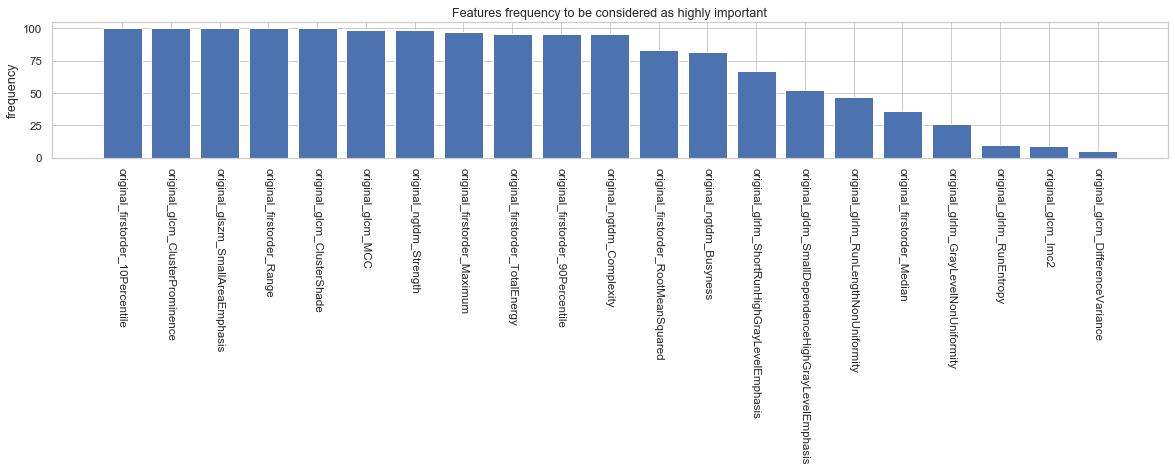

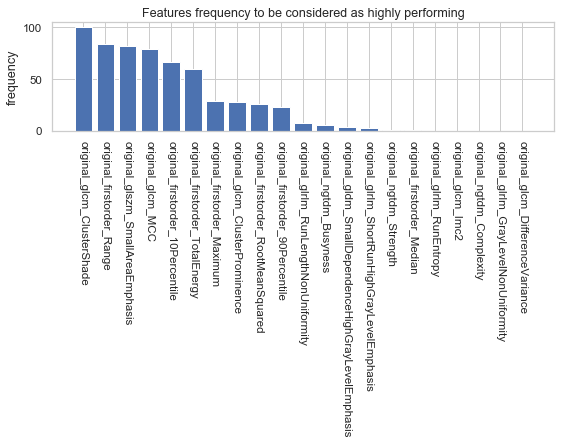

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


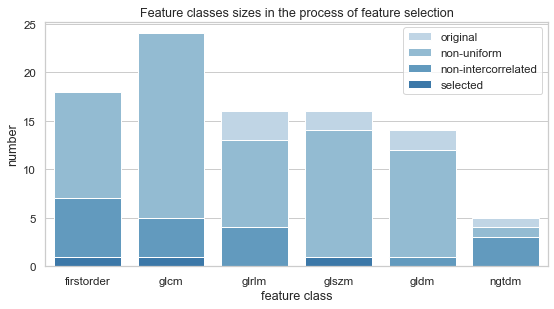

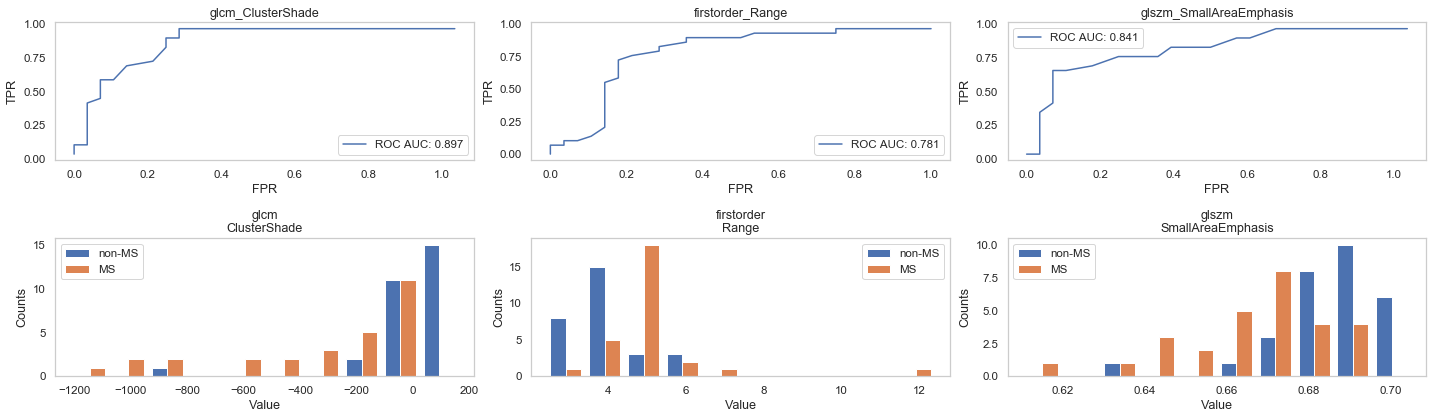

age_slope  age_corr  volume_corr  \
feature                                                            
T1w_WM_glcm_ClusterShade        -2.158681 -0.186371    -0.075182   
T1w_WM_firstorder_Range         -0.004989  0.098699     0.088076   
T1w_WM_glszm_SmallAreaEmphasis   0.000187 -0.077932    -0.063509   

                                outcome_corr  univar_auc  p_MW_corr  
feature                                                              
T1w_WM_glcm_ClusterShade           -0.704382    0.903935   0.000004  
T1w_WM_firstorder_Range             0.558694    0.792438   0.003630  
T1w_WM_glszm_SmallAreaEmphasis     -0.589435    0.840278   0.000988

In [17]:
features_to_model_T1_WM = featuresSelectionPipeline('../features/features_CRC_T1w_WM.csv', ds_names_train, 
                                                    100, 3, 'T1w', 'WM')

PD

original_glszm_SmallAreaLowGrayLevelEmphasis  excluded
Non uniform features:  ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency', 'original_glcm_Contrast', 'original_glcm_Correlation', 'original_glcm_DifferenceAverage', 'original_glcm_DifferenceEntropy', 'original_glcm_DifferenceVariance', 'orig

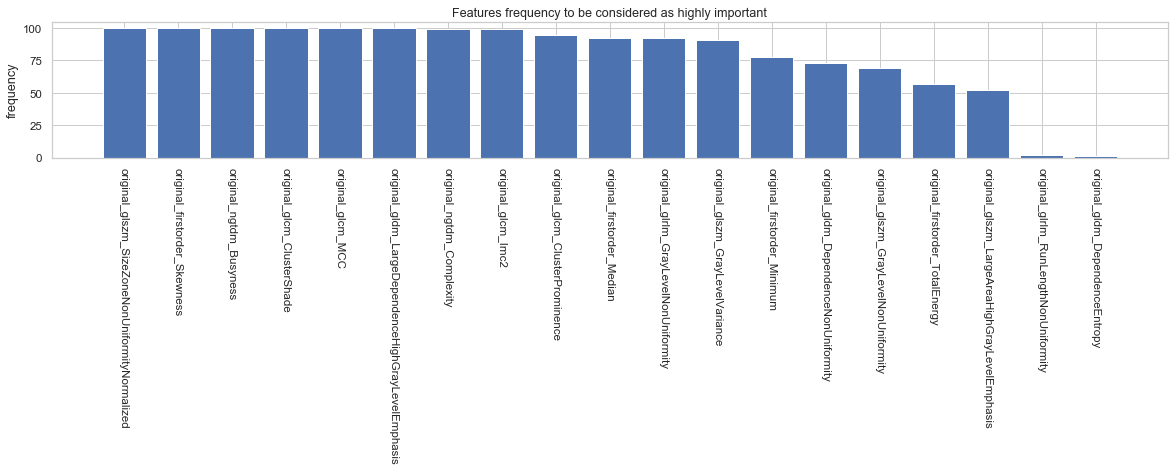

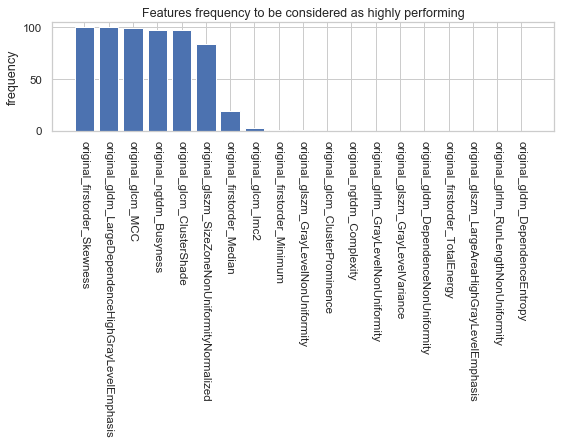

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


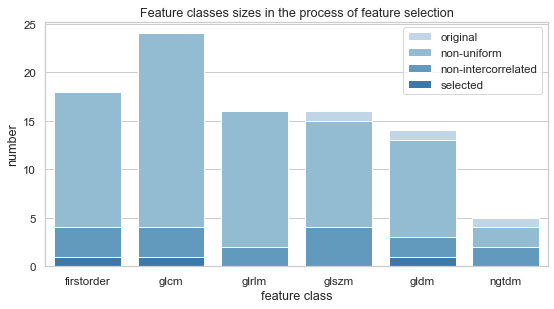

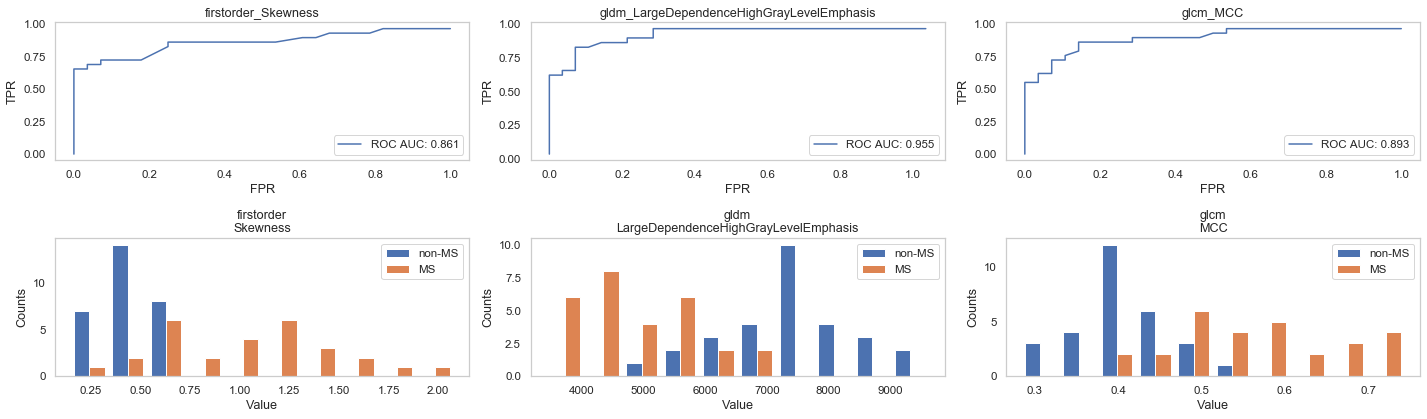

age_slope  age_corr  \
feature                                                                
PD_WM_firstorder_Skewness                         0.004518  0.182202   
PD_WM_gldm_LargeDependenceHighGrayLevelEmphasis   3.777685 -0.005135   
PD_WM_glcm_MCC                                   -0.000964 -0.054364   

                                                 volume_corr  outcome_corr  \
feature                                                                      
PD_WM_firstorder_Skewness                           0.013023      0.723094   
PD_WM_gldm_LargeDependenceHighGrayLevelEmphasis    -0.108046     -0.662948   
PD_WM_glcm_MCC                                      0.227539      0.757845   

                                                 univar_auc     p_MW_corr  
feature                                                                    
PD_WM_firstorder_Skewness                          0.888889  1.618292e-06  
PD_WM_gldm_LargeDependenceHighGrayLevelEmphasis    0.881944  3.379868e-05  
PD_WM_glcm_MCC                                     0.908565  2.493751e-07

In [18]:
features_to_model_PD_WM = featuresSelectionPipeline('../features/features_CRC_PD_WM.csv', ds_names_train, 
                                                    100, 3, 'PD', 'WM')

MT

original_glrlm_LowGrayLevelRunEmphasis  excluded
original_glszm_LowGrayLevelZoneEmphasis  excluded
original_gldm_LowGrayLevelEmphasis  excluded
Non uniform features:  ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency', 'original_glcm_Contrast', 'original_glcm_Correlation', 'original_glcm_Differe

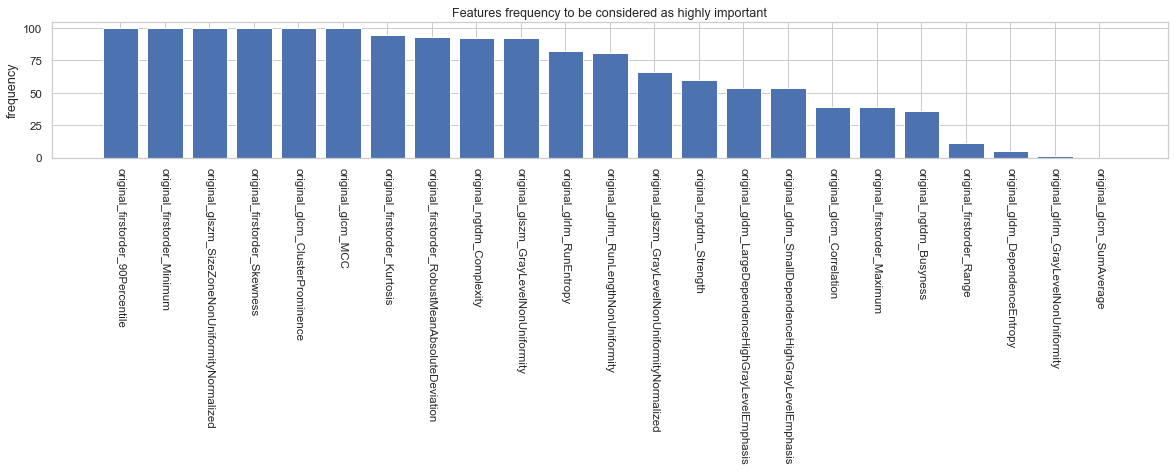

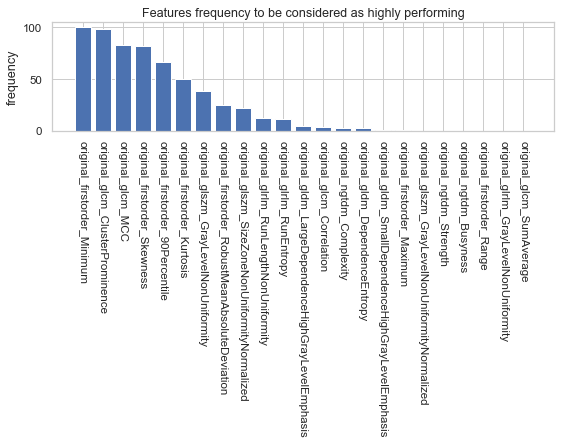

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


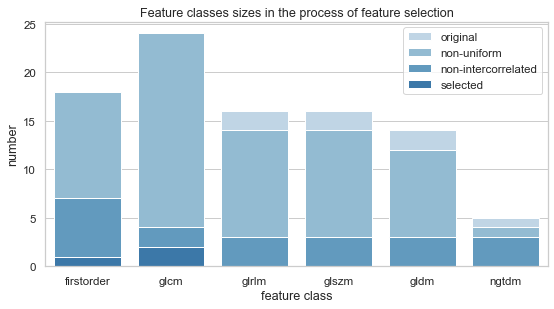

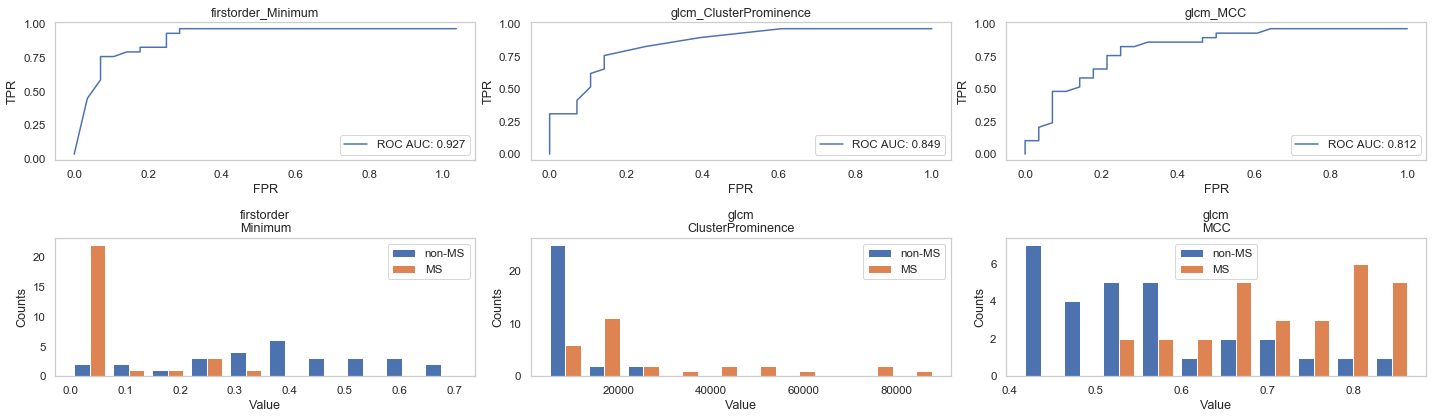

age_slope  age_corr  volume_corr  outcome_corr  \
feature                                                                         
MT_WM_firstorder_Minimum        0.000442 -0.106169    -0.287253     -0.767201   
MT_WM_glcm_ClusterProminence -114.871519 -0.048698     0.010740      0.695026   
MT_WM_glcm_MCC                 -0.000139  0.045108     0.096662      0.642899   

                              univar_auc     p_MW_corr  
feature                                                 
MT_WM_firstorder_Minimum        0.941358  1.485800e-07  
MT_WM_glcm_ClusterProminence    0.874614  6.894708e-06  
MT_WM_glcm_MCC                  0.844136  8.804624e-05

In [19]:
features_to_model_MT_WM = featuresSelectionPipeline('../features/features_CRC_MT_WM.csv', ds_names_train, 
                                                    100, 3, 'MT', 'WM')

R1

original_glrlm_LongRunLowGrayLevelEmphasis  excluded
original_glrlm_LowGrayLevelRunEmphasis  excluded
original_glrlm_ShortRunLowGrayLevelEmphasis  excluded
original_glszm_LowGrayLevelZoneEmphasis  excluded
original_glszm_SmallAreaLowGrayLevelEmphasis  excluded
original_gldm_LowGrayLevelEmphasis  excluded
Non uniform features:  ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glc

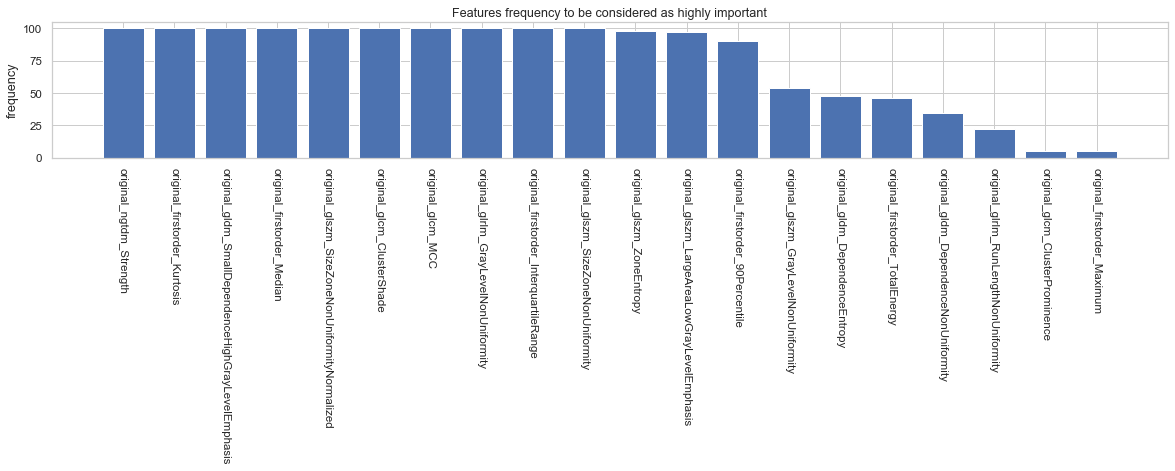

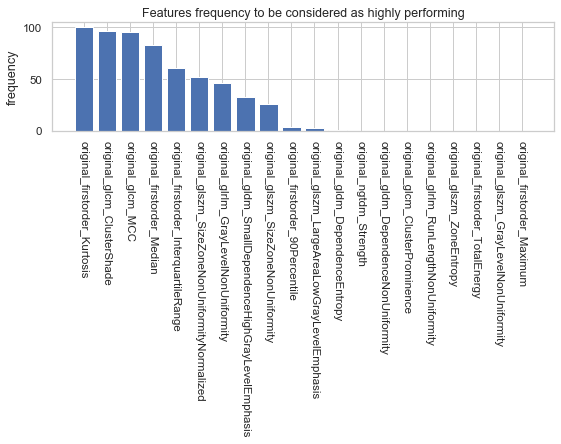

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


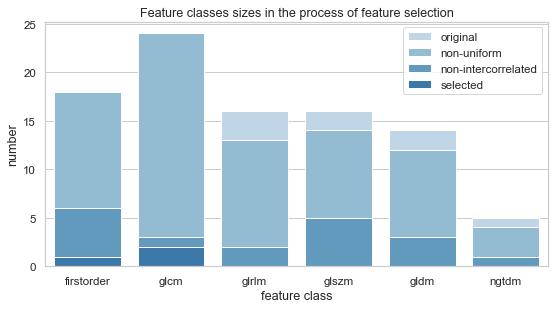

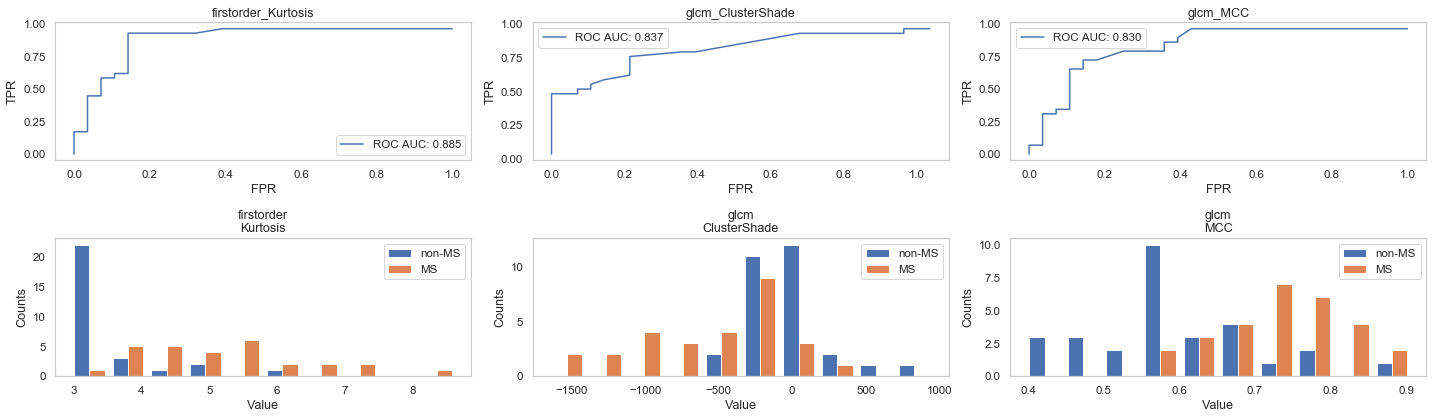

age_slope  age_corr  volume_corr  outcome_corr  \
feature                                                                     
R1_WM_firstorder_Kurtosis  -0.004023  0.025178     0.237732      0.748489   
R1_WM_glcm_ClusterShade    -3.653265 -0.063846     0.040678     -0.640226   
R1_WM_glcm_MCC              0.000223  0.024840     0.125346      0.656265   

                           univar_auc     p_MW_corr  
feature                                              
R1_WM_firstorder_Kurtosis    0.903935  4.160111e-07  
R1_WM_glcm_ClusterShade      0.869213  9.982568e-05  
R1_WM_glcm_MCC               0.852623  4.664899e-05

In [21]:
features_to_model_R1_WM = featuresSelectionPipeline('../features/features_CRC_R1_WM.csv', ds_names_train, 
                                                    100, 3, 'R1', 'WM')

R2*

original_glszm_SmallAreaLowGrayLevelEmphasis  excluded
Non uniform features:  ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency', 'original_glcm_Contrast', 'original_glcm_Correlation', 'original_glcm_DifferenceAverage', 'original_glcm_DifferenceEntropy', 'original_glcm_DifferenceVariance', 'orig

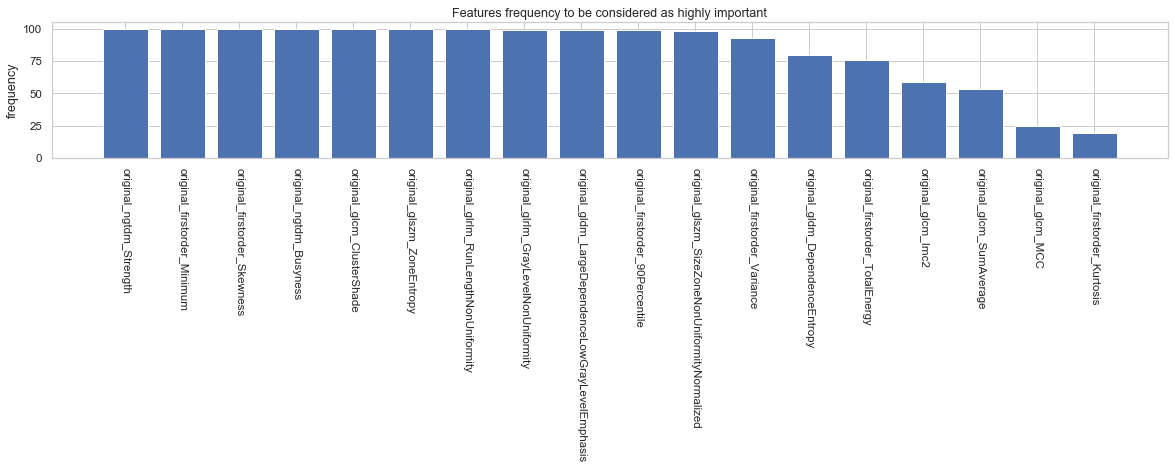

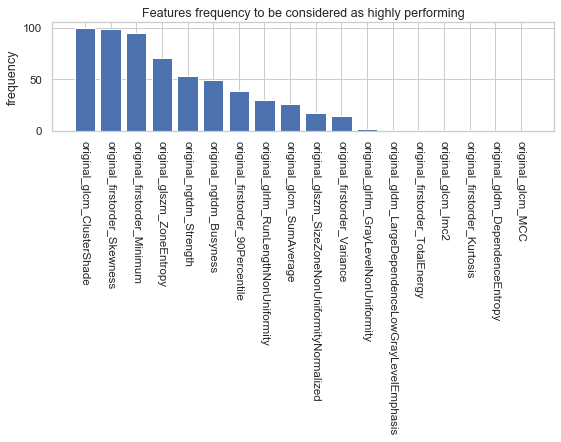

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


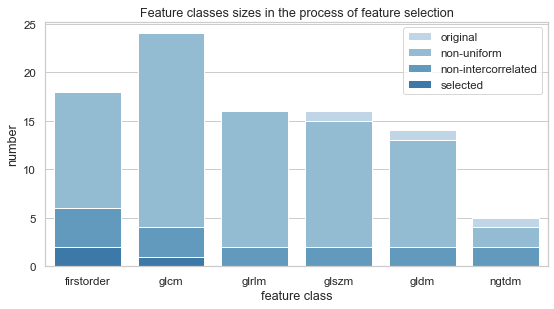

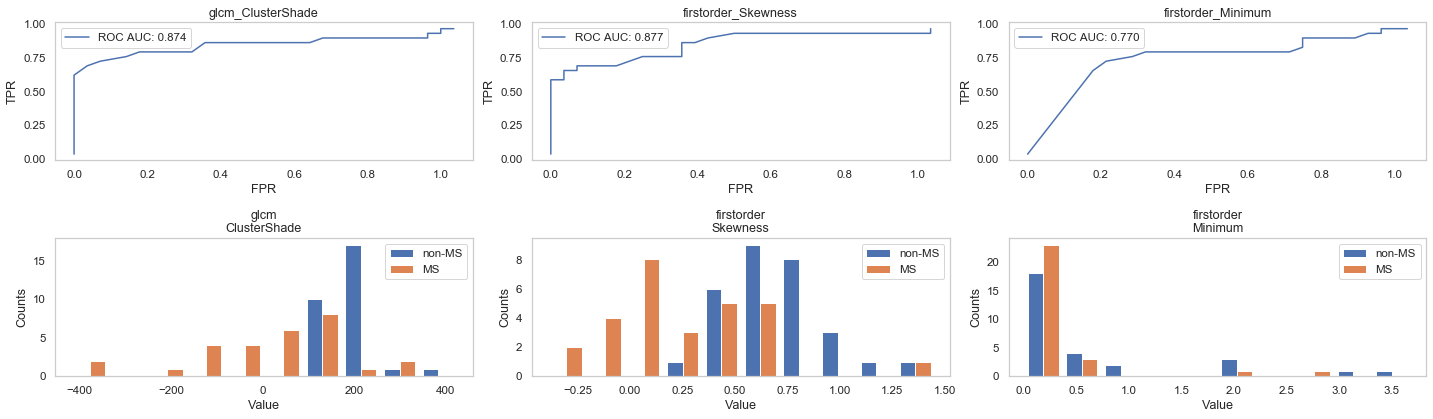

age_slope  age_corr  volume_corr  outcome_corr  \
feature                                                                      
R2s_WM_glcm_ClusterShade     0.088513 -0.046862    -0.107917     -0.626860   
R2s_WM_firstorder_Skewness   0.009131  0.105654    -0.165573     -0.637552   
R2s_WM_firstorder_Minimum    0.021971  0.116134     0.091581     -0.485181   

                            univar_auc  p_MW_corr  
feature                                            
R2s_WM_glcm_ClusterShade      0.861883   0.000186  
R2s_WM_firstorder_Skewness    0.868056   0.000113  
R2s_WM_firstorder_Minimum     0.752315   0.062755

In [22]:
features_to_model_R2s_WM = featuresSelectionPipeline('../features/features_CRC_R2s_WM.csv', ds_names_train, 
                                                    100, 3, 'R2s', 'WM')

Combined qMRI = combined (PD + MT + R1 + R2*)

PD_glszm_SmallAreaLowGrayLevelEmphasis  excluded
MT_glrlm_LowGrayLevelRunEmphasis  excluded
MT_glszm_LowGrayLevelZoneEmphasis  excluded
MT_gldm_LowGrayLevelEmphasis  excluded
R1_glrlm_LongRunLowGrayLevelEmphasis  excluded
R1_glrlm_LowGrayLevelRunEmphasis  excluded
R1_glrlm_ShortRunLowGrayLevelEmphasis  excluded
R1_glszm_LowGrayLevelZoneEmphasis  excluded
R1_glszm_SmallAreaLowGrayLevelEmphasis  excluded
R1_gldm_LowGrayLevelEmphasis  excluded
R2_glszm_SmallAreaLowGrayLevelEmphasis  excluded
Non uniform features:  ['PD_firstorder_10Percentile', 'PD_firstorder_90Percentile', 'PD_firstorder_Energy', 'PD_firstorder_Entropy', 'PD_firstorder_InterquartileRange', 'PD_firstorder_Kurtosis', 'PD_firstorder_Maximum', 'PD_firstorder_MeanAbsoluteDeviation', 'PD_firstorder_Mean', 'PD_firstorder_Median', 'PD_firstorder_Minimum', 'PD_firstorder_Range', 'PD_firstorder_RobustMeanAbsoluteDeviation', 'PD_firstorder_RootMeanSquared', 'PD_firstorder_Skewness', 'PD_firstorder_TotalEnergy', 'PD_firstorder_Unifo

Non intercorrelated features:  ['PD_firstorder_Median', 'PD_firstorder_Minimum', 'PD_glcm_ClusterProminence', 'PD_glcm_ClusterShade', 'PD_glcm_Imc2', 'PD_glcm_MCC', 'PD_glrlm_GrayLevelNonUniformity', 'PD_glszm_GrayLevelNonUniformity', 'PD_glszm_GrayLevelVariance', 'PD_glszm_SmallAreaEmphasis', 'PD_gldm_DependenceEntropy', 'PD_gldm_DependenceNonUniformity', 'PD_gldm_LargeDependenceHighGrayLevelEmphasis', 'PD_ngtdm_Busyness', 'PD_ngtdm_Complexity', 'MT_firstorder_Kurtosis', 'MT_firstorder_Maximum', 'MT_firstorder_Minimum', 'MT_firstorder_Range', 'MT_firstorder_RobustMeanAbsoluteDeviation', 'MT_firstorder_Skewness', 'MT_firstorder_TotalEnergy', 'MT_glcm_MCC', 'MT_glrlm_GrayLevelNonUniformity', 'MT_glrlm_RunEntropy', 'MT_glszm_GrayLevelNonUniformity', 'MT_glszm_GrayLevelNonUniformityNormalized', 'MT_glszm_HighGrayLevelZoneEmphasis', 'MT_glszm_SizeZoneNonUniformity', 'MT_glszm_SizeZoneNonUniformityNormalized', 'MT_gldm_DependenceEntropy', 'MT_gldm_LargeDependenceHighGrayLevelEmphasis', 'MT_

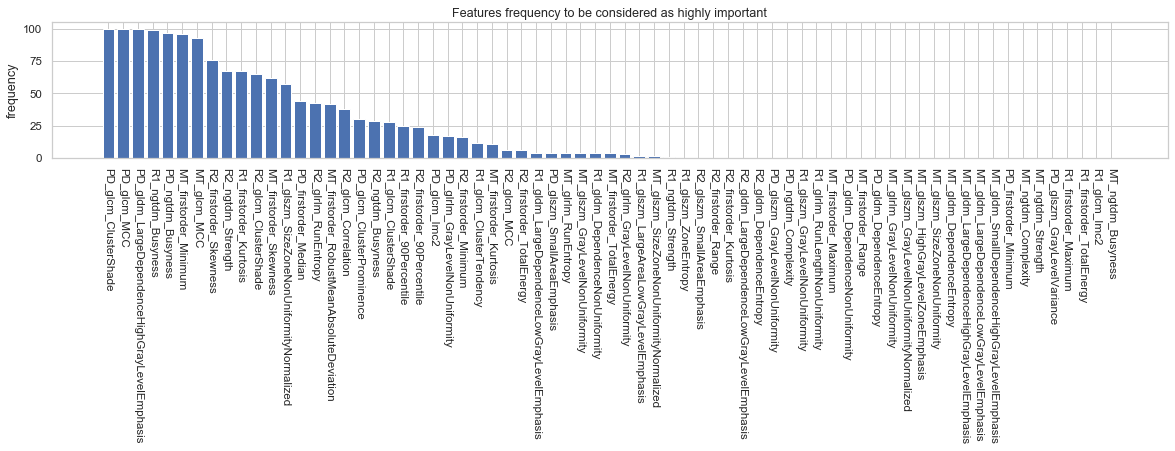

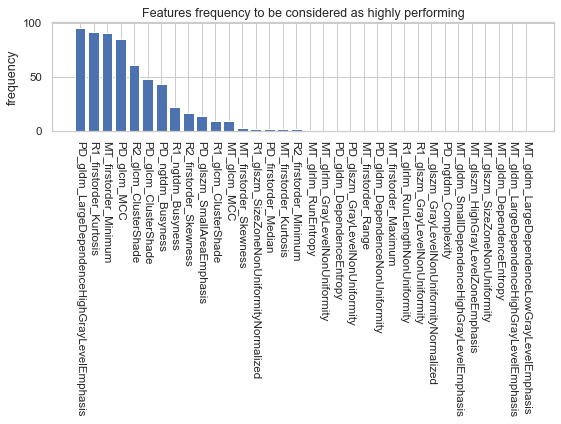

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


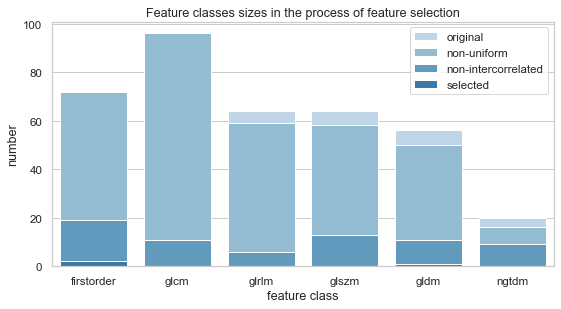

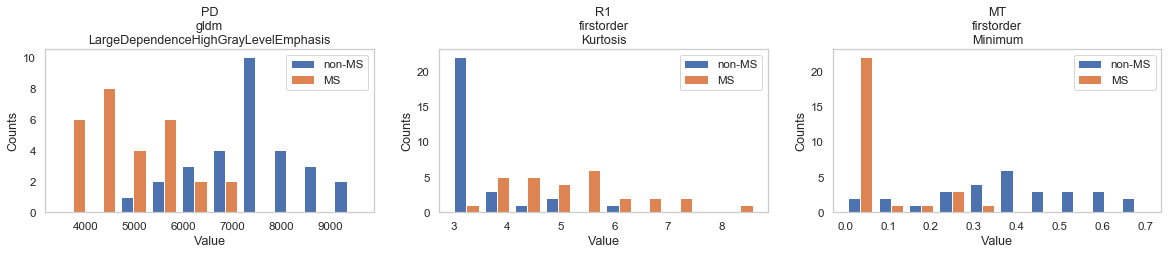

In [23]:
features_to_model_qMRI_WM = featuresSelectionPipeline('../features/features_CRC_qMRI_WM.csv', ds_names_train, 
                                                    100, 3, 'qMRI', 'WM')

## Normal appearing white matter

T1w

original_glrlm_LongRunLowGrayLevelEmphasis  excluded
original_glrlm_LowGrayLevelRunEmphasis  excluded
original_glrlm_ShortRunLowGrayLevelEmphasis  excluded
original_glszm_LowGrayLevelZoneEmphasis  excluded
original_glszm_SmallAreaLowGrayLevelEmphasis  excluded
original_gldm_LowGrayLevelEmphasis  excluded
Non uniform features:  ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glc

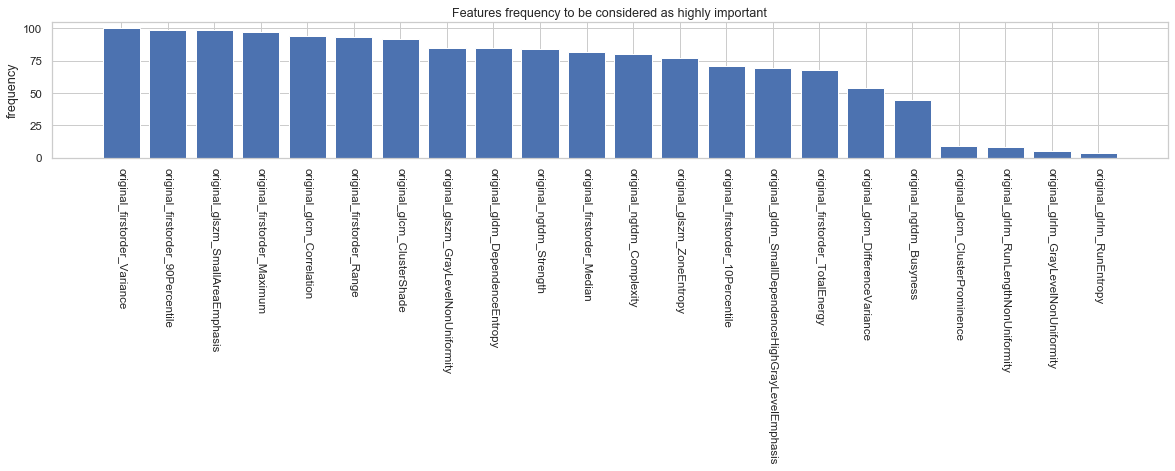

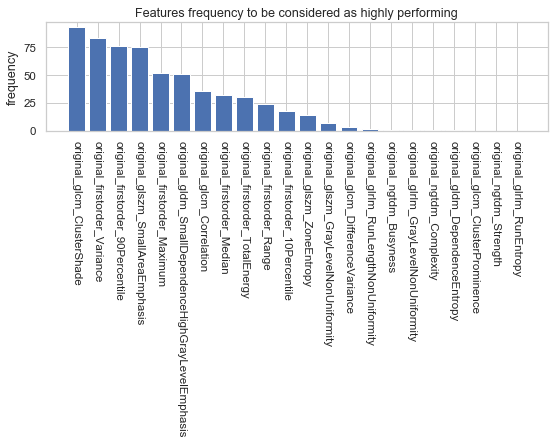

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


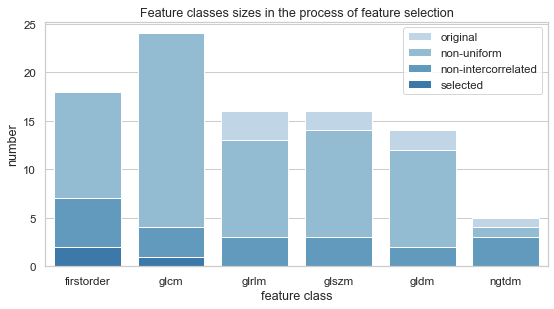

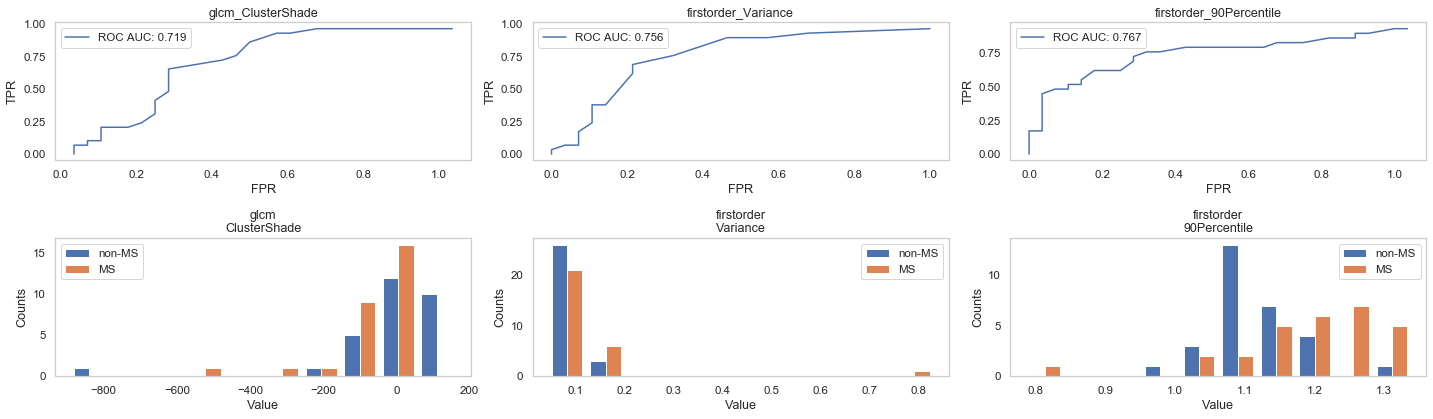

age_slope  age_corr  volume_corr  \
feature                                                              
T1w_NAWM_glcm_ClusterShade        -2.158681 -0.208136    -0.021577   
T1w_NAWM_firstorder_Variance      -0.000873 -0.120384     0.035597   
T1w_NAWM_firstorder_90Percentile  -0.000740  0.053559    -0.019551   

                                  outcome_corr  univar_auc  p_MW_corr  
feature                                                                
T1w_NAWM_glcm_ClusterShade           -0.386274    0.719522   1.000000  
T1w_NAWM_firstorder_Variance          0.518596    0.768519   0.017982  
T1w_NAWM_firstorder_90Percentile      0.471816    0.773920   0.101287

In [24]:
features_to_model_T1_NAWM = featuresSelectionPipeline('../features/features_CRC_T1w_NAWM.csv', ds_names_train, 
                                                    100, 3, 'T1w', 'NAWM')

PD

original_glrlm_LongRunLowGrayLevelEmphasis  excluded
original_glrlm_LowGrayLevelRunEmphasis  excluded
original_glrlm_ShortRunLowGrayLevelEmphasis  excluded
original_glszm_LowGrayLevelZoneEmphasis  excluded
original_glszm_SmallAreaLowGrayLevelEmphasis  excluded
original_gldm_LowGrayLevelEmphasis  excluded
Non uniform features:  ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glc

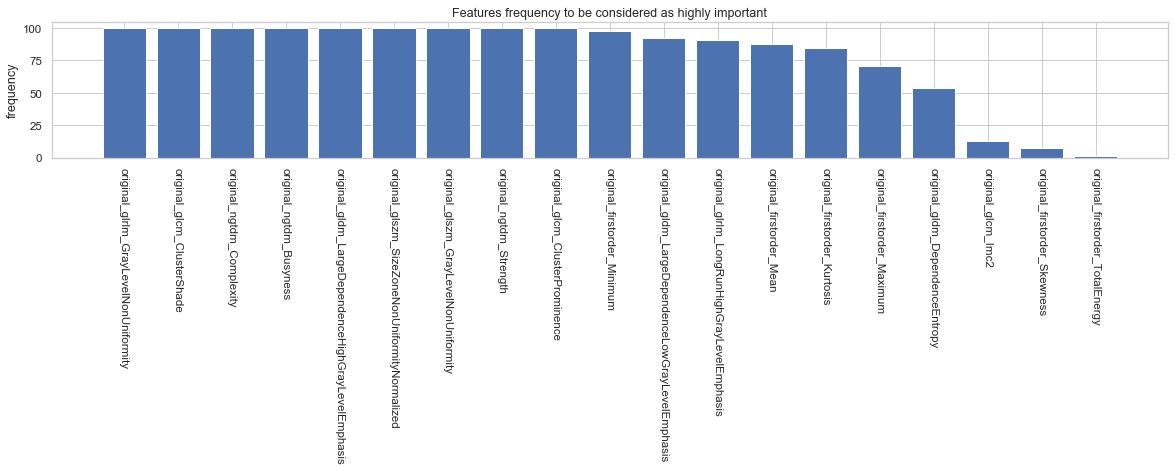

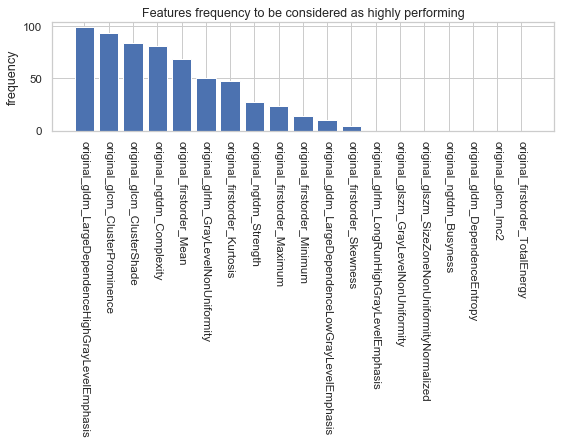

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


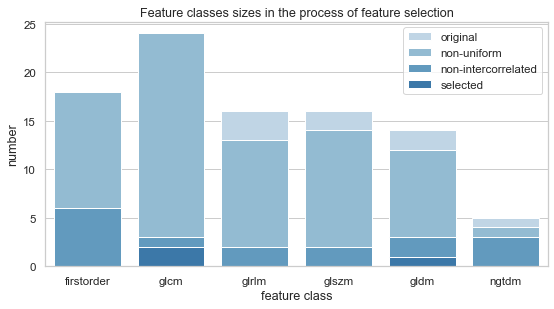

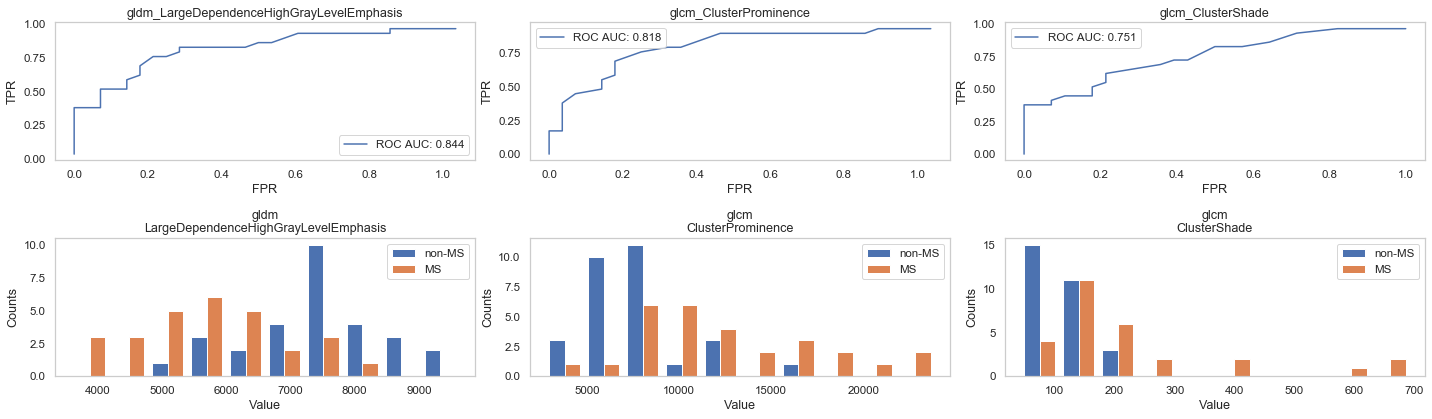

age_slope  age_corr  \
feature                                                                  
PD_NAWM_gldm_LargeDependenceHighGrayLevelEmphasis   3.777685 -0.021250   
PD_NAWM_glcm_ClusterProminence                    -40.853254 -0.082134   
PD_NAWM_glcm_ClusterShade                           0.730938  0.123797   

                                                   volume_corr  outcome_corr  \
feature                                                                        
PD_NAWM_gldm_LargeDependenceHighGrayLevelEmphasis    -0.054602     -0.490528   
PD_NAWM_glcm_ClusterProminence                        0.342852      0.485181   
PD_NAWM_glcm_ClusterShade                             0.109943      0.425035   

                                                   univar_auc  p_MW_corr  
feature                                                                   
PD_NAWM_gldm_LargeDependenceHighGrayLevelEmphasis    0.788194   0.051643  
PD_NAWM_glcm_ClusterProminence                       0.782793   0.062755  
PD_NAWM_glcm_ClusterShade                            0.741127   0.492008

In [25]:
features_to_model_PD_NAWM = featuresSelectionPipeline('../features/features_CRC_PD_NAWM.csv', ds_names_train, 
                                                    100, 3, 'PD', 'NAWM')

MT

original_glrlm_LongRunLowGrayLevelEmphasis  excluded
original_glszm_LowGrayLevelZoneEmphasis  excluded
Non uniform features:  ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency', 'original_glcm_Contrast', 'original_glcm_Correlation', 'original_glcm_DifferenceAverage', 'original_glcm_DifferenceEnt

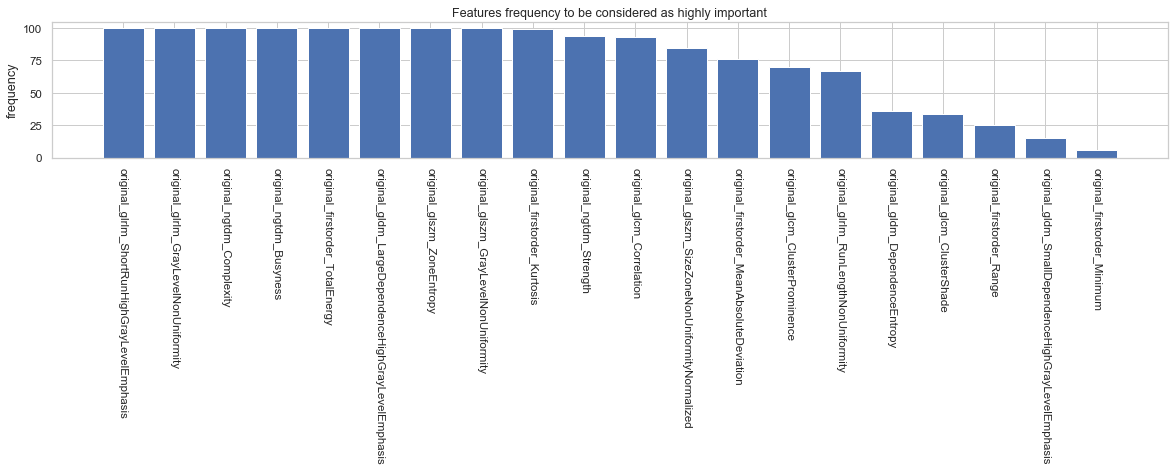

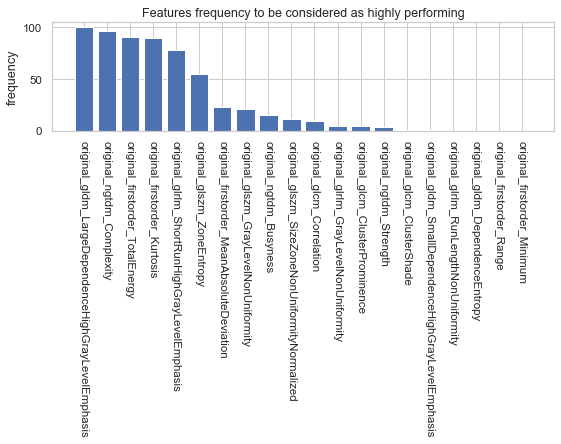

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


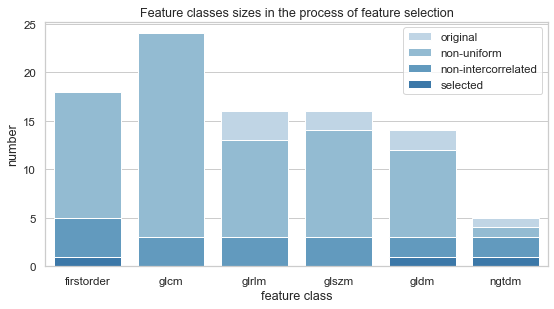

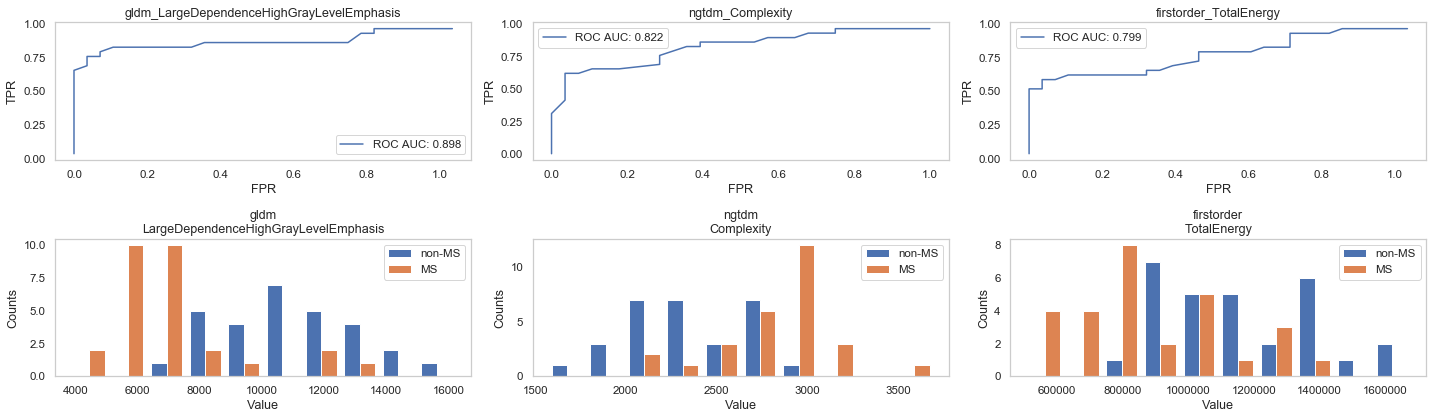

age_slope  age_corr  \
feature                                                                    
MT_NAWM_gldm_LargeDependenceHighGrayLevelEmphasis    67.720450  0.042226   
MT_NAWM_ngtdm_Complexity                             -4.381632 -0.160034   
MT_NAWM_firstorder_TotalEnergy                     5323.226400  0.109228   

                                                   volume_corr  outcome_corr  \
feature                                                                        
MT_NAWM_gldm_LargeDependenceHighGrayLevelEmphasis     0.018201     -0.656265   
MT_NAWM_ngtdm_Complexity                             -0.028105      0.582752   
MT_NAWM_firstorder_TotalEnergy                        0.339861     -0.538645   

                                                   univar_auc  p_MW_corr  
feature                                                                   
MT_NAWM_gldm_LargeDependenceHighGrayLevelEmphasis    0.879244   0.000047  
MT_NAWM_ngtdm_Complexity                             0.809028   0.001318  
MT_NAWM_firstorder_TotalEnergy                       0.809028   0.008191

In [26]:
features_to_model_MT_NAWM = featuresSelectionPipeline('../features/features_CRC_MT_NAWM.csv', ds_names_train, 
                                                    100, 3, 'MT', 'NAWM')

R1

original_glrlm_LongRunLowGrayLevelEmphasis  excluded
original_glrlm_LowGrayLevelRunEmphasis  excluded
original_glrlm_ShortRunLowGrayLevelEmphasis  excluded
original_glszm_LowGrayLevelZoneEmphasis  excluded
original_glszm_SmallAreaLowGrayLevelEmphasis  excluded
original_gldm_LowGrayLevelEmphasis  excluded
Non uniform features:  ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glc

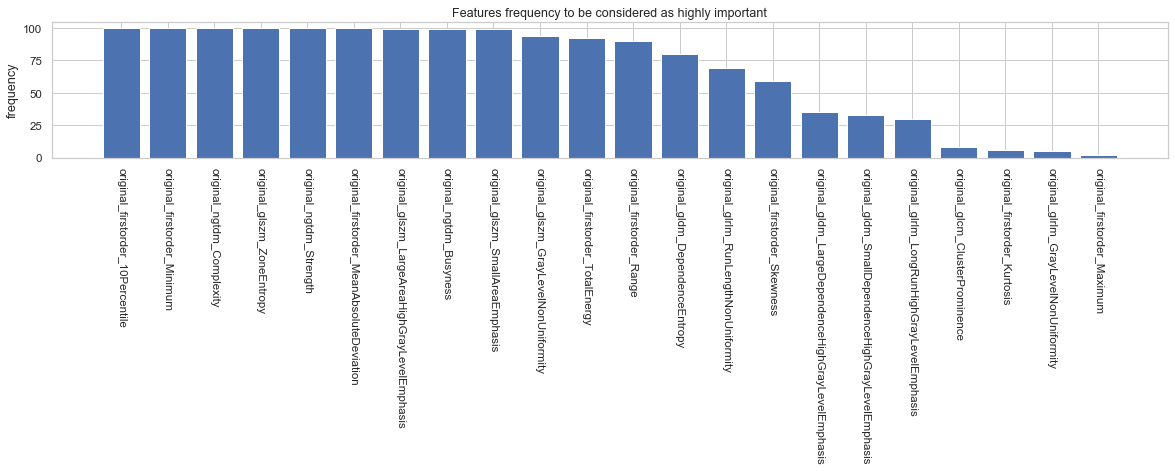

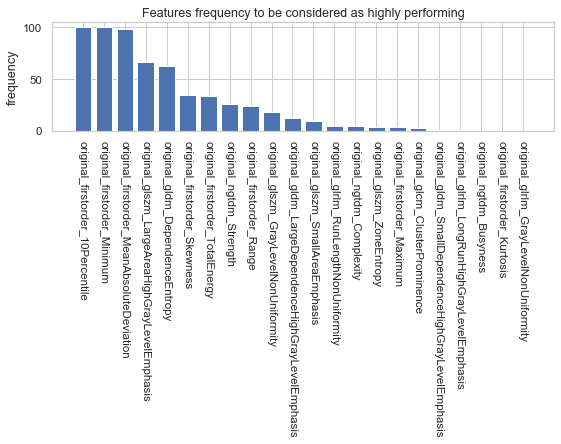

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


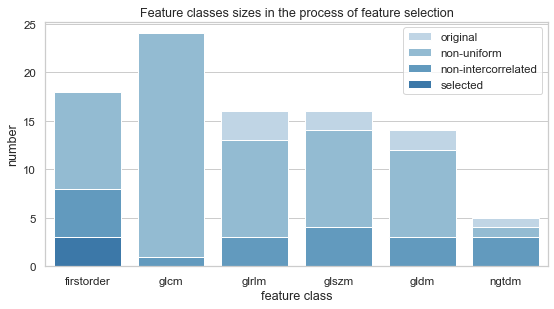

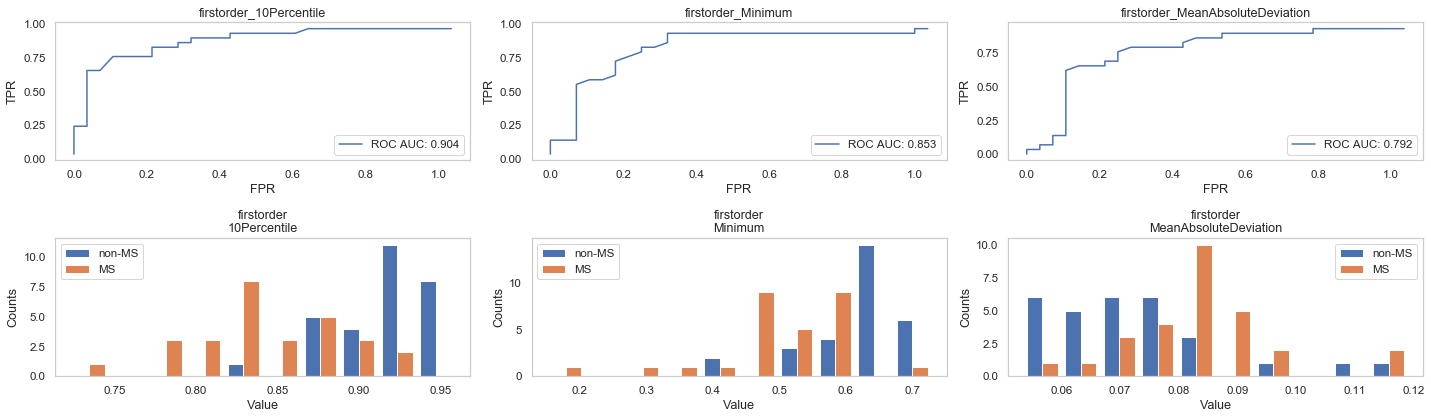

age_slope  age_corr  volume_corr  \
feature                                                                      
R1_NAWM_firstorder_10Percentile            0.000022 -0.086915     0.085793   
R1_NAWM_firstorder_Minimum                -0.001109 -0.184423    -0.146344   
R1_NAWM_firstorder_MeanAbsoluteDeviation  -0.000182  0.059645     0.215384   

                                          outcome_corr  univar_auc  p_MW_corr  
feature                                                                        
R1_NAWM_firstorder_10Percentile              -0.676313    0.891204   0.000018  
R1_NAWM_firstorder_Minimum                   -0.650918    0.874614   0.000060  
R1_NAWM_firstorder_MeanAbsoluteDeviation      0.560030    0.824460   0.003435

In [27]:
features_to_model_R1_NAWM = featuresSelectionPipeline('../features/features_CRC_R1_NAWM.csv', ds_names_train, 
                                                    100, 3, 'R1', 'NAWM')

R2*

original_glrlm_LongRunLowGrayLevelEmphasis  excluded
original_glrlm_LowGrayLevelRunEmphasis  excluded
original_glrlm_ShortRunLowGrayLevelEmphasis  excluded
original_glszm_LowGrayLevelZoneEmphasis  excluded
original_glszm_SmallAreaLowGrayLevelEmphasis  excluded
original_gldm_LowGrayLevelEmphasis  excluded
Non uniform features:  ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glc

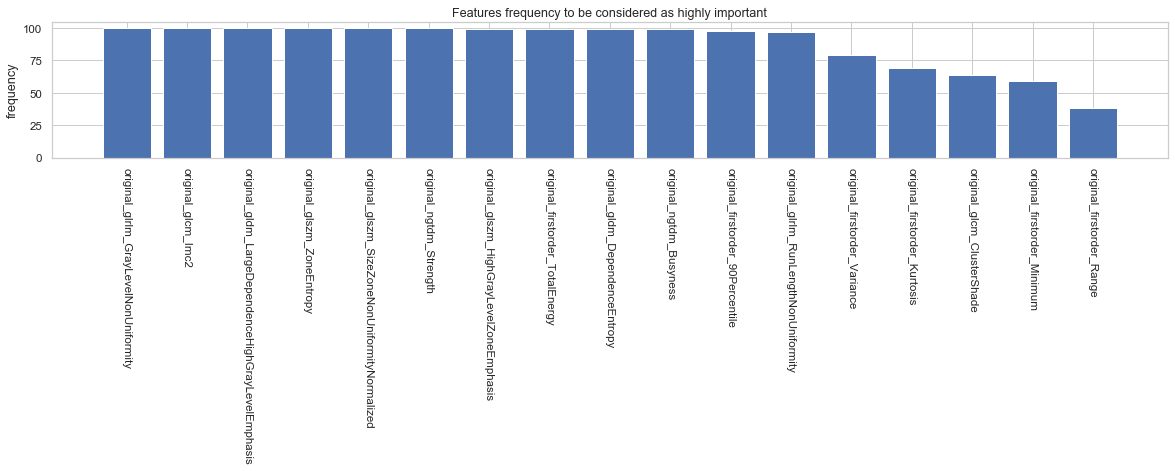

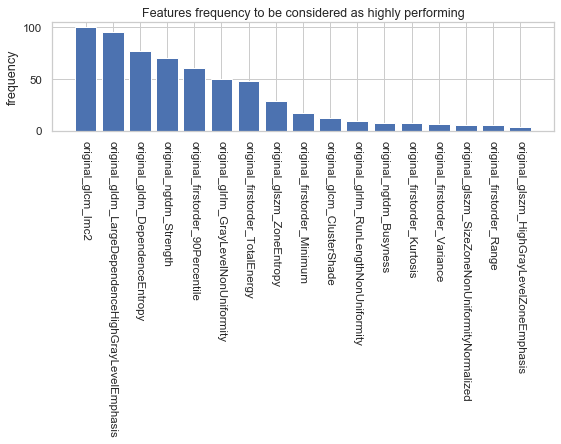

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


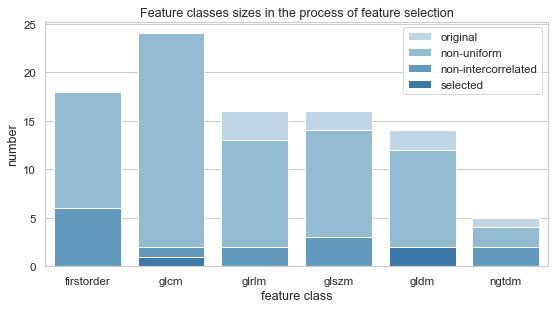

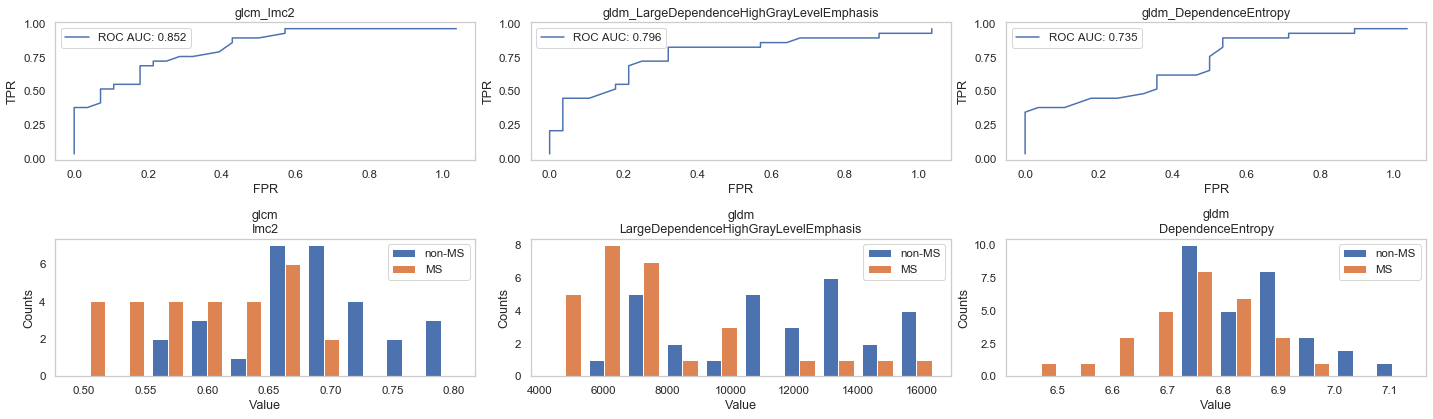

age_slope  age_corr  \
feature                                                                   
R2s_NAWM_glcm_Imc2                                   0.001619  0.207026   
R2s_NAWM_gldm_LargeDependenceHighGrayLevelEmphasis  99.736784  0.080428   
R2s_NAWM_gldm_DependenceEntropy                      0.000428  0.063540   

                                                    volume_corr  outcome_corr  \
feature                                                                         
R2s_NAWM_glcm_Imc2                                     0.082031     -0.558694   
R2s_NAWM_gldm_LargeDependenceHighGrayLevelEmphasis    -0.030774     -0.535972   
R2s_NAWM_gldm_DependenceEntropy                        0.329925     -0.370235   

                                                    univar_auc  p_MW_corr  
feature                                                                    
R2s_NAWM_glcm_Imc2                                    0.826003   0.003630  
R2s_NAWM_gldm_LargeDependenceHighGrayLevelEmphasis    0.810185   0.009111  
R2s_NAWM_gldm_DependenceEntropy                       0.711420   1.000000

In [28]:
features_to_model_R2s_NAWM = featuresSelectionPipeline('../features/features_CRC_R2s_NAWM.csv', ds_names_train, 
                                                    100, 3, 'R2s', 'NAWM')

Combined qMRI = combined (PD + MT + R1 + R2*)

PD_glrlm_LongRunLowGrayLevelEmphasis  excluded
PD_glrlm_LowGrayLevelRunEmphasis  excluded
PD_glrlm_ShortRunLowGrayLevelEmphasis  excluded
PD_glszm_LowGrayLevelZoneEmphasis  excluded
PD_glszm_SmallAreaLowGrayLevelEmphasis  excluded
PD_gldm_LowGrayLevelEmphasis  excluded
MT_glrlm_LongRunLowGrayLevelEmphasis  excluded
MT_glszm_LowGrayLevelZoneEmphasis  excluded
R1_glrlm_LongRunLowGrayLevelEmphasis  excluded
R1_glrlm_LowGrayLevelRunEmphasis  excluded
R1_glrlm_ShortRunLowGrayLevelEmphasis  excluded
R1_glszm_LowGrayLevelZoneEmphasis  excluded
R1_glszm_SmallAreaLowGrayLevelEmphasis  excluded
R1_gldm_LowGrayLevelEmphasis  excluded
R2_glrlm_LongRunLowGrayLevelEmphasis  excluded
R2_glrlm_LowGrayLevelRunEmphasis  excluded
R2_glrlm_ShortRunLowGrayLevelEmphasis  excluded
R2_glszm_LowGrayLevelZoneEmphasis  excluded
R2_glszm_SmallAreaLowGrayLevelEmphasis  excluded
R2_gldm_LowGrayLevelEmphasis  excluded
Non uniform features:  ['PD_firstorder_10Percentile', 'PD_firstorder_90Percentile', 'PD_firstorder_

Non intercorrelated features:  ['PD_firstorder_Kurtosis', 'PD_firstorder_Maximum', 'PD_firstorder_RootMeanSquared', 'PD_firstorder_Skewness', 'PD_glcm_ClusterProminence', 'PD_glcm_ClusterShade', 'PD_glcm_Correlation', 'PD_glcm_SumAverage', 'PD_glrlm_GrayLevelNonUniformity', 'PD_glszm_GrayLevelNonUniformity', 'PD_glszm_SizeZoneNonUniformityNormalized', 'PD_gldm_DependenceEntropy', 'PD_gldm_LargeDependenceHighGrayLevelEmphasis', 'PD_gldm_SmallDependenceHighGrayLevelEmphasis', 'PD_ngtdm_Busyness', 'PD_ngtdm_Complexity', 'PD_ngtdm_Strength', 'MT_firstorder_Kurtosis', 'MT_firstorder_Minimum', 'MT_firstorder_Range', 'MT_firstorder_TotalEnergy', 'MT_firstorder_Variance', 'MT_glcm_ClusterProminence', 'MT_glcm_ClusterShade', 'MT_glcm_Correlation', 'MT_glrlm_GrayLevelNonUniformity', 'MT_glrlm_ShortRunHighGrayLevelEmphasis', 'MT_glszm_GrayLevelNonUniformity', 'MT_glszm_SizeZoneNonUniformity', 'MT_glszm_SizeZoneNonUniformityNormalized', 'MT_gldm_DependenceEntropy', 'MT_gldm_SmallDependenceHighGray

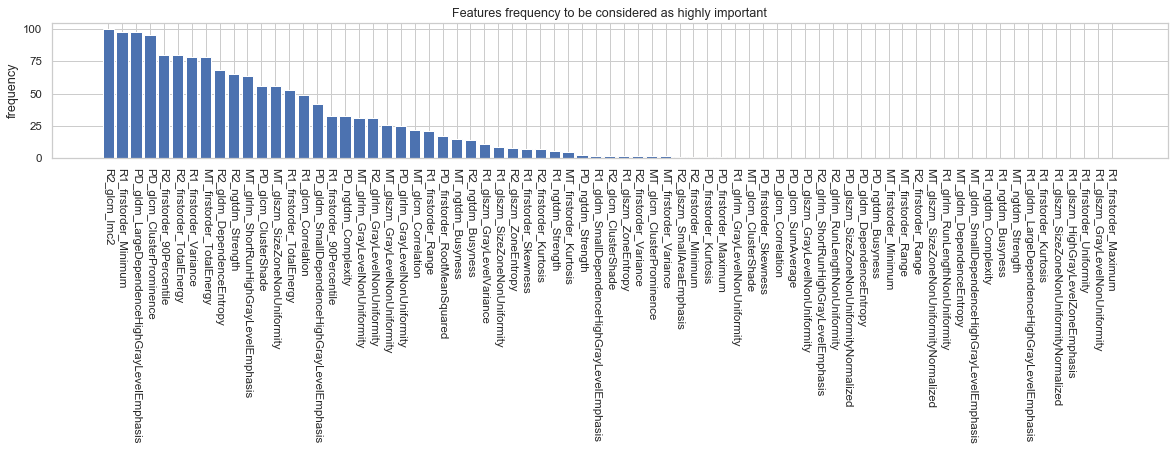

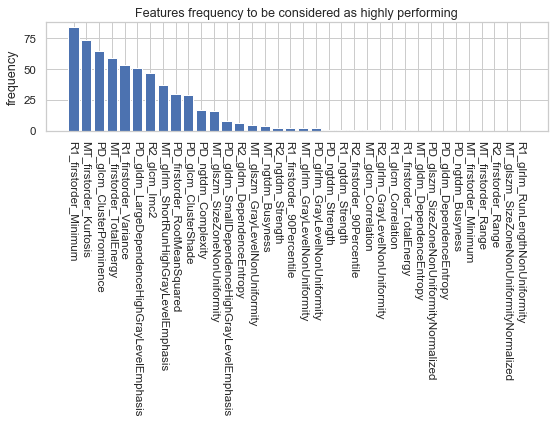

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


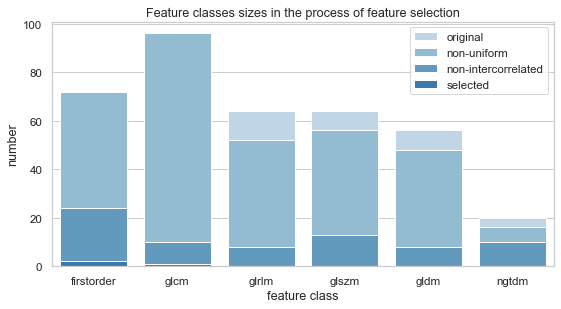

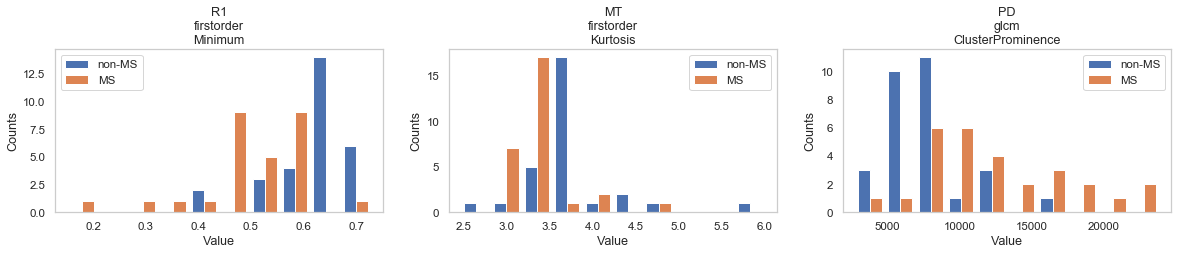

In [29]:
features_to_model_qMRI_NAWM = featuresSelectionPipeline('../features/features_CRC_qMRI_NAWM.csv', ds_names_train, 
                                                    100, 3, 'qMRI', 'NAWM')

## Gray matter

T1w

Non uniform features:  ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency', 'original_glcm_Contrast', 'original_glcm_Correlation', 'original_glcm_DifferenceAverage', 'original_glcm_DifferenceEntropy', 'original_glcm_DifferenceVariance', 'original_glcm_Id', 'original_glcm_Idm', 'original_glcm_Idmn

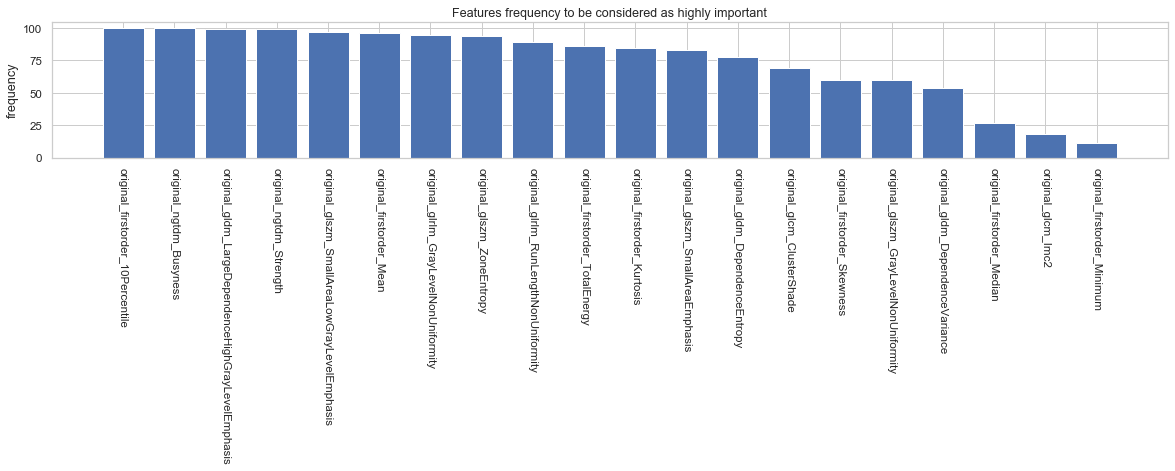

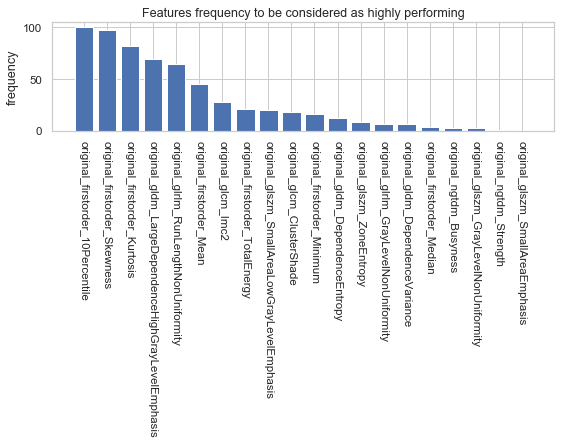

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


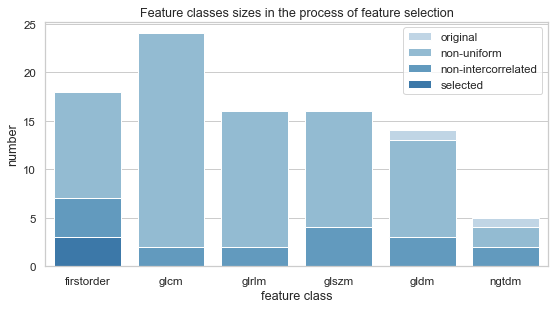

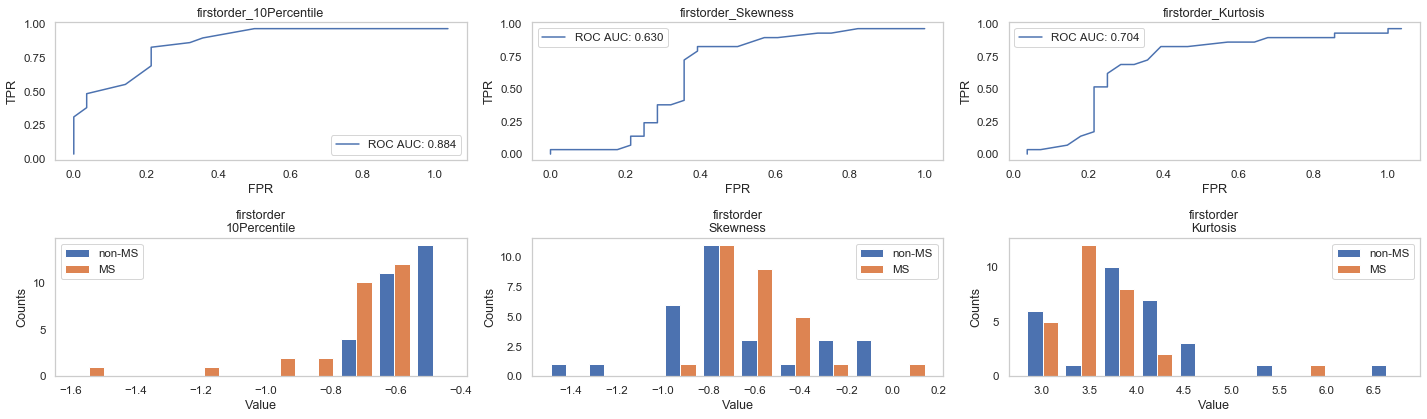

age_slope  age_corr  volume_corr  \
feature                                                            
T1w_GM_firstorder_10Percentile  -0.001164 -0.169790    -0.167438   
T1w_GM_firstorder_Skewness      -0.016943 -0.422921     0.132388   
T1w_GM_firstorder_Kurtosis       0.017565  0.171110    -0.248601   

                                outcome_corr  univar_auc  p_MW_corr  
feature                                                              
T1w_GM_firstorder_10Percentile     -0.541318    0.815201    0.00736  
T1w_GM_firstorder_Skewness          0.286030    0.639275    1.00000  
T1w_GM_firstorder_Kurtosis         -0.326127    0.690201    1.00000

In [30]:
features_to_model_T1_GM = featuresSelectionPipeline('../features/features_CRC_T1w_GM.csv', ds_names_train, 
                                                    100, 3, 'T1w', 'GM')

PD

original_glrlm_LowGrayLevelRunEmphasis  excluded
original_glrlm_ShortRunLowGrayLevelEmphasis  excluded
original_glszm_LowGrayLevelZoneEmphasis  excluded
original_gldm_LowGrayLevelEmphasis  excluded
Non uniform features:  ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency', 'original_glcm_Contrast

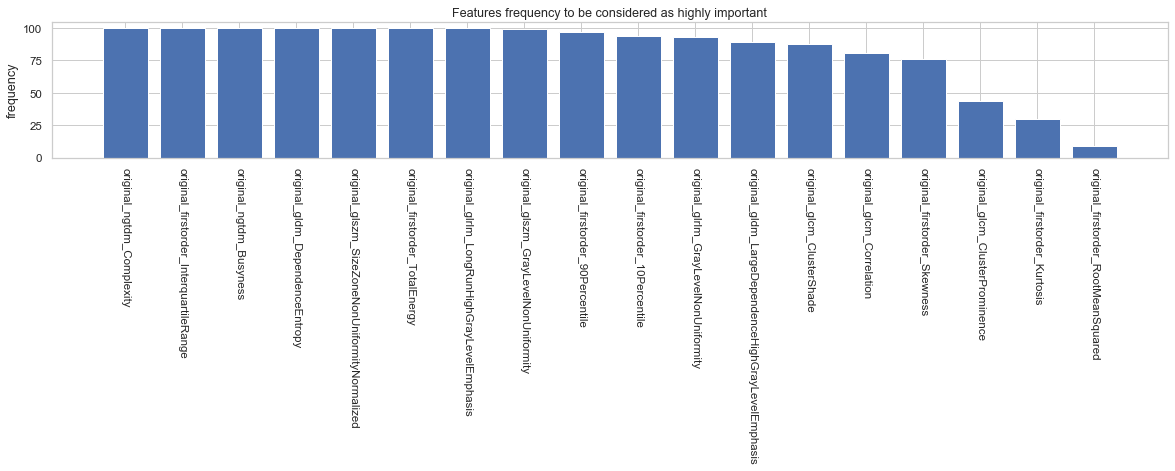

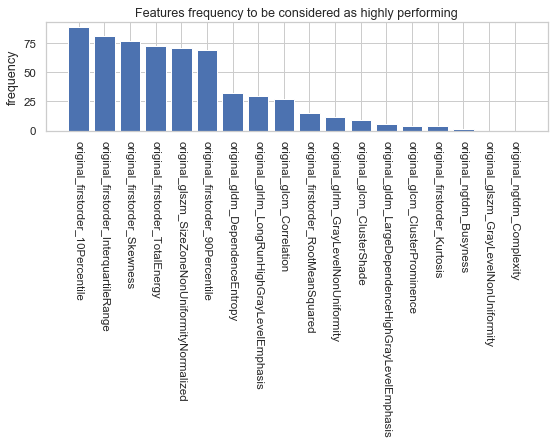

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


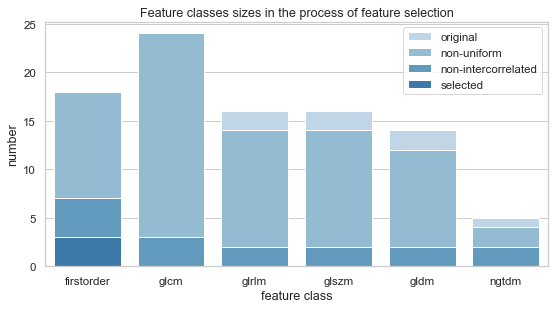

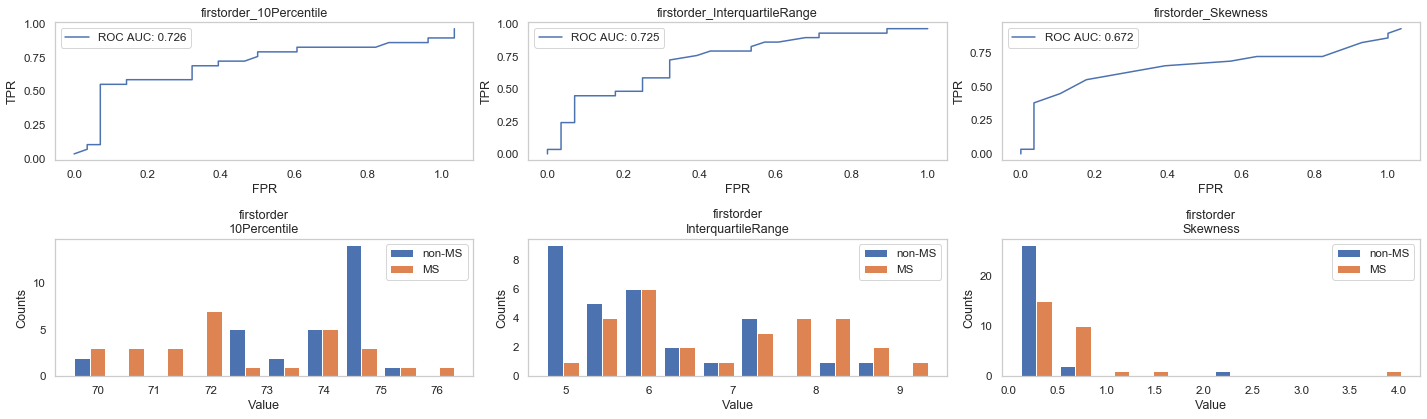

age_slope  age_corr  volume_corr  \
feature                                                                 
PD_GM_firstorder_10Percentile         0.024478 -0.093322    -0.096083   
PD_GM_firstorder_InterquartileRange  -0.026096  0.032970     0.333912   
PD_GM_firstorder_Skewness             0.005892  0.308172     0.023667   

                                     outcome_corr  univar_auc  p_MW_corr  
feature                                                                   
PD_GM_firstorder_10Percentile           -0.446420    0.758873   0.243290  
PD_GM_firstorder_InterquartileRange      0.453103    0.734182   0.194002  
PD_GM_firstorder_Skewness                0.327464    0.681327   1.000000

In [31]:
features_to_model_PD_GM = featuresSelectionPipeline('../features/features_CRC_PD_GM.csv', ds_names_train, 
                                                    100, 3, 'PD', 'GM')

MT

original_firstorder_Minimum  excluded
original_glcm_JointEnergy  excluded
Non uniform features:  ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency', 'original_glcm_Contrast', 'original_glcm_Correlation', 'original_glcm_DifferenceAverage', 'original_glcm_DifferenceEntropy', 'original_glcm_DifferenceVariance', 'original_glcm_Id

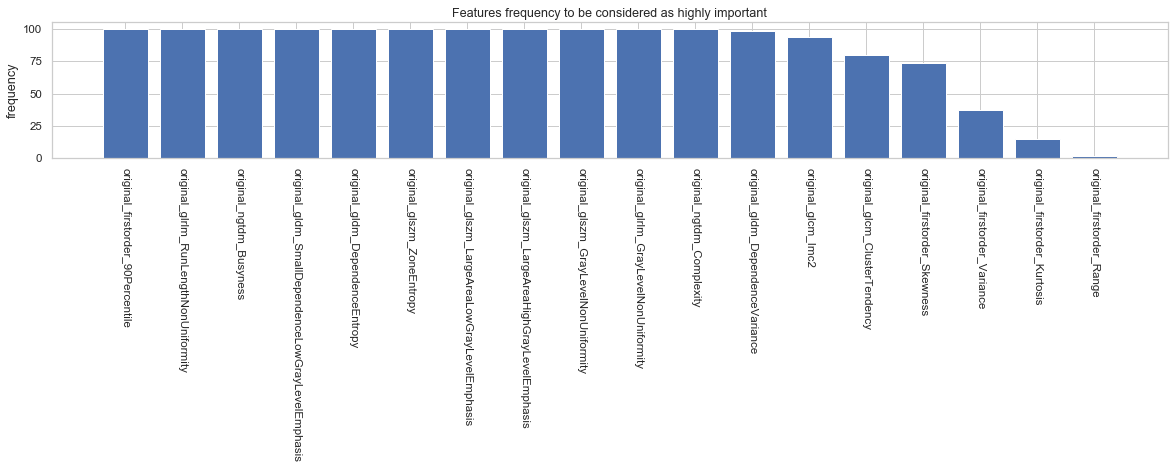

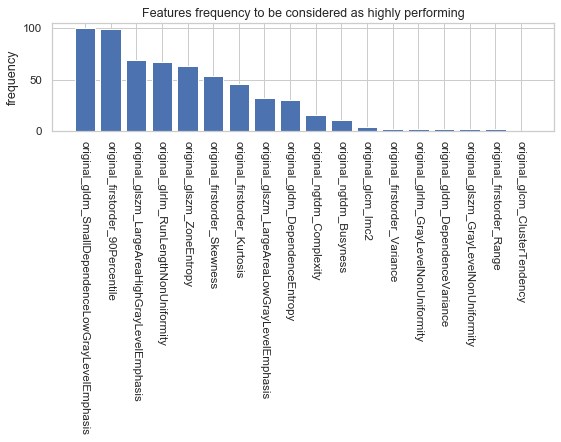

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


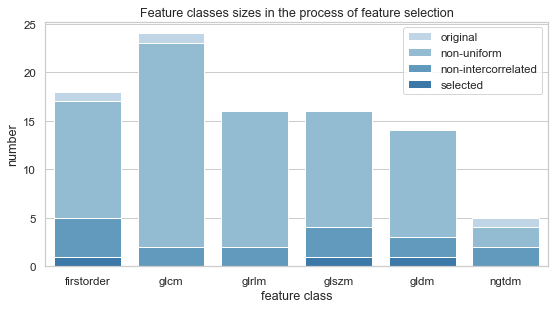

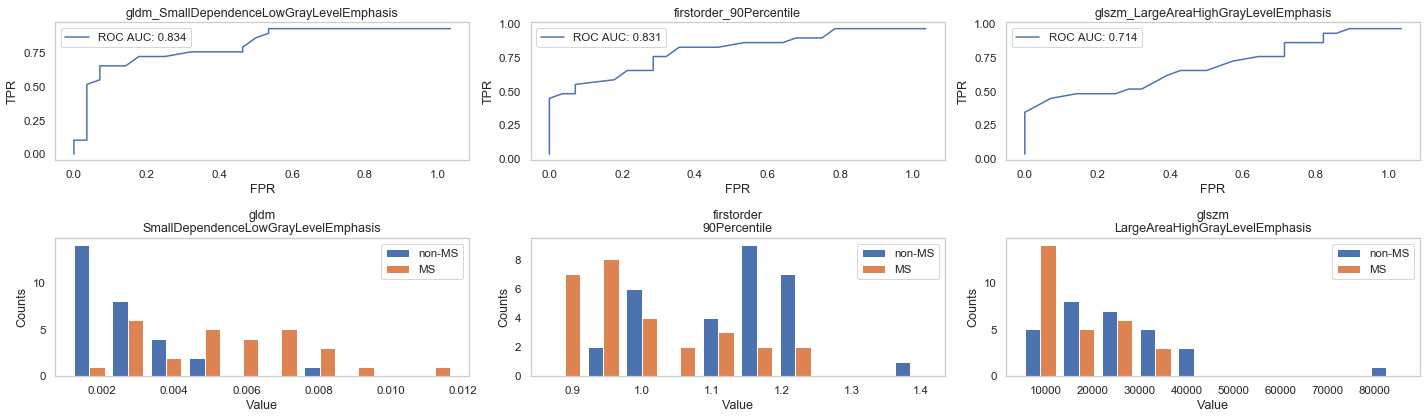

age_slope  age_corr  \
feature                                                                
MT_GM_gldm_SmallDependenceLowGrayLevelEmphasis    0.000012  0.215735   
MT_GM_firstorder_90Percentile                     0.003415  0.136869   
MT_GM_glszm_LargeAreaHighGrayLevelEmphasis     -226.036484 -0.209939   

                                                volume_corr  outcome_corr  \
feature                                                                     
MT_GM_gldm_SmallDependenceLowGrayLevelEmphasis     0.102997      0.602801   
MT_GM_firstorder_90Percentile                      0.070165     -0.577406   
MT_GM_glszm_LargeAreaHighGrayLevelEmphasis        -0.047334     -0.370235   

                                                univar_auc  p_MW_corr  
feature                                                                
MT_GM_gldm_SmallDependenceLowGrayLevelEmphasis    0.846451   0.000550  
MT_GM_firstorder_90Percentile                     0.832562   0.001657  
MT_GM_glszm_LargeAreaHighGrayLevelEmphasis        0.711420   1.000000

In [32]:
features_to_model_MT_GM = featuresSelectionPipeline('../features/features_CRC_MT_GM.csv', ds_names_train, 
                                                    100, 3, 'MT', 'GM')

R1

original_glcm_Idmn  excluded
original_glcm_MaximumProbability  excluded
original_glszm_SmallAreaLowGrayLevelEmphasis  excluded
Non uniform features:  ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency', 'original_glcm_Contrast', 'original_glcm_Correlation', 'original_glcm_DifferenceAverage', 'ori

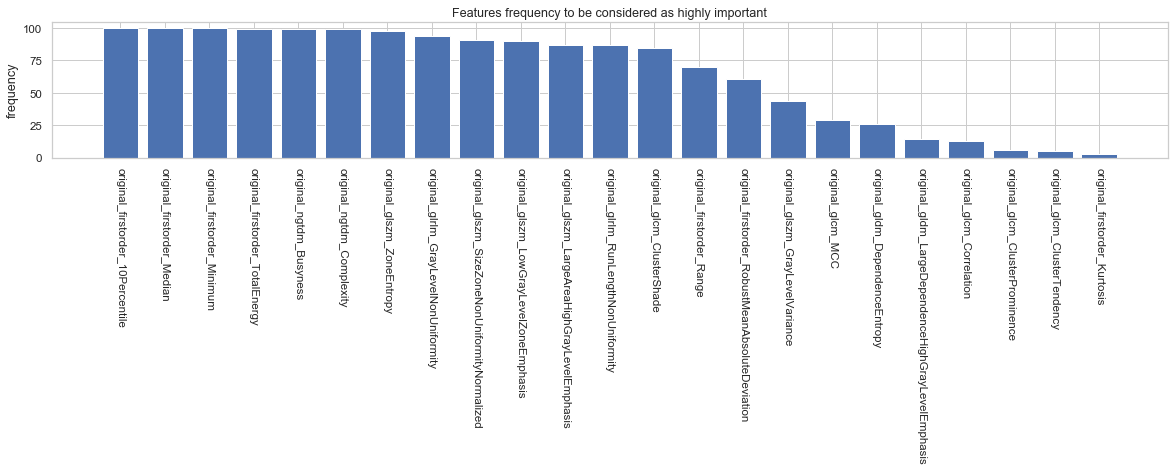

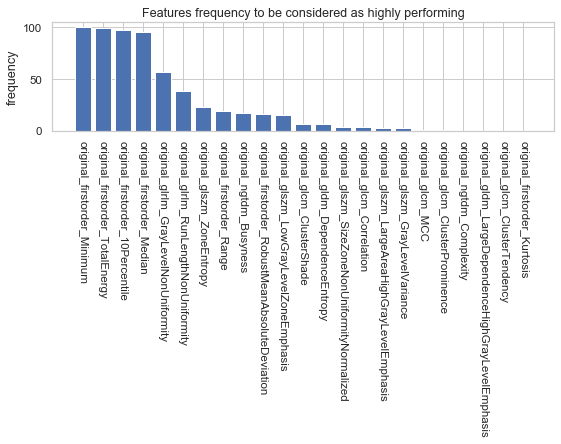

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


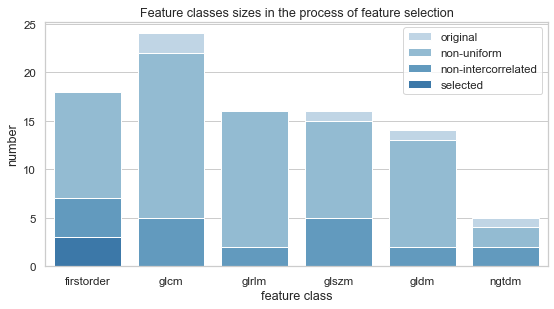

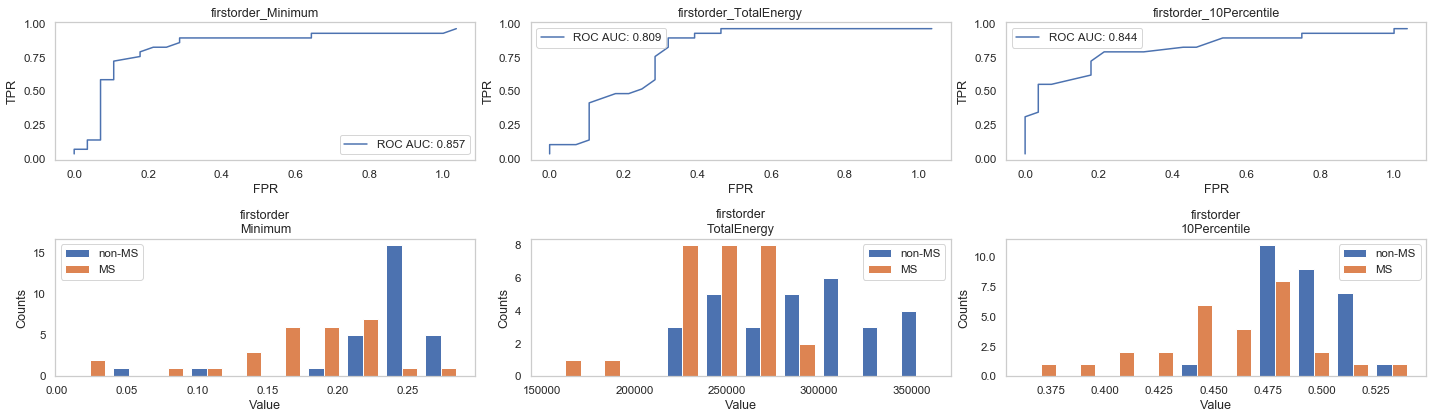

age_slope  age_corr  volume_corr  \
feature                                                             
R1_GM_firstorder_Minimum         -0.000330 -0.172366    -0.110071   
R1_GM_firstorder_TotalEnergy  -1360.534228 -0.295985     0.286256   
R1_GM_firstorder_10Percentile    -0.000871 -0.368380    -0.070197   

                               outcome_corr  univar_auc  p_MW_corr  
feature                                                             
R1_GM_firstorder_Minimum          -0.632206    0.866127   0.000145  
R1_GM_firstorder_TotalEnergy      -0.522606    0.800540   0.015399  
R1_GM_firstorder_10Percentile     -0.554684    0.817901   0.004281

In [33]:
features_to_model_R1_GM = featuresSelectionPipeline('../features/features_CRC_R1_GM.csv', ds_names_train, 
                                                    100, 3, 'R1', 'GM')

R2*

Non uniform features:  ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency', 'original_glcm_Contrast', 'original_glcm_Correlation', 'original_glcm_DifferenceAverage', 'original_glcm_DifferenceEntropy', 'original_glcm_DifferenceVariance', 'original_glcm_Id', 'original_glcm_Idm', 'original_glcm_Idmn

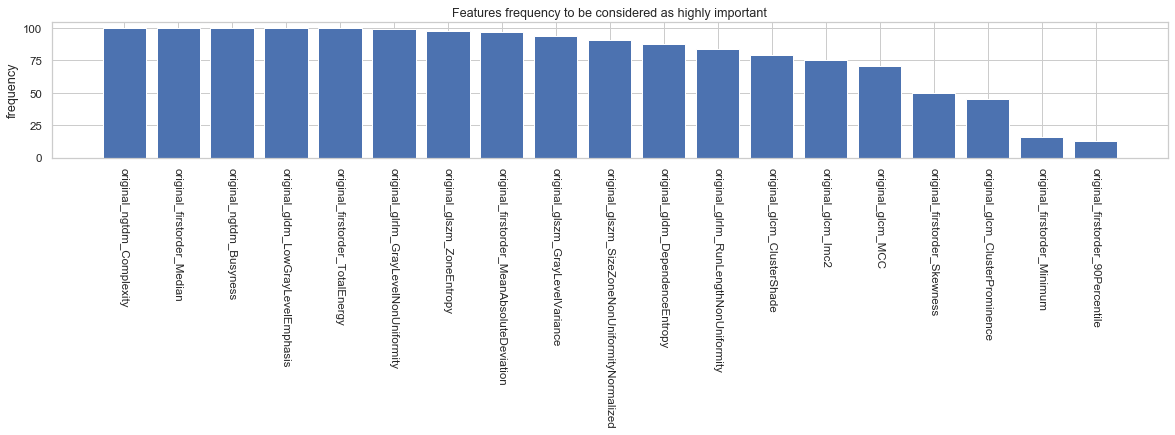

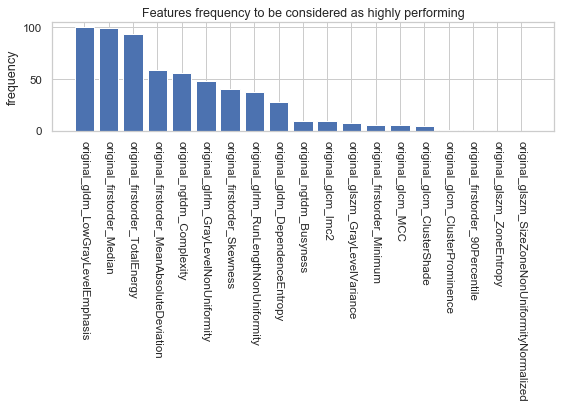

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


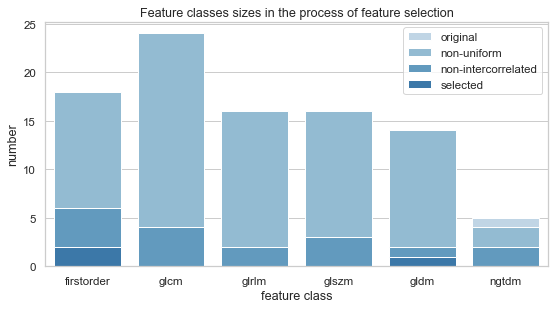

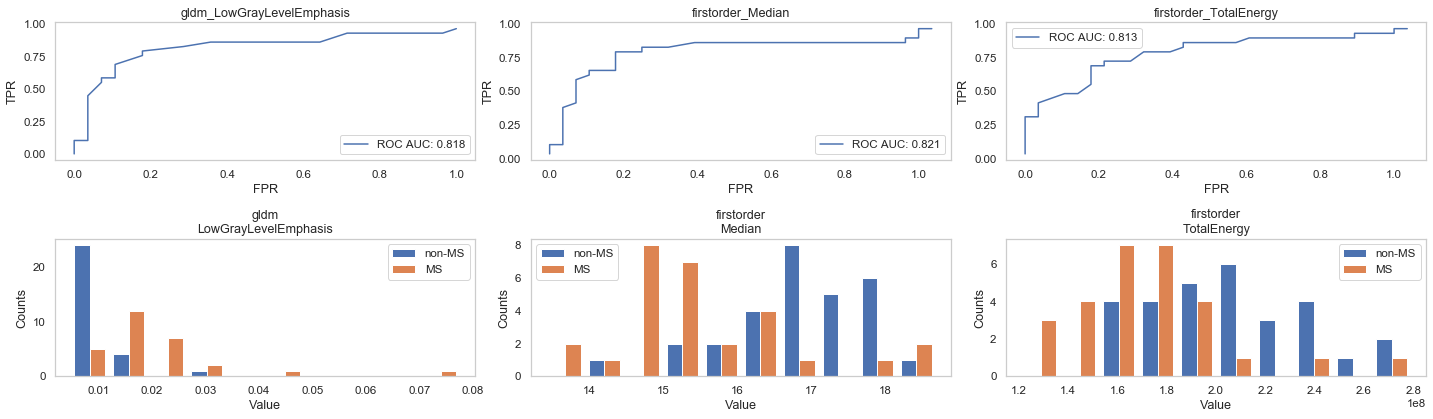

age_slope  age_corr  volume_corr  \
feature                                                                  
R2s_GM_gldm_LowGrayLevelEmphasis       0.000068  0.229096     0.104798   
R2s_GM_firstorder_Median               0.056348  0.374529     0.006946   
R2s_GM_firstorder_TotalEnergy     708932.327573  0.221643     0.249276   

                                  outcome_corr  univar_auc  p_MW_corr  
feature                                                                
R2s_GM_gldm_LowGrayLevelEmphasis      0.638889    0.836420   0.000106  
R2s_GM_firstorder_Median             -0.541318    0.810571   0.007360  
R2s_GM_firstorder_TotalEnergy        -0.505230    0.794367   0.029917

In [34]:
features_to_model_R2s_GM = featuresSelectionPipeline('../features/features_CRC_R2s_GM.csv', ds_names_train, 
                                                    100, 3, 'R2s', 'GM')

Combined qMRI = combined (PD + MT + R1 + R2*)

PD_glrlm_LowGrayLevelRunEmphasis  excluded
PD_glrlm_ShortRunLowGrayLevelEmphasis  excluded
PD_glszm_LowGrayLevelZoneEmphasis  excluded
PD_gldm_LowGrayLevelEmphasis  excluded
MT_firstorder_Minimum  excluded
MT_glcm_JointEnergy  excluded
R1_glcm_Idmn  excluded
R1_glcm_MaximumProbability  excluded
R1_glszm_SmallAreaLowGrayLevelEmphasis  excluded
Non uniform features:  ['PD_firstorder_10Percentile', 'PD_firstorder_90Percentile', 'PD_firstorder_Energy', 'PD_firstorder_Entropy', 'PD_firstorder_InterquartileRange', 'PD_firstorder_Kurtosis', 'PD_firstorder_Maximum', 'PD_firstorder_MeanAbsoluteDeviation', 'PD_firstorder_Mean', 'PD_firstorder_Median', 'PD_firstorder_Minimum', 'PD_firstorder_Range', 'PD_firstorder_RobustMeanAbsoluteDeviation', 'PD_firstorder_RootMeanSquared', 'PD_firstorder_Skewness', 'PD_firstorder_TotalEnergy', 'PD_firstorder_Uniformity', 'PD_firstorder_Variance', 'PD_glcm_Autocorrelation', 'PD_glcm_ClusterProminence', 'PD_glcm_ClusterShade', 'PD_glcm_ClusterTendency', 'PD_glcm

Non intercorrelated features:  ['PD_firstorder_10Percentile', 'PD_firstorder_90Percentile', 'PD_firstorder_InterquartileRange', 'PD_firstorder_Kurtosis', 'PD_firstorder_RootMeanSquared', 'PD_firstorder_Skewness', 'PD_firstorder_TotalEnergy', 'PD_glcm_ClusterProminence', 'PD_glcm_ClusterShade', 'PD_glcm_MCC', 'PD_glrlm_GrayLevelNonUniformity', 'PD_glrlm_LongRunHighGrayLevelEmphasis', 'PD_glszm_GrayLevelNonUniformity', 'PD_glszm_SizeZoneNonUniformityNormalized', 'PD_gldm_DependenceEntropy', 'PD_gldm_LargeDependenceHighGrayLevelEmphasis', 'PD_ngtdm_Busyness', 'MT_firstorder_Kurtosis', 'MT_firstorder_Range', 'MT_firstorder_Variance', 'MT_glcm_ClusterShade', 'MT_glcm_ClusterTendency', 'MT_glcm_Imc2', 'MT_glcm_MaximumProbability', 'MT_glrlm_GrayLevelNonUniformity', 'MT_glszm_GrayLevelNonUniformity', 'MT_glszm_LargeAreaHighGrayLevelEmphasis', 'MT_glszm_LargeAreaLowGrayLevelEmphasis', 'MT_glszm_ZoneEntropy', 'MT_gldm_DependenceEntropy', 'MT_gldm_SmallDependenceLowGrayLevelEmphasis', 'MT_ngtdm_

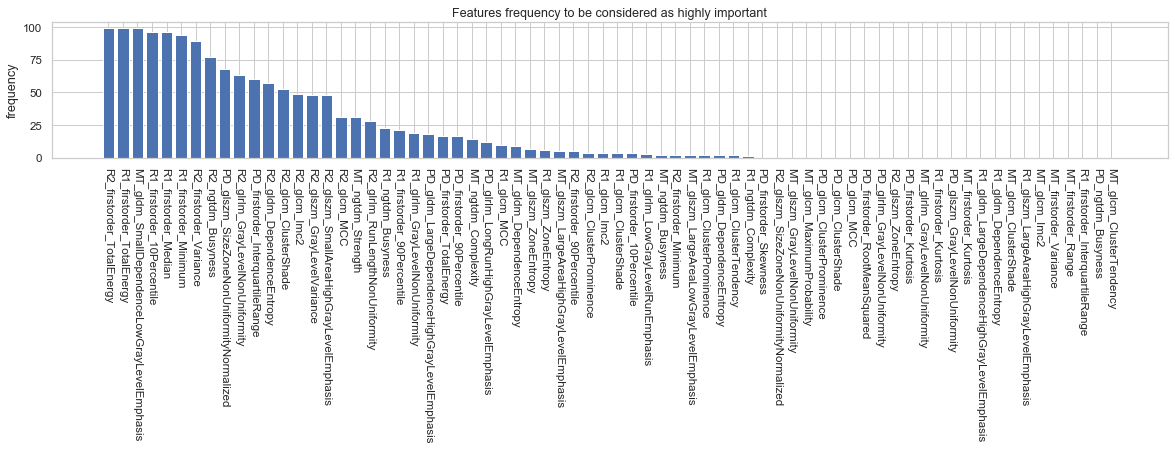

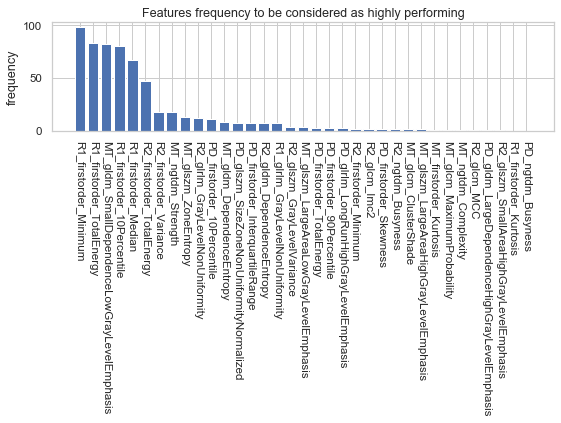

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


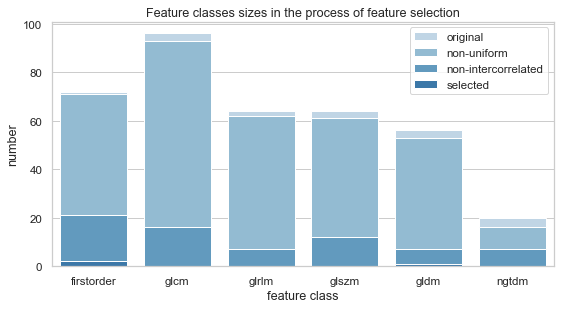

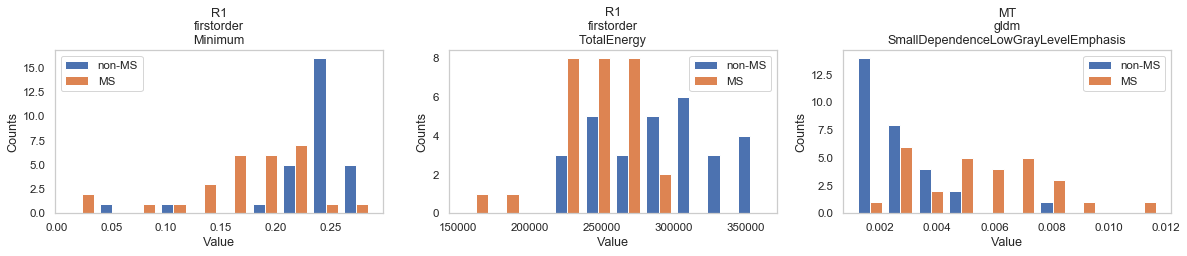

In [35]:
features_to_model_qMRI_GM = featuresSelectionPipeline('../features/features_CRC_qMRI_GM.csv', ds_names_train, 
                                                    100, 3, 'qMRI', 'GM')

# Visualization of the characteristics for the selected features

In [6]:
sns.set()
sns.set_style('whitegrid')
paper_rc = {'lines.linewidth': 1.5}                  
sns.set_context('paper', rc = paper_rc)
sns.set(font_scale = 1.05)

df_feat_analysis = pd.read_csv('../features_analysis/features_analysis.csv', index_col = 0)

In [7]:
def abbreviation(x):
    if len(x)>17:
        return (''.join([c for c in x if c.isupper()]))
    else:
        return (x)

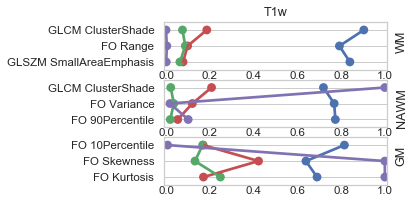

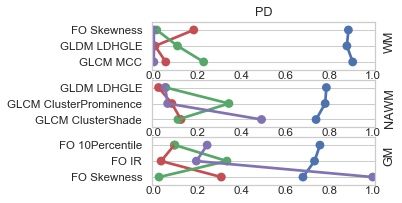

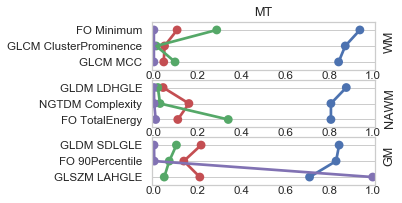

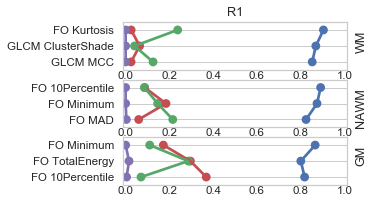

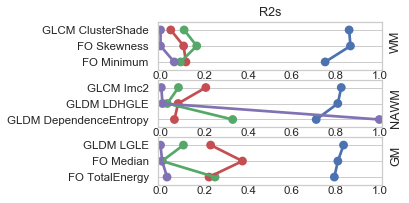

In [11]:
modality_names = ['T1w', 'PD', 'MT', 'R1', 'R2s']
roi_names = ['WM', 'NAWM', 'GM']

for modality_name in modality_names:
    i = 1
    plt.figure(figsize = (4, 3)) 

    for roi_name in roi_names:

        with open('../features_to_model/features_to_model_'+ modality_name + '_' + roi_name + '.txt', "r") as f:
            features_to_model=[i[:-1] for line in f for i in line.split('/n')]
        features_to_model_global = []
        for feature in features_to_model:
            feature_title = feature
            if 'original_' in feature_title:
                feature_title = feature_title.replace('original','')
            feature_title = modality_name + '_' + roi_name + feature_title
            features_to_model_global.append(feature_title)

        df = df_feat_analysis.reindex(features_to_model_global)
        df.drop(columns='age_slope', inplace = True)
        df.reset_index(level=0, inplace=True)
        df.age_corr = df.age_corr.abs()
        df.volume_corr = df.volume_corr.abs()
        df.outcome_corr = df.outcome_corr.abs()
        for f in df.feature:
            comp = f.split('_')
            comp[2] = comp[2].upper()
            if comp[2] == 'FIRSTORDER':
                comp[2] = 'FO'
            df.replace(f, comp[2]+' '+abbreviation(comp[3]), inplace = True)
        sns.set_style('whitegrid')
        plt.subplot(3,1,i)
        sns.pointplot(x="age_corr", y='feature',
                    data = df, color = 'r')
        sns.pointplot(x="volume_corr", y='feature',
                    data = df, color = 'g')
        sns.pointplot(x="univar_auc", y='feature',
                    data = df, color = 'b')
        sns.pointplot(x="p_MW_corr", y='feature',
                    data = df, color = 'm')
        plt.xlabel('')
        plt.ylabel('')
        plt.tick_params(axis = 'x', direction = 'in', pad = 0.75)
        plt.xlim(-0.01, 1.01)
        plt.grid()   
        plt.text(1.05, 0, roi_name, rotation=90, horizontalalignment='left', verticalalignment='top')
        if i==1:
            plt.title(modality_name)   
        i+=1

    plt.show()

# Features selection for permutation test

The same pipeline for features selection, but for randomized outcomes.

Randomization of the outcomes and saving to .csv file

In [ ]:
modality_names = ['T1w', 'PD', 'MT', 'R1', 'R2s']
roi_names = ['WM', 'NAWM', 'GM']

for modality_name in modality_names:
    for roi_name in roi_names:
        filename = '../features/features_CRC_' + modality_name + '_' + roi_name + '.csv'
        df = pd.read_csv(filename, index_col = 0)
        ds_train = ds_train.reindex(sub_names)
        features = ds_train.columns[14:-1]

        outc_rand = np.ones(len(ds_train))
        outc_rand[:int(len(ds_train)/2)] = 0
        np.random.shuffle(outc_rand)

        ds_train['outcome'] = outc_rand
        ds_train.to_csv(filename[:-4] + '_rand.csv')

Features selection

original_glrlm_LongRunLowGrayLevelEmphasis  excluded
original_glrlm_LowGrayLevelRunEmphasis  excluded
original_glrlm_ShortRunLowGrayLevelEmphasis  excluded
original_glszm_LowGrayLevelZoneEmphasis  excluded
original_glszm_SmallAreaLowGrayLevelEmphasis  excluded
original_gldm_LowGrayLevelEmphasis  excluded
Non uniform features:  ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glc

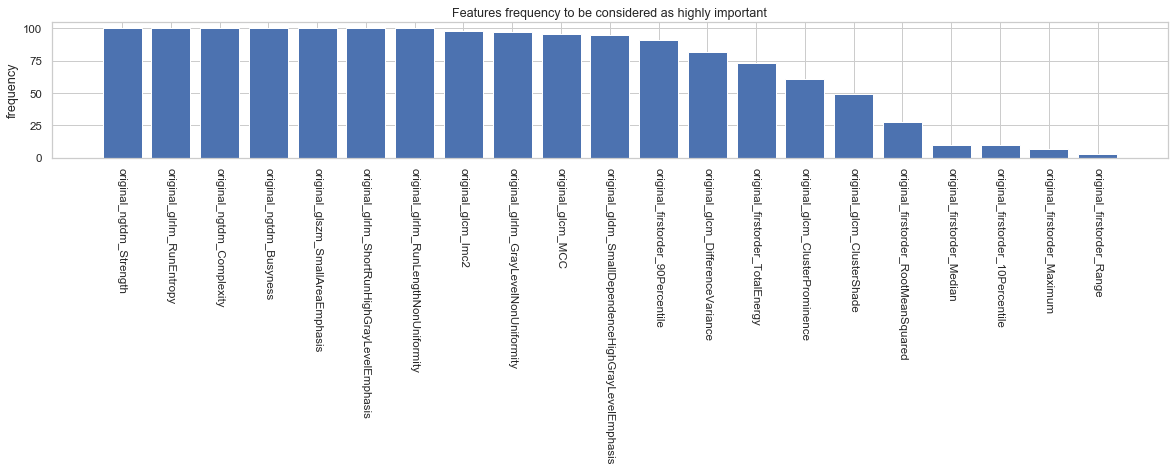

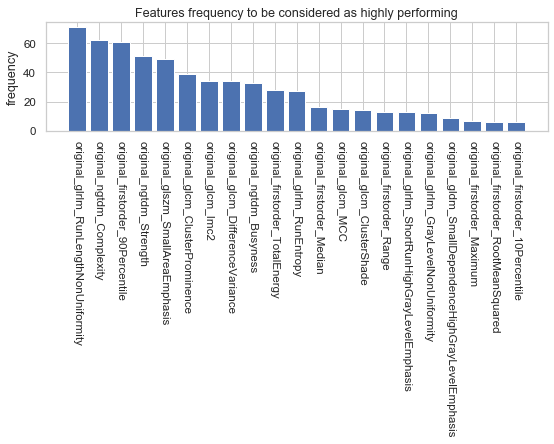

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


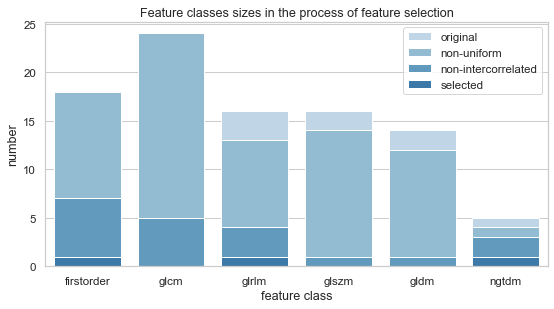

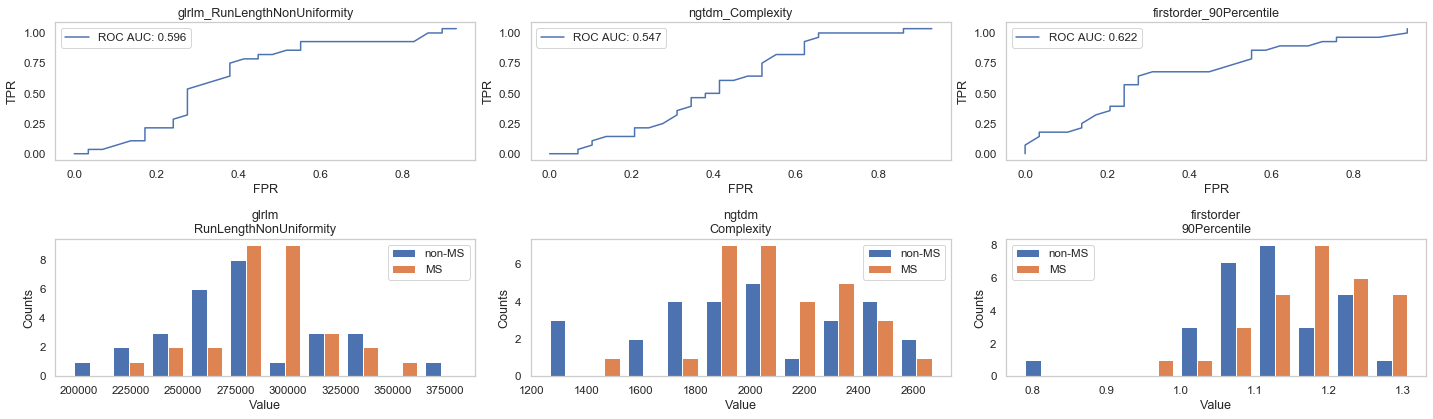

age_slope  age_corr  volume_corr  \
feature                                                                  
T1w_WM_glrlm_RunLengthNonUniformity -683.777418 -0.009498     0.724259   
T1w_WM_ngtdm_Complexity               -4.162980 -0.163351    -0.155251   
T1w_WM_firstorder_90Percentile        -0.000740  0.046991    -0.020291   

                                     outcome_corr  univar_auc  p_MW_corr  
feature                                                                   
T1w_WM_glrlm_RunLengthNonUniformity      0.151034    0.589120   1.000000  
T1w_WM_ngtdm_Complexity                  0.033415    0.518904   1.000000  
T1w_WM_firstorder_90Percentile           0.439737    0.755787   0.304184

In [37]:
features_to_model_T1_WM_rand = featuresSelectionPipeline('../features/features_CRC_T1w_WM_rand.csv', ds_names_train, 
                                                         100, 3, 'T1w', 'WM')

original_glszm_SmallAreaLowGrayLevelEmphasis  excluded
Non uniform features:  ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency', 'original_glcm_Contrast', 'original_glcm_Correlation', 'original_glcm_DifferenceAverage', 'original_glcm_DifferenceEntropy', 'original_glcm_DifferenceVariance', 'orig

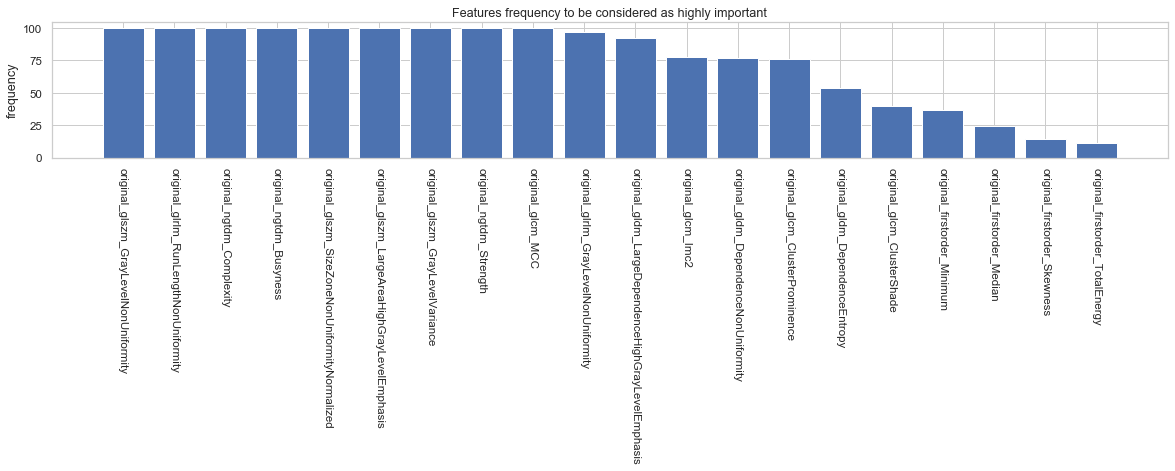

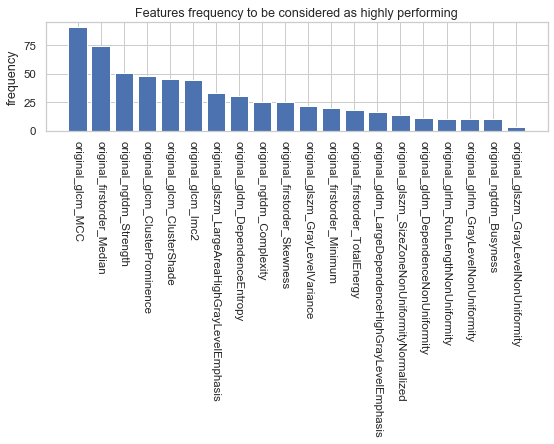

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


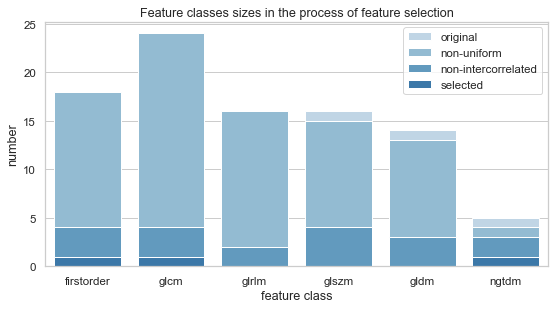

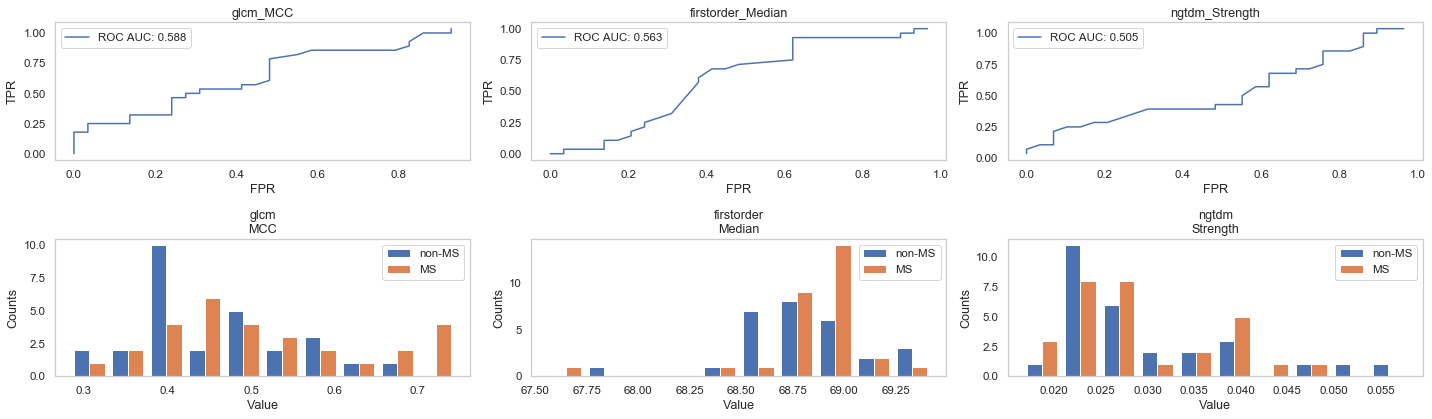

age_slope  age_corr  volume_corr  outcome_corr  \
feature                                                                   
PD_WM_glcm_MCC           -0.000964 -0.054364     0.227539      0.757845   
PD_WM_firstorder_Median   0.007843  0.245340    -0.062287      0.503894   
PD_WM_ngtdm_Strength      0.000057  0.123265    -0.175960      0.712401   

                         univar_auc     p_MW_corr  
feature                                            
PD_WM_glcm_MCC             0.908565  2.493751e-07  
PD_WM_firstorder_Median    0.759645  3.145859e-02  
PD_WM_ngtdm_Strength       0.882330  2.829086e-06

In [38]:
features_to_model_PD_WM_rand = featuresSelectionPipeline('../features/features_CRC_PD_WM_rand.csv', ds_names_train, 
                                                         100, 3, 'PD', 'WM')

original_glrlm_LowGrayLevelRunEmphasis  excluded
original_glszm_LowGrayLevelZoneEmphasis  excluded
original_gldm_LowGrayLevelEmphasis  excluded
Non uniform features:  ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency', 'original_glcm_Contrast', 'original_glcm_Correlation', 'original_glcm_Differe

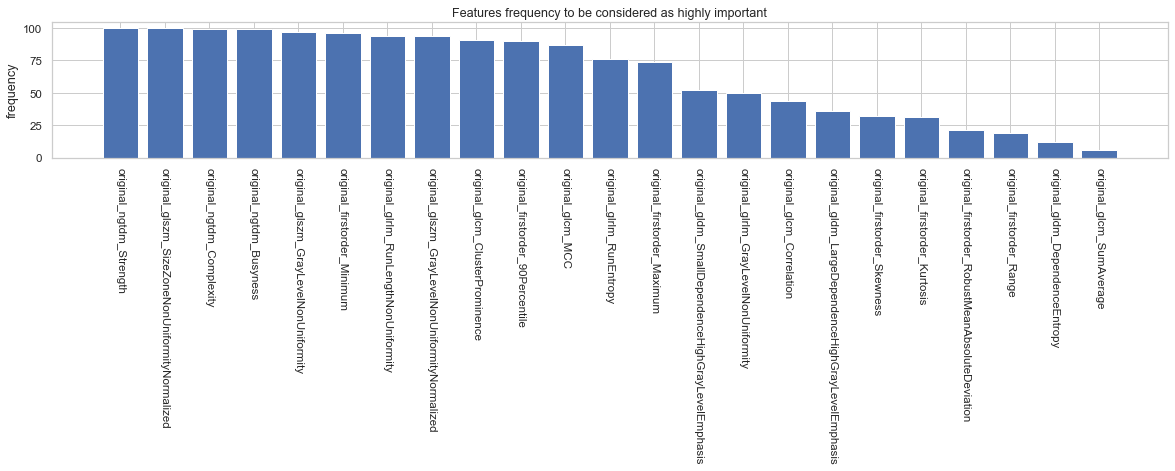

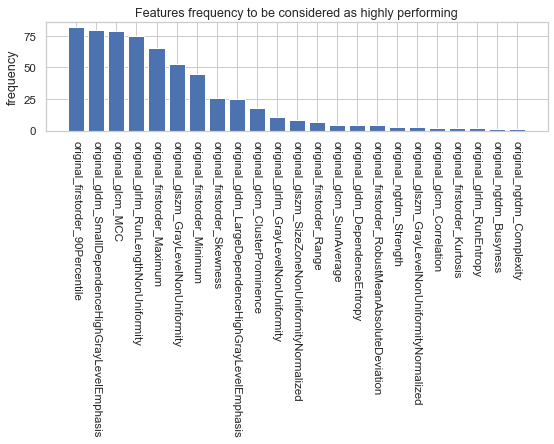

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


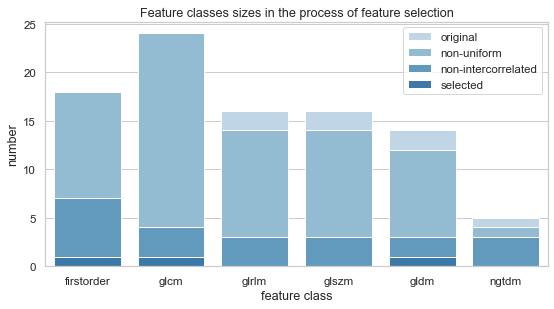

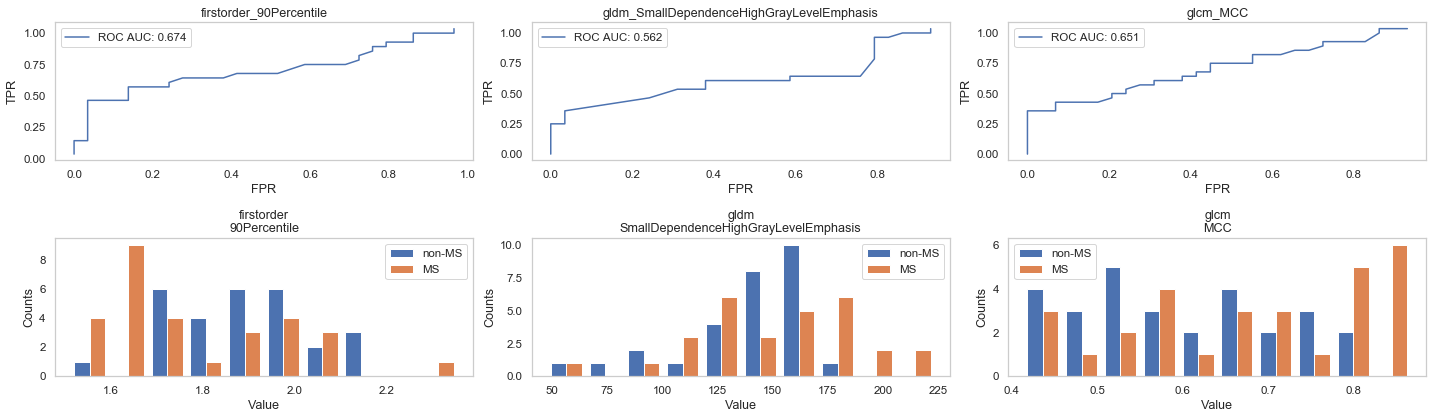

age_slope  age_corr  \
feature                                                                
MT_WM_firstorder_90Percentile                     0.003928  0.115909   
MT_WM_gldm_SmallDependenceHighGrayLevelEmphasis  -0.133467 -0.184504   
MT_WM_glcm_MCC                                   -0.000139  0.045108   

                                                 volume_corr  outcome_corr  \
feature                                                                      
MT_WM_firstorder_90Percentile                       0.070680     -0.558694   
MT_WM_gldm_SmallDependenceHighGrayLevelEmphasis    -0.066467      0.269991   
MT_WM_glcm_MCC                                      0.096662      0.642899   

                                                 univar_auc  p_MW_corr  
feature                                                                 
MT_WM_firstorder_90Percentile                      0.823302   0.003630  
MT_WM_gldm_SmallDependenceHighGrayLevelEmphasis    0.624228   1.000000  
MT_WM_glcm_MCC                                     0.844136   0.000088

In [39]:
features_to_model_MT_WM_rand = featuresSelectionPipeline('../features/features_CRC_MT_WM_rand.csv', ds_names_train, 
                                                         100, 3, 'MT', 'WM')

original_glrlm_LongRunLowGrayLevelEmphasis  excluded
original_glrlm_LowGrayLevelRunEmphasis  excluded
original_glrlm_ShortRunLowGrayLevelEmphasis  excluded
original_glszm_LowGrayLevelZoneEmphasis  excluded
original_glszm_SmallAreaLowGrayLevelEmphasis  excluded
original_gldm_LowGrayLevelEmphasis  excluded
Non uniform features:  ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glc

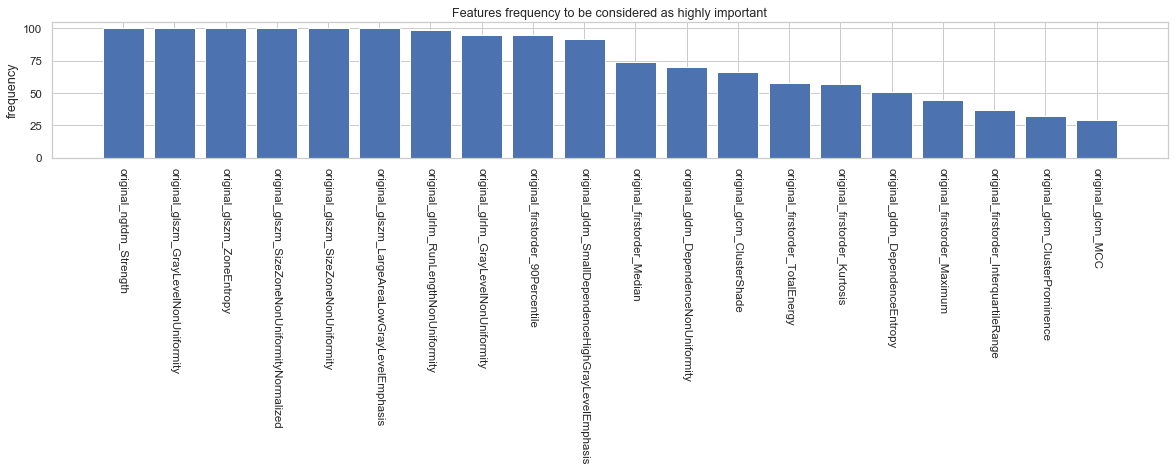

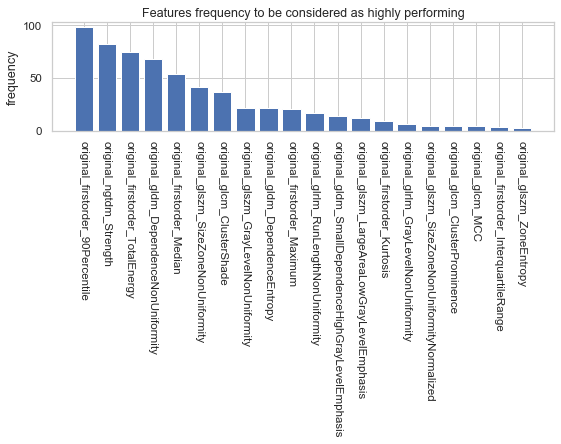

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


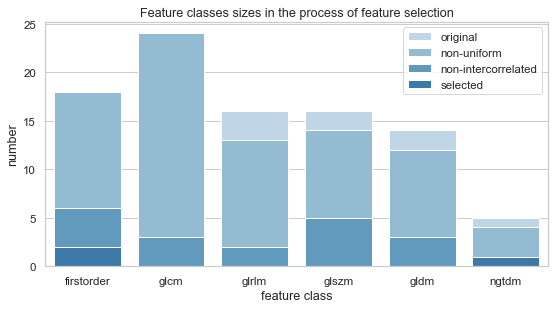

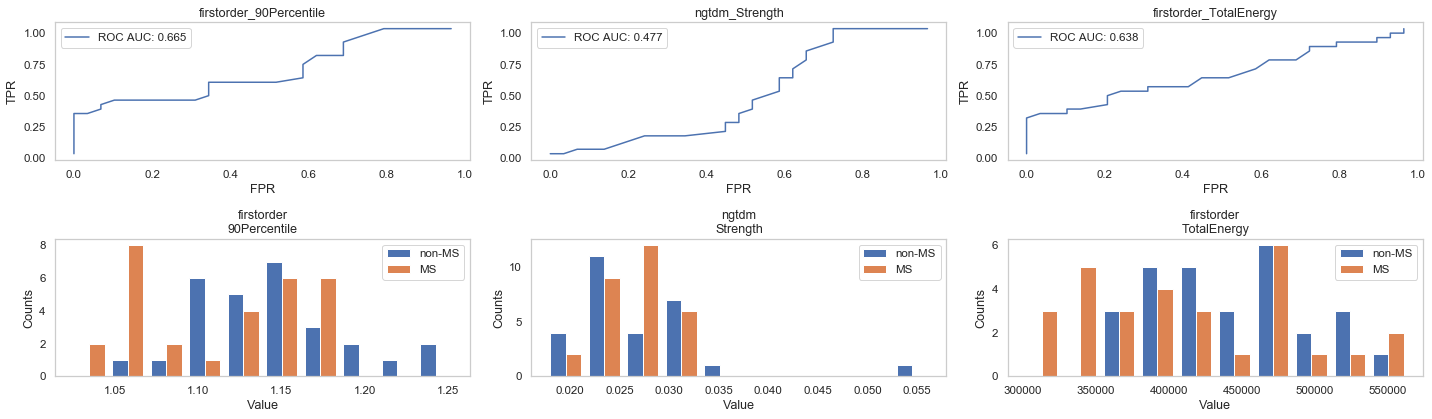

age_slope  age_corr  volume_corr  \
feature                                                            
R1_WM_firstorder_90Percentile   -0.000586 -0.104946     0.236896   
R1_WM_ngtdm_Strength            -0.000056  0.050469    -0.276577   
R1_WM_firstorder_TotalEnergy  -336.111419 -0.016163     0.705930   

                               outcome_corr  univar_auc  p_MW_corr  
feature                                                             
R1_WM_firstorder_90Percentile     -0.343503    0.697917        1.0  
R1_WM_ngtdm_Strength               0.344840    0.670139        1.0  
R1_WM_firstorder_TotalEnergy      -0.284693    0.665123        1.0

In [40]:
features_to_model_R1_WM_rand = featuresSelectionPipeline('../features/features_CRC_R1_WM_rand.csv', ds_names_train, 
                                                         100, 3, 'R1', 'WM')

original_glszm_SmallAreaLowGrayLevelEmphasis  excluded
Non uniform features:  ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency', 'original_glcm_Contrast', 'original_glcm_Correlation', 'original_glcm_DifferenceAverage', 'original_glcm_DifferenceEntropy', 'original_glcm_DifferenceVariance', 'orig

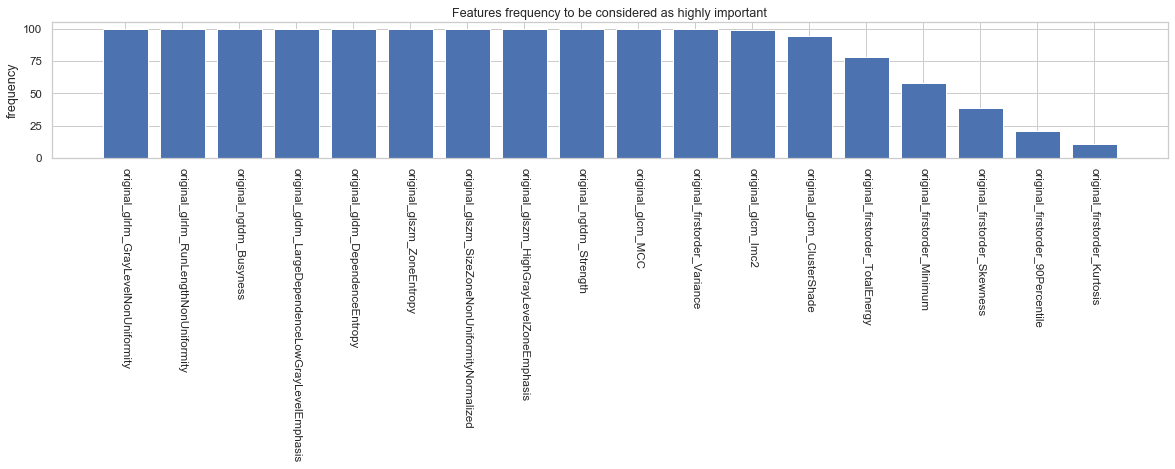

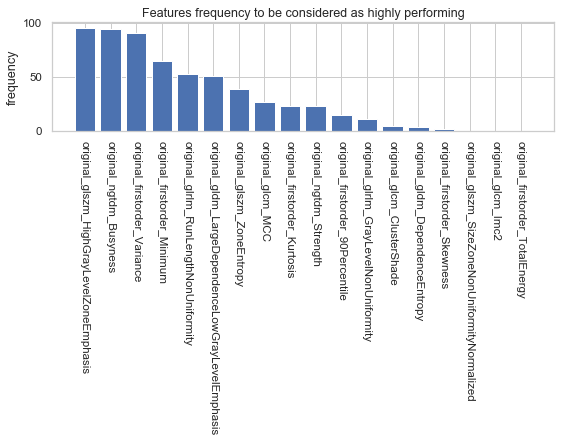

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


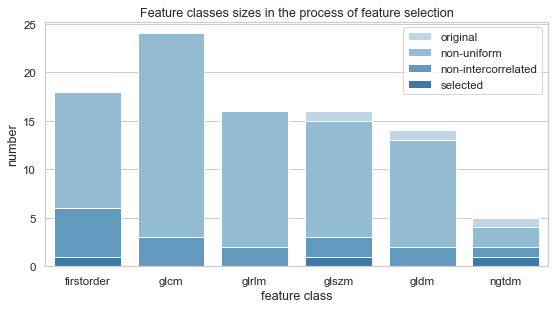

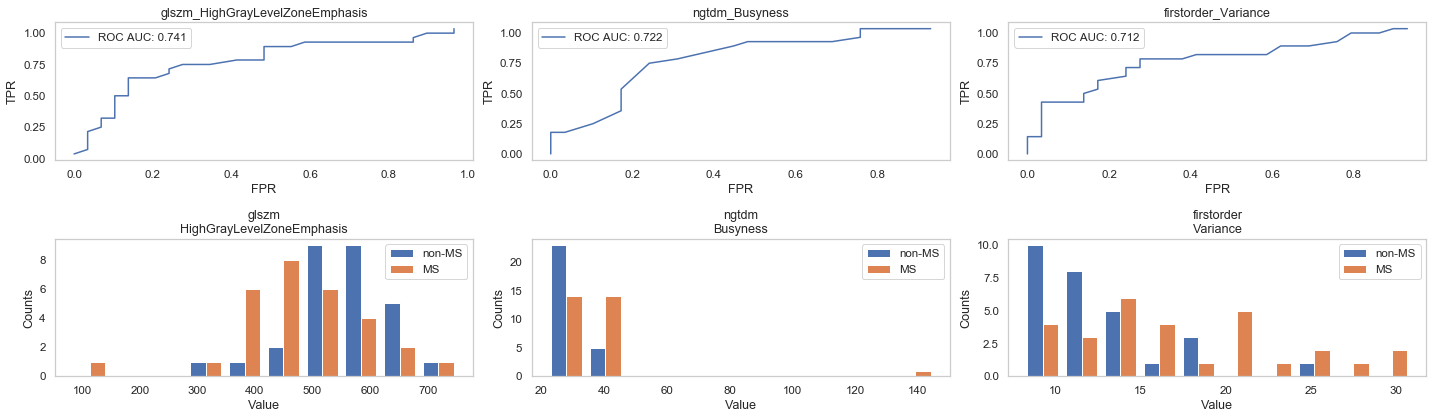

age_slope  age_corr  volume_corr  \
feature                                                                    
R2s_WM_glszm_HighGrayLevelZoneEmphasis  -0.413510 -0.138591    -0.030549   
R2s_WM_ngtdm_Busyness                   -0.088968  0.056232     0.511769   
R2s_WM_firstorder_Variance              -0.068395  0.089411     0.219596   

                                        outcome_corr  univar_auc  p_MW_corr  
feature                                                                      
R2s_WM_glszm_HighGrayLevelZoneEmphasis     -0.265981    0.653935   1.000000  
R2s_WM_ngtdm_Busyness                       0.477162    0.746142   0.083757  
R2s_WM_firstorder_Variance                  0.398303    0.705633   1.000000

In [41]:
features_to_model_R2s_WM_rand = featuresSelectionPipeline('../features/features_CRC_R2s_WM_rand.csv', ds_names_train, 
                                                         100, 3, 'R2s', 'WM')

PD_glszm_SmallAreaLowGrayLevelEmphasis  excluded
MT_glrlm_LowGrayLevelRunEmphasis  excluded
MT_glszm_LowGrayLevelZoneEmphasis  excluded
MT_gldm_LowGrayLevelEmphasis  excluded
R1_glrlm_LongRunLowGrayLevelEmphasis  excluded
R1_glrlm_LowGrayLevelRunEmphasis  excluded
R1_glrlm_ShortRunLowGrayLevelEmphasis  excluded
R1_glszm_LowGrayLevelZoneEmphasis  excluded
R1_glszm_SmallAreaLowGrayLevelEmphasis  excluded
R1_gldm_LowGrayLevelEmphasis  excluded
R2_glszm_SmallAreaLowGrayLevelEmphasis  excluded
Non uniform features:  ['PD_firstorder_10Percentile', 'PD_firstorder_90Percentile', 'PD_firstorder_Energy', 'PD_firstorder_Entropy', 'PD_firstorder_InterquartileRange', 'PD_firstorder_Kurtosis', 'PD_firstorder_Maximum', 'PD_firstorder_MeanAbsoluteDeviation', 'PD_firstorder_Mean', 'PD_firstorder_Median', 'PD_firstorder_Minimum', 'PD_firstorder_Range', 'PD_firstorder_RobustMeanAbsoluteDeviation', 'PD_firstorder_RootMeanSquared', 'PD_firstorder_Skewness', 'PD_firstorder_TotalEnergy', 'PD_firstorder_Unifo

Non intercorrelated features:  ['PD_firstorder_Median', 'PD_firstorder_Minimum', 'PD_glcm_ClusterProminence', 'PD_glcm_ClusterShade', 'PD_glcm_Imc2', 'PD_glcm_MCC', 'PD_glrlm_GrayLevelNonUniformity', 'PD_glszm_GrayLevelNonUniformity', 'PD_glszm_GrayLevelVariance', 'PD_glszm_SmallAreaEmphasis', 'PD_gldm_DependenceEntropy', 'PD_gldm_DependenceNonUniformity', 'PD_gldm_LargeDependenceHighGrayLevelEmphasis', 'PD_ngtdm_Busyness', 'PD_ngtdm_Complexity', 'MT_firstorder_Kurtosis', 'MT_firstorder_Maximum', 'MT_firstorder_Minimum', 'MT_firstorder_Range', 'MT_firstorder_RobustMeanAbsoluteDeviation', 'MT_firstorder_Skewness', 'MT_firstorder_TotalEnergy', 'MT_glcm_MCC', 'MT_glrlm_GrayLevelNonUniformity', 'MT_glrlm_RunEntropy', 'MT_glszm_GrayLevelNonUniformity', 'MT_glszm_GrayLevelNonUniformityNormalized', 'MT_glszm_HighGrayLevelZoneEmphasis', 'MT_glszm_SizeZoneNonUniformity', 'MT_glszm_SizeZoneNonUniformityNormalized', 'MT_gldm_DependenceEntropy', 'MT_gldm_LargeDependenceHighGrayLevelEmphasis', 'MT_

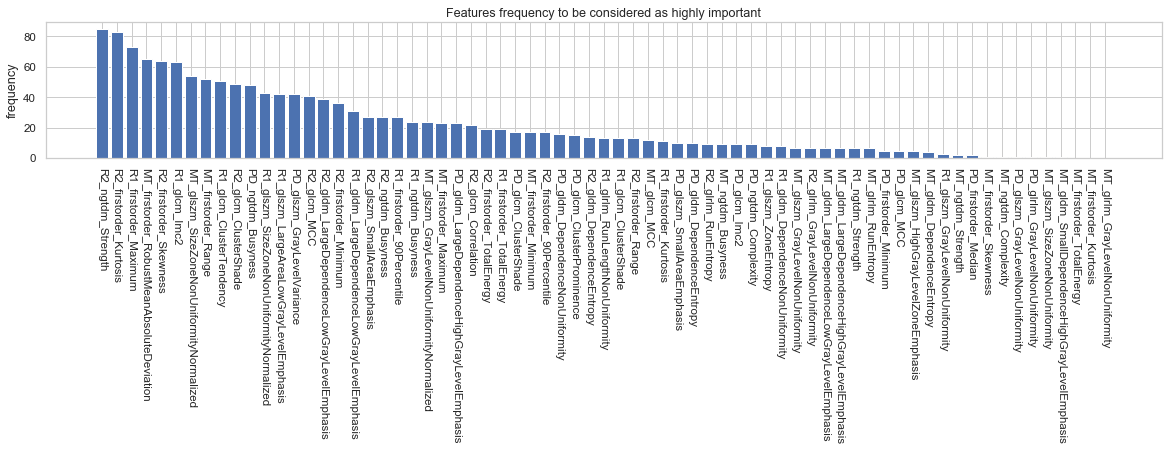

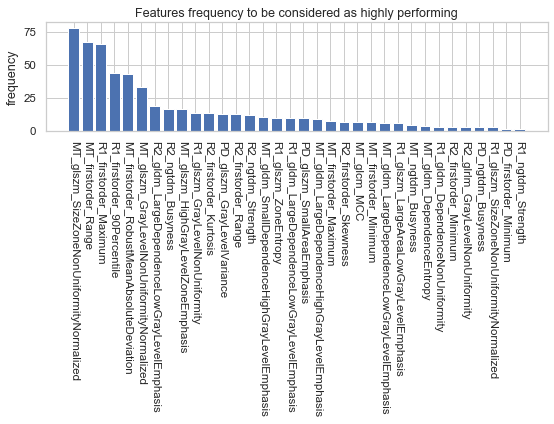

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


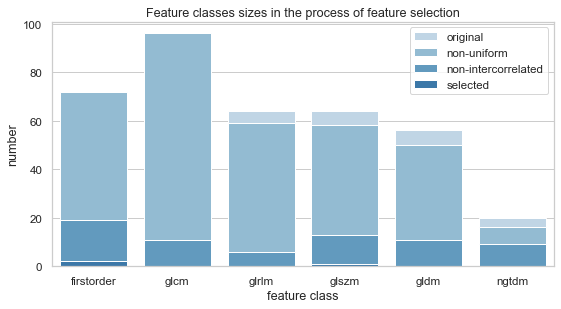

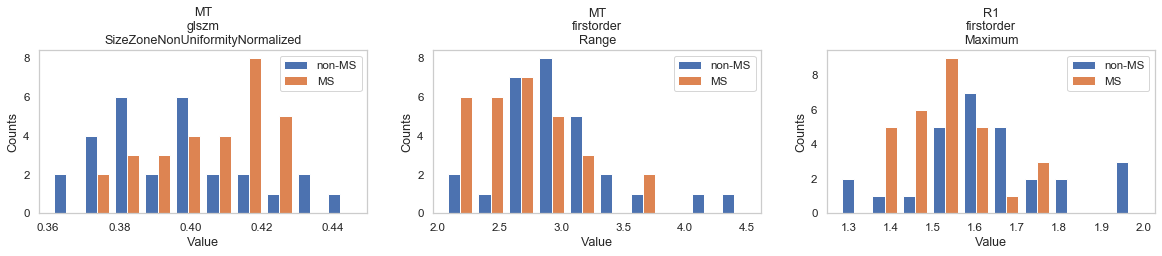

In [42]:
features_to_model_qMRI_WM_rand = featuresSelectionPipeline('../features/features_CRC_qMRI_WM_rand.csv', ds_names_train, 
                                                         100, 3, 'qMRI', 'WM')

original_glrlm_LongRunLowGrayLevelEmphasis  excluded
original_glrlm_LowGrayLevelRunEmphasis  excluded
original_glrlm_ShortRunLowGrayLevelEmphasis  excluded
original_glszm_LowGrayLevelZoneEmphasis  excluded
original_glszm_SmallAreaLowGrayLevelEmphasis  excluded
original_gldm_LowGrayLevelEmphasis  excluded
Non uniform features:  ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glc

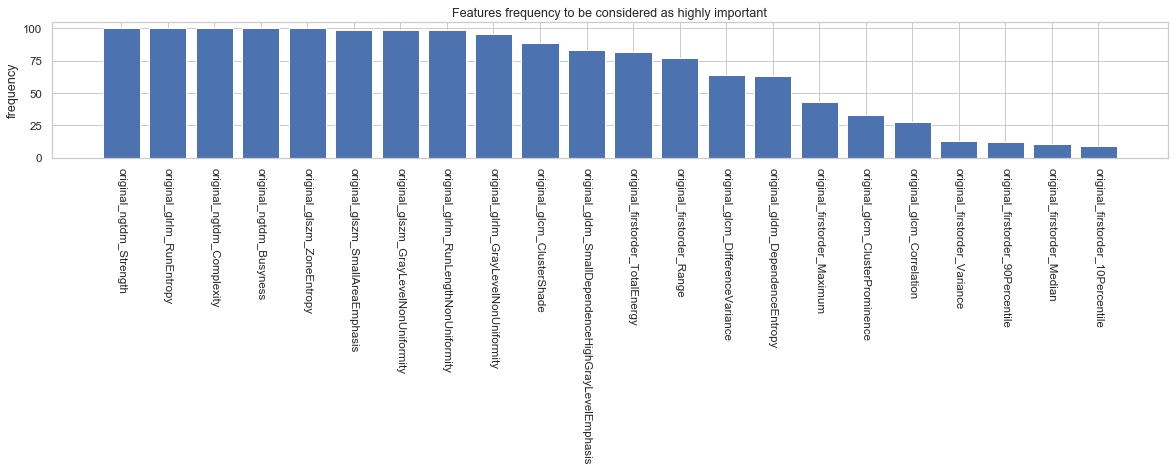

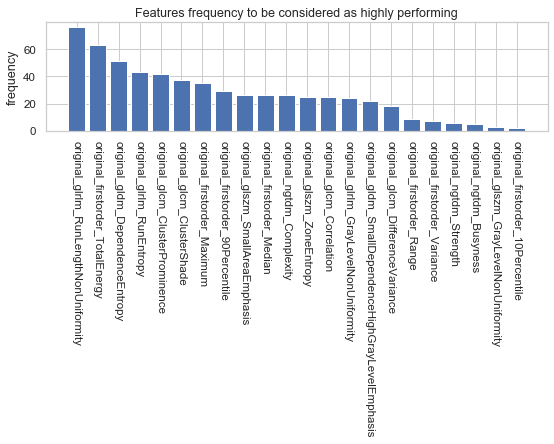

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


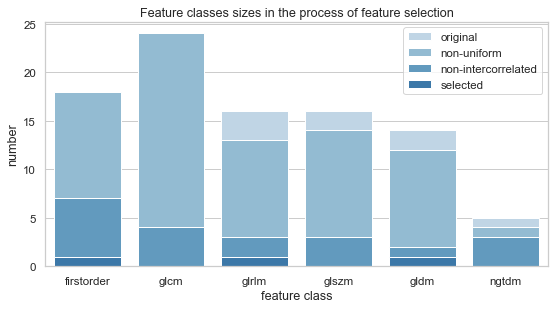

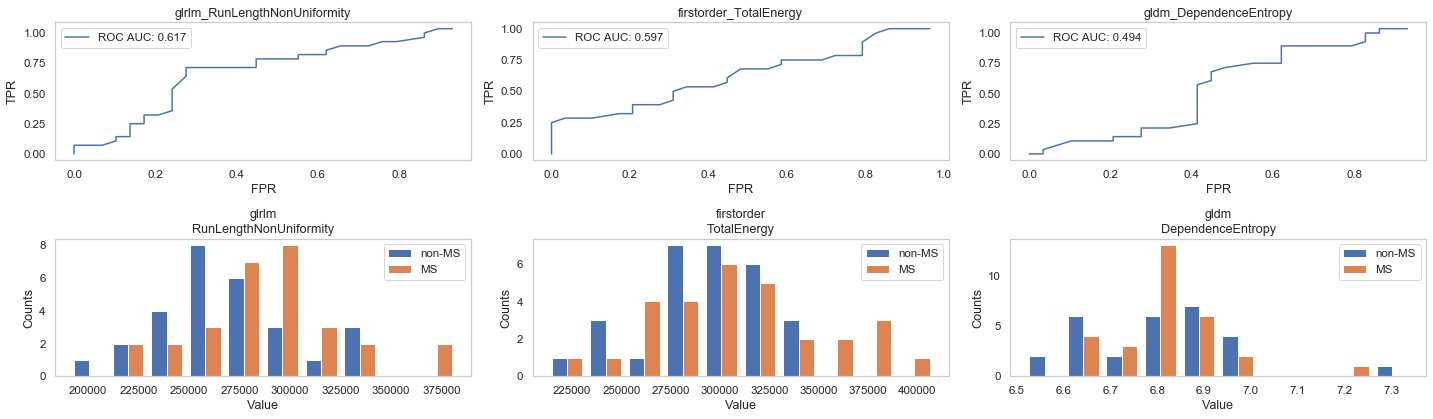

age_slope  age_corr  volume_corr  \
feature                                                                    
T1w_NAWM_glrlm_RunLengthNonUniformity -683.777418 -0.045945     0.753071   
T1w_NAWM_firstorder_TotalEnergy        468.436450  0.265688     0.650460   
T1w_NAWM_gldm_DependenceEntropy         -0.001409 -0.196352     0.143932   

                                       outcome_corr  univar_auc  p_MW_corr  
feature                                                                     
T1w_NAWM_glrlm_RunLengthNonUniformity     -0.014702    0.508102        1.0  
T1w_NAWM_firstorder_TotalEnergy            0.280683    0.635031        1.0  
T1w_NAWM_gldm_DependenceEntropy           -0.324791    0.689043        1.0

In [43]:
features_to_model_T1_NAWM_rand = featuresSelectionPipeline('../features/features_CRC_T1w_NAWM_rand.csv', ds_names_train, 
                                                         100, 3, 'T1w', 'NAWM')

original_glrlm_LongRunLowGrayLevelEmphasis  excluded
original_glrlm_LowGrayLevelRunEmphasis  excluded
original_glrlm_ShortRunLowGrayLevelEmphasis  excluded
original_glszm_LowGrayLevelZoneEmphasis  excluded
original_glszm_SmallAreaLowGrayLevelEmphasis  excluded
original_gldm_LowGrayLevelEmphasis  excluded
Non uniform features:  ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glc

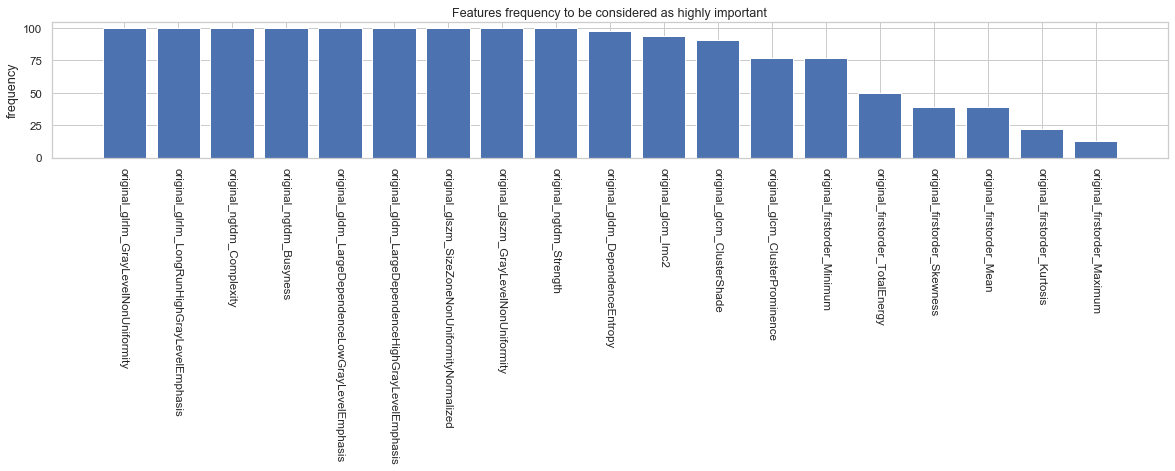

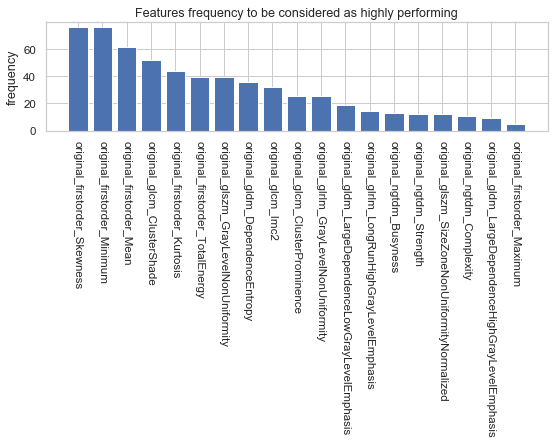

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


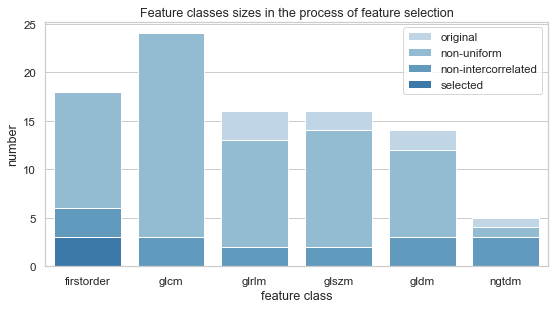

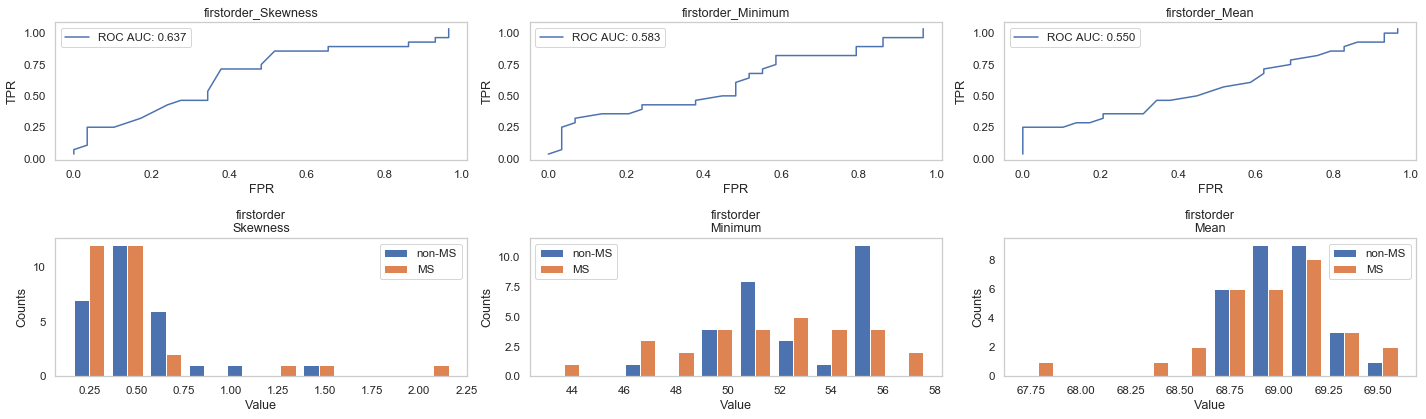

age_slope  age_corr  volume_corr  outcome_corr  \
feature                                                                       
PD_NAWM_firstorder_Skewness   0.004518  0.255466    -0.091581      0.060146   
PD_NAWM_firstorder_Minimum    0.092799  0.077449    -0.148209     -0.382264   
PD_NAWM_firstorder_Mean       0.008933  0.213529    -0.006399      0.315435   

                             univar_auc  p_MW_corr  
feature                                             
PD_NAWM_firstorder_Skewness    0.510417        1.0  
PD_NAWM_firstorder_Minimum     0.727238        1.0  
PD_NAWM_firstorder_Mean        0.657793        1.0

In [44]:
features_to_model_PD_NAWM_rand = featuresSelectionPipeline('../features/features_CRC_PD_NAWM_rand.csv', ds_names_train, 
                                                         100, 3, 'PD', 'NAWM')

original_glrlm_LongRunLowGrayLevelEmphasis  excluded
original_glszm_LowGrayLevelZoneEmphasis  excluded
Non uniform features:  ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency', 'original_glcm_Contrast', 'original_glcm_Correlation', 'original_glcm_DifferenceAverage', 'original_glcm_DifferenceEnt

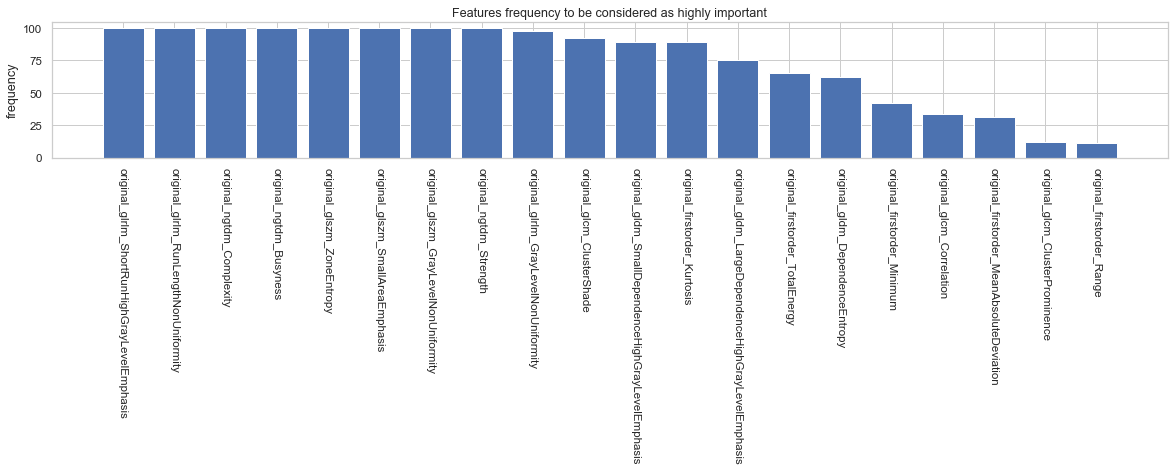

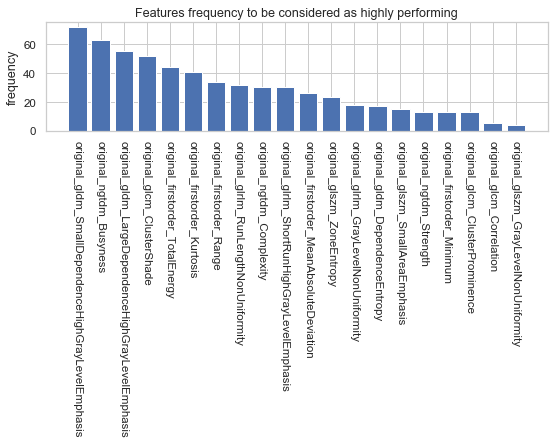

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


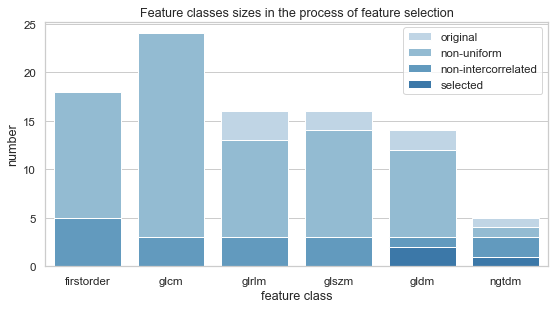

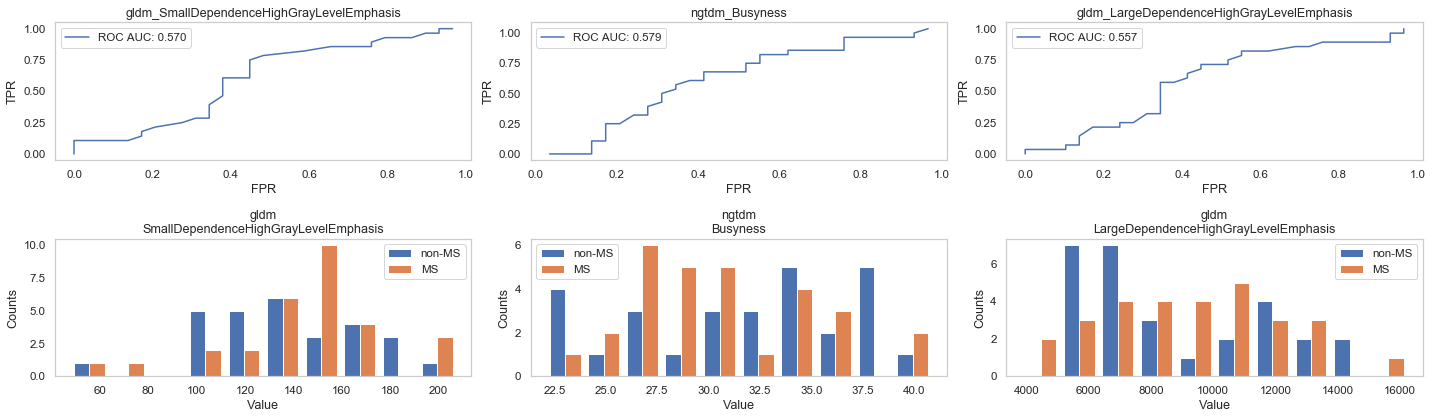

age_slope  age_corr  \
feature                                                                  
MT_NAWM_gldm_SmallDependenceHighGrayLevelEmphasis  -0.133467 -0.163624   
MT_NAWM_ngtdm_Busyness                             -0.074504  0.000773   
MT_NAWM_gldm_LargeDependenceHighGrayLevelEmphasis  67.720450  0.042226   

                                                   volume_corr  outcome_corr  \
feature                                                                        
MT_NAWM_gldm_SmallDependenceHighGrayLevelEmphasis    -0.149977      0.052127   
MT_NAWM_ngtdm_Busyness                                0.551933      0.362215   
MT_NAWM_gldm_LargeDependenceHighGrayLevelEmphasis     0.018201     -0.656265   

                                                   univar_auc  p_MW_corr  
feature                                                                   
MT_NAWM_gldm_SmallDependenceHighGrayLevelEmphasis    0.498457   1.000000  
MT_NAWM_ngtdm_Busyness                               0.683642   1.000000  
MT_NAWM_gldm_LargeDependenceHighGrayLevelEmphasis    0.879244   0.000047

In [45]:
features_to_model_MT_NAWM_rand = featuresSelectionPipeline('../features/features_CRC_MT_NAWM_rand.csv', ds_names_train, 
                                                         100, 3, 'MT', 'NAWM')

original_glrlm_LongRunLowGrayLevelEmphasis  excluded
original_glrlm_LowGrayLevelRunEmphasis  excluded
original_glrlm_ShortRunLowGrayLevelEmphasis  excluded
original_glszm_LowGrayLevelZoneEmphasis  excluded
original_glszm_SmallAreaLowGrayLevelEmphasis  excluded
original_gldm_LowGrayLevelEmphasis  excluded
Non uniform features:  ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glc

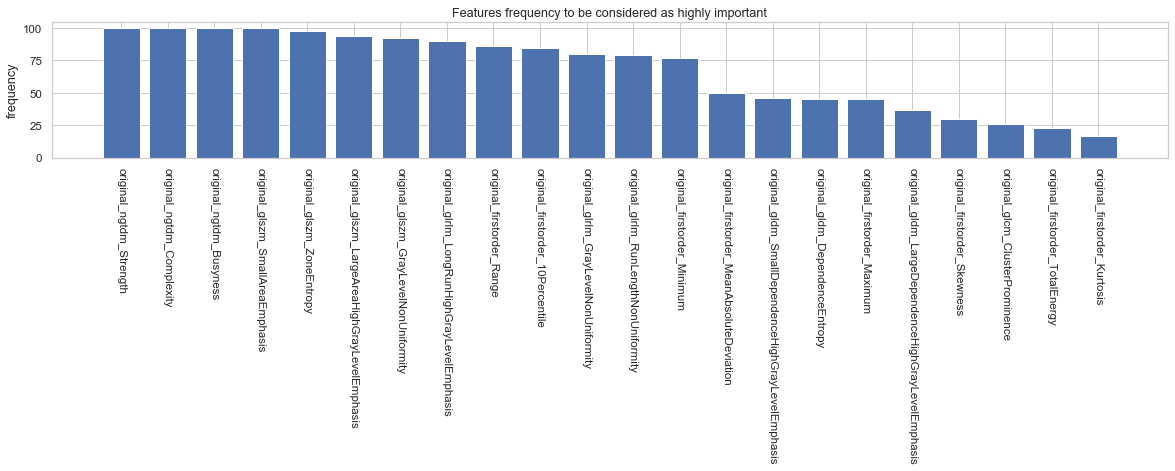

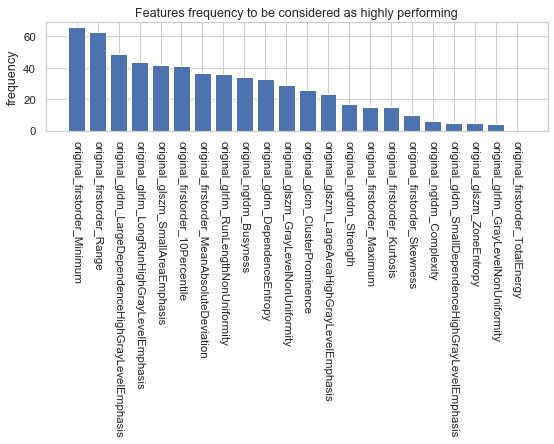

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


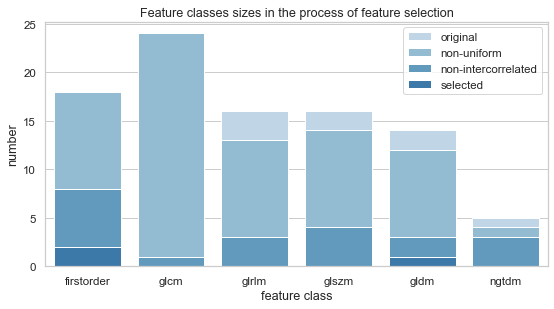

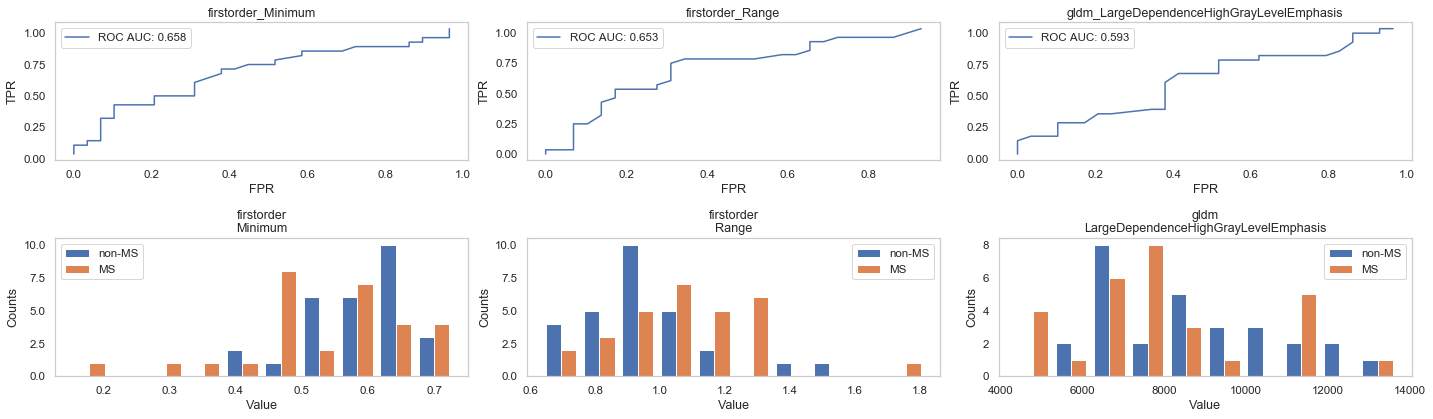

age_slope  age_corr  \
feature                                                                  
R1_NAWM_firstorder_Minimum                         -0.001109 -0.184423   
R1_NAWM_firstorder_Range                           -0.000170  0.107199   
R1_NAWM_gldm_LargeDependenceHighGrayLevelEmphasis  62.222286  0.149425   

                                                   volume_corr  outcome_corr  \
feature                                                                        
R1_NAWM_firstorder_Minimum                           -0.146344     -0.650918   
R1_NAWM_firstorder_Range                              0.318091      0.372908   
R1_NAWM_gldm_LargeDependenceHighGrayLevelEmphasis     0.007203     -0.164400   

                                                   univar_auc  p_MW_corr  
feature                                                                   
R1_NAWM_firstorder_Minimum                           0.874614    0.00006  
R1_NAWM_firstorder_Range                             0.684799    1.00000  
R1_NAWM_gldm_LargeDependenceHighGrayLevelEmphasis    0.593750    1.00000

In [46]:
features_to_model_R1_NAWM_rand = featuresSelectionPipeline('../features/features_CRC_R1_NAWM_rand.csv', ds_names_train, 
                                                         100, 3, 'R1', 'NAWM')

original_glrlm_LongRunLowGrayLevelEmphasis  excluded
original_glrlm_LowGrayLevelRunEmphasis  excluded
original_glrlm_ShortRunLowGrayLevelEmphasis  excluded
original_glszm_LowGrayLevelZoneEmphasis  excluded
original_glszm_SmallAreaLowGrayLevelEmphasis  excluded
original_gldm_LowGrayLevelEmphasis  excluded
Non uniform features:  ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glc

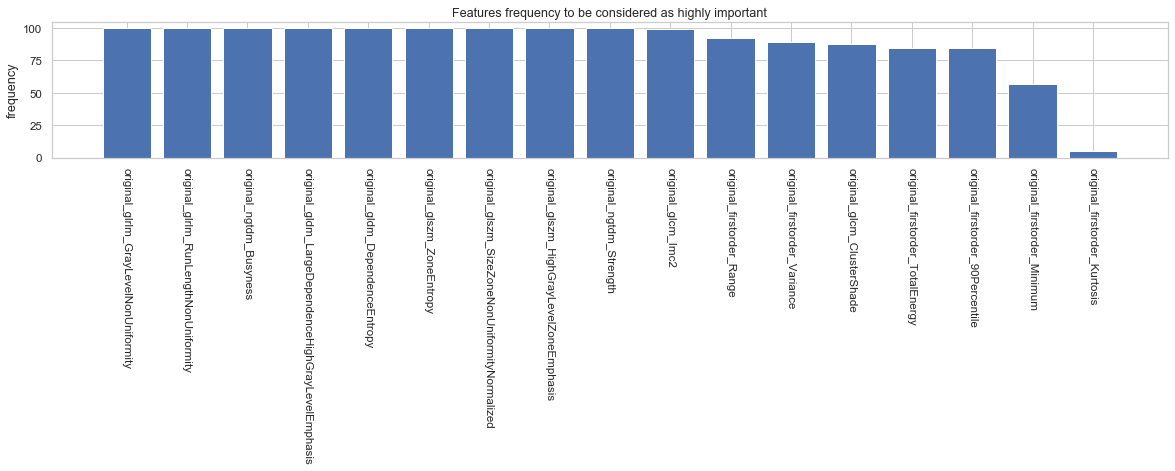

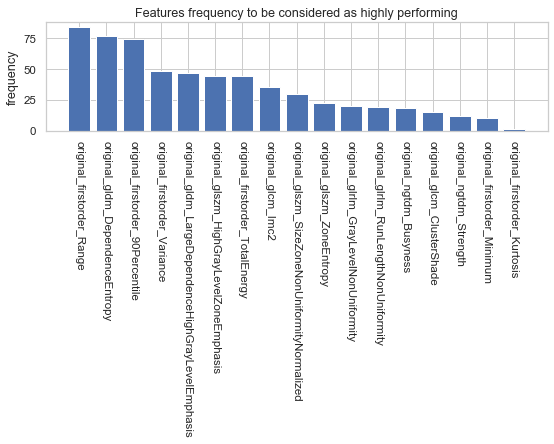

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


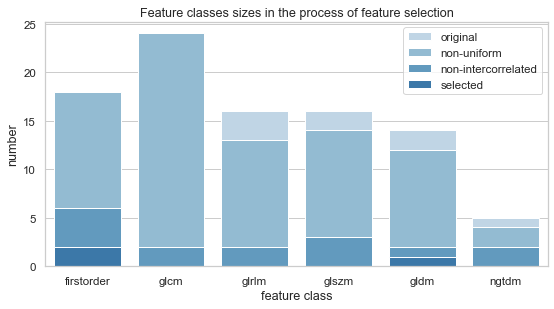

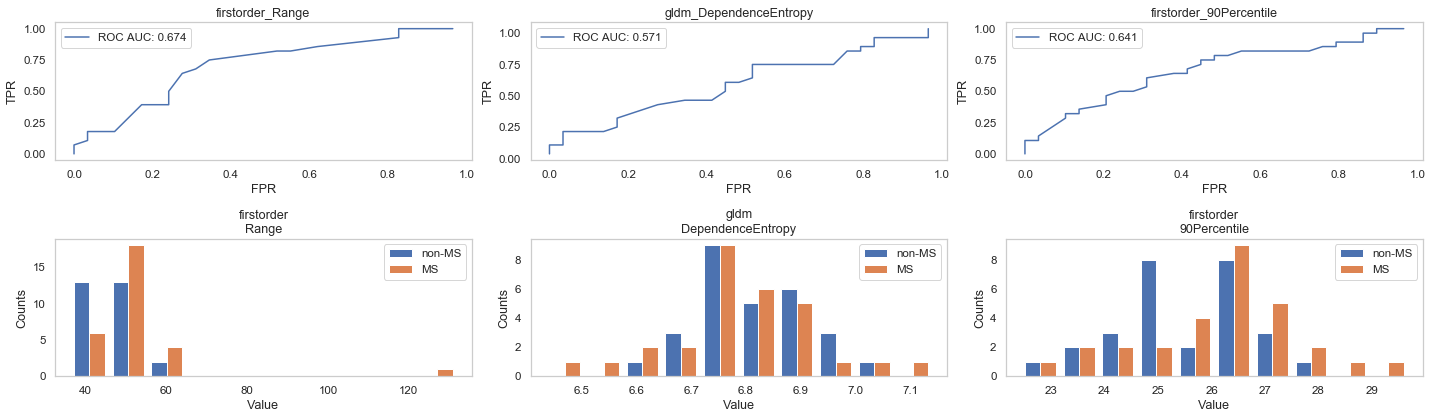

age_slope  age_corr  volume_corr  \
feature                                                              
R2s_NAWM_firstorder_Range          0.121429  0.313758     0.108399   
R2s_NAWM_gldm_DependenceEntropy    0.000428  0.063540     0.329925   
R2s_NAWM_firstorder_90Percentile   0.047768  0.382740     0.267155   

                                  outcome_corr  univar_auc  p_MW_corr  
feature                                                                
R2s_NAWM_firstorder_Range            -0.101581    0.440201   1.000000  
R2s_NAWM_gldm_DependenceEntropy      -0.370235    0.711420   1.000000  
R2s_NAWM_firstorder_90Percentile     -0.425035    0.746914   0.492008

In [47]:
features_to_model_R2s_NAWM_rand = featuresSelectionPipeline('../features/features_CRC_R2s_NAWM_rand.csv', ds_names_train, 
                                                         100, 3, 'R2s', 'NAWM')

PD_glrlm_LongRunLowGrayLevelEmphasis  excluded
PD_glrlm_LowGrayLevelRunEmphasis  excluded
PD_glrlm_ShortRunLowGrayLevelEmphasis  excluded
PD_glszm_LowGrayLevelZoneEmphasis  excluded
PD_glszm_SmallAreaLowGrayLevelEmphasis  excluded
PD_gldm_LowGrayLevelEmphasis  excluded
MT_glrlm_LongRunLowGrayLevelEmphasis  excluded
MT_glszm_LowGrayLevelZoneEmphasis  excluded
R1_glrlm_LongRunLowGrayLevelEmphasis  excluded
R1_glrlm_LowGrayLevelRunEmphasis  excluded
R1_glrlm_ShortRunLowGrayLevelEmphasis  excluded
R1_glszm_LowGrayLevelZoneEmphasis  excluded
R1_glszm_SmallAreaLowGrayLevelEmphasis  excluded
R1_gldm_LowGrayLevelEmphasis  excluded
R2_glrlm_LongRunLowGrayLevelEmphasis  excluded
R2_glrlm_LowGrayLevelRunEmphasis  excluded
R2_glrlm_ShortRunLowGrayLevelEmphasis  excluded
R2_glszm_LowGrayLevelZoneEmphasis  excluded
R2_glszm_SmallAreaLowGrayLevelEmphasis  excluded
R2_gldm_LowGrayLevelEmphasis  excluded
Non uniform features:  ['PD_firstorder_10Percentile', 'PD_firstorder_90Percentile', 'PD_firstorder_

Non intercorrelated features:  ['PD_firstorder_Kurtosis', 'PD_firstorder_Maximum', 'PD_firstorder_RootMeanSquared', 'PD_firstorder_Skewness', 'PD_glcm_ClusterProminence', 'PD_glcm_ClusterShade', 'PD_glcm_Correlation', 'PD_glcm_SumAverage', 'PD_glrlm_GrayLevelNonUniformity', 'PD_glszm_GrayLevelNonUniformity', 'PD_glszm_SizeZoneNonUniformityNormalized', 'PD_gldm_DependenceEntropy', 'PD_gldm_LargeDependenceHighGrayLevelEmphasis', 'PD_gldm_SmallDependenceHighGrayLevelEmphasis', 'PD_ngtdm_Busyness', 'PD_ngtdm_Complexity', 'PD_ngtdm_Strength', 'MT_firstorder_Kurtosis', 'MT_firstorder_Minimum', 'MT_firstorder_Range', 'MT_firstorder_TotalEnergy', 'MT_firstorder_Variance', 'MT_glcm_ClusterProminence', 'MT_glcm_ClusterShade', 'MT_glcm_Correlation', 'MT_glrlm_GrayLevelNonUniformity', 'MT_glrlm_ShortRunHighGrayLevelEmphasis', 'MT_glszm_GrayLevelNonUniformity', 'MT_glszm_SizeZoneNonUniformity', 'MT_glszm_SizeZoneNonUniformityNormalized', 'MT_gldm_DependenceEntropy', 'MT_gldm_SmallDependenceHighGray

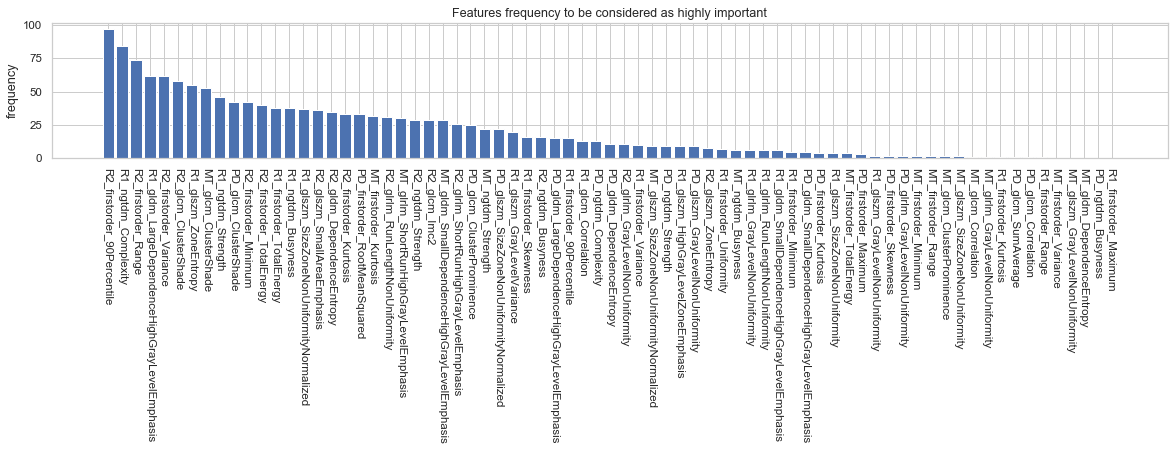

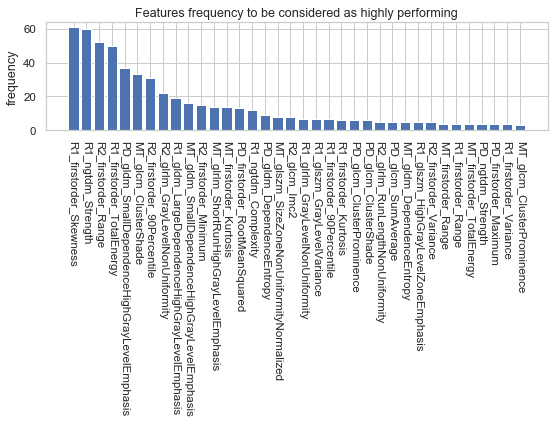

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


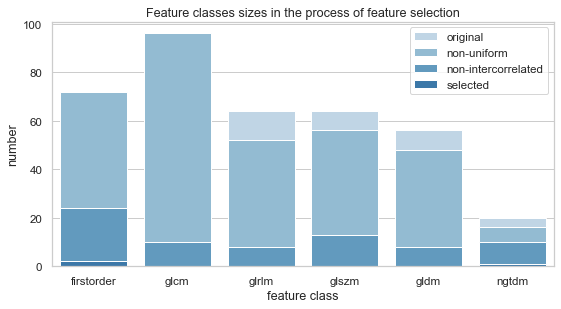

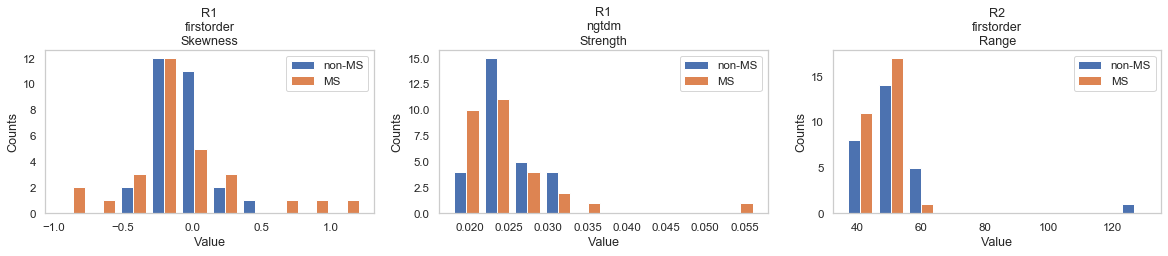

In [48]:
features_to_model_qMRI_NAWM_rand = featuresSelectionPipeline('../features/features_CRC_qMRI_NAWM_rand.csv', ds_names_train, 
                                                         100, 3, 'qMRI', 'NAWM')

Non uniform features:  ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency', 'original_glcm_Contrast', 'original_glcm_Correlation', 'original_glcm_DifferenceAverage', 'original_glcm_DifferenceEntropy', 'original_glcm_DifferenceVariance', 'original_glcm_Id', 'original_glcm_Idm', 'original_glcm_Idmn

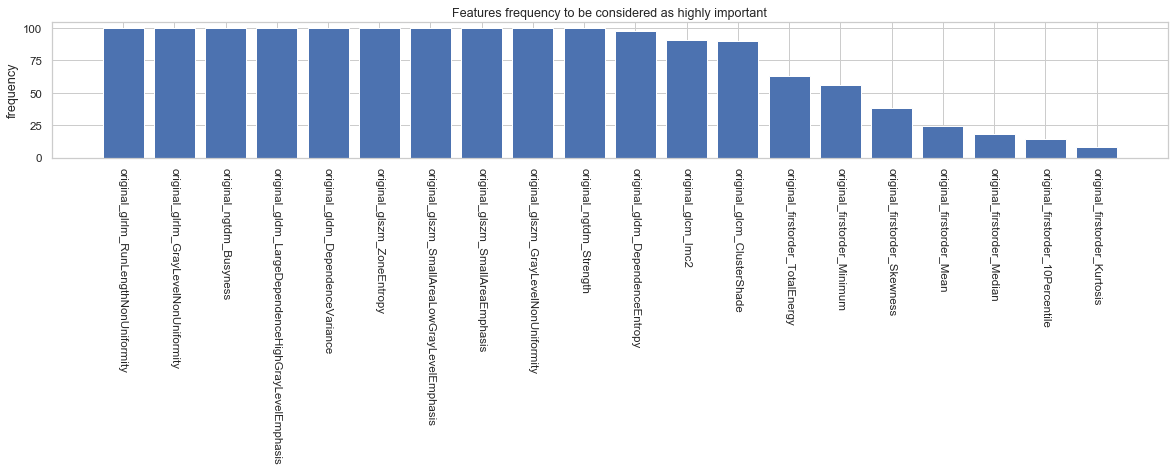

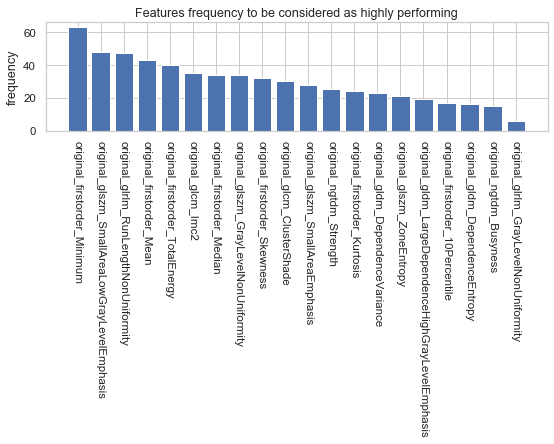

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


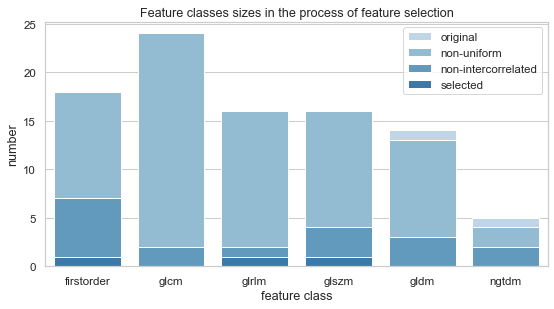

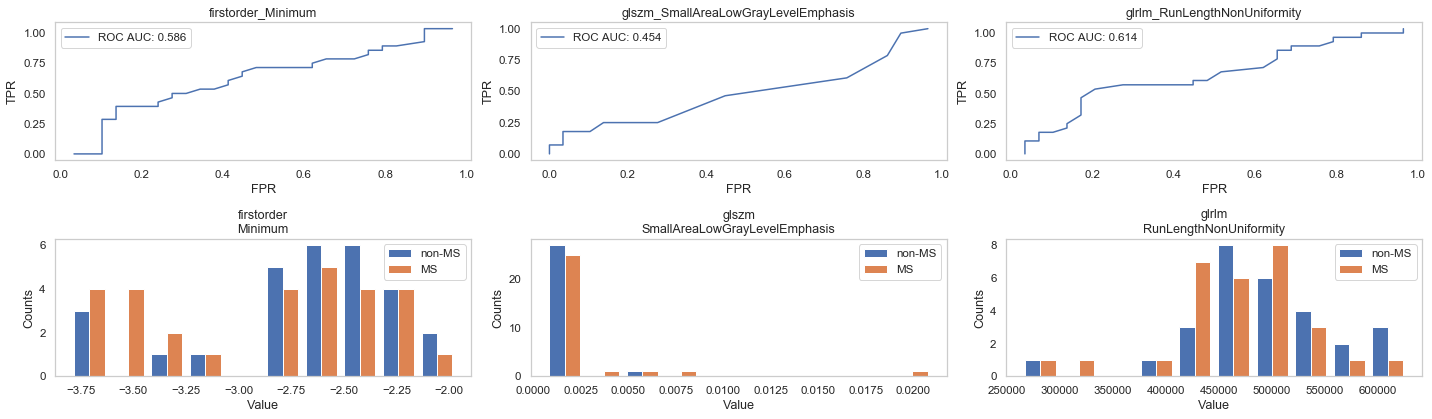

age_slope  age_corr  \
feature                                                             
T1w_GM_firstorder_Minimum                     -0.006585 -0.052932   
T1w_GM_glszm_SmallAreaLowGrayLevelEmphasis    -0.000020 -0.004846   
T1w_GM_glrlm_RunLengthNonUniformity        -1117.871768 -0.231672   

                                            volume_corr  outcome_corr  \
feature                                                                 
T1w_GM_firstorder_Minimum                      0.059039     -0.010693   
T1w_GM_glszm_SmallAreaLowGrayLevelEmphasis     0.107081      0.290040   
T1w_GM_glrlm_RunLengthNonUniformity            0.335938     -0.307415   

                                            univar_auc  p_MW_corr  
feature                                                            
T1w_GM_firstorder_Minimum                     0.466821        1.0  
T1w_GM_glszm_SmallAreaLowGrayLevelEmphasis    0.625386        1.0  
T1w_GM_glrlm_RunLengthNonUniformity           0.680170        1.0

In [49]:
features_to_model_T1_GM_rand = featuresSelectionPipeline('../features/features_CRC_T1w_GM_rand.csv', ds_names_train, 
                                                         100, 3, 'T1w', 'GM')

original_glrlm_LowGrayLevelRunEmphasis  excluded
original_glrlm_ShortRunLowGrayLevelEmphasis  excluded
original_glszm_LowGrayLevelZoneEmphasis  excluded
original_gldm_LowGrayLevelEmphasis  excluded
Non uniform features:  ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency', 'original_glcm_Contrast

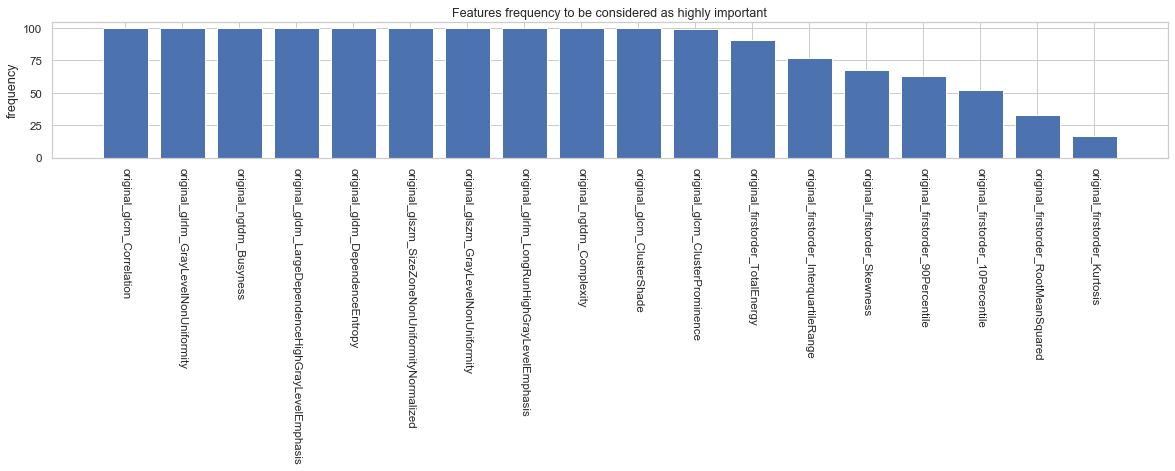

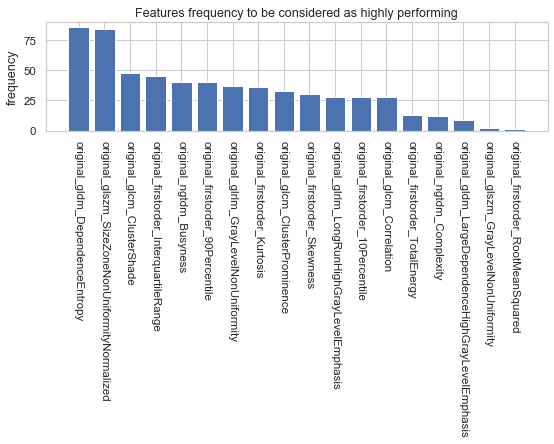

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


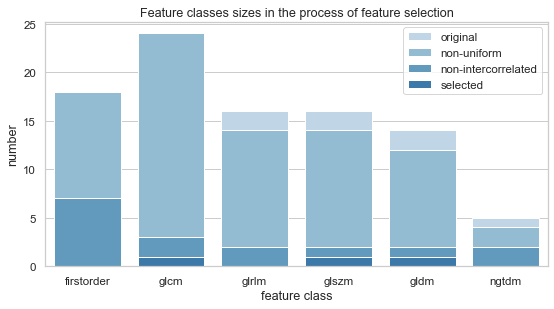

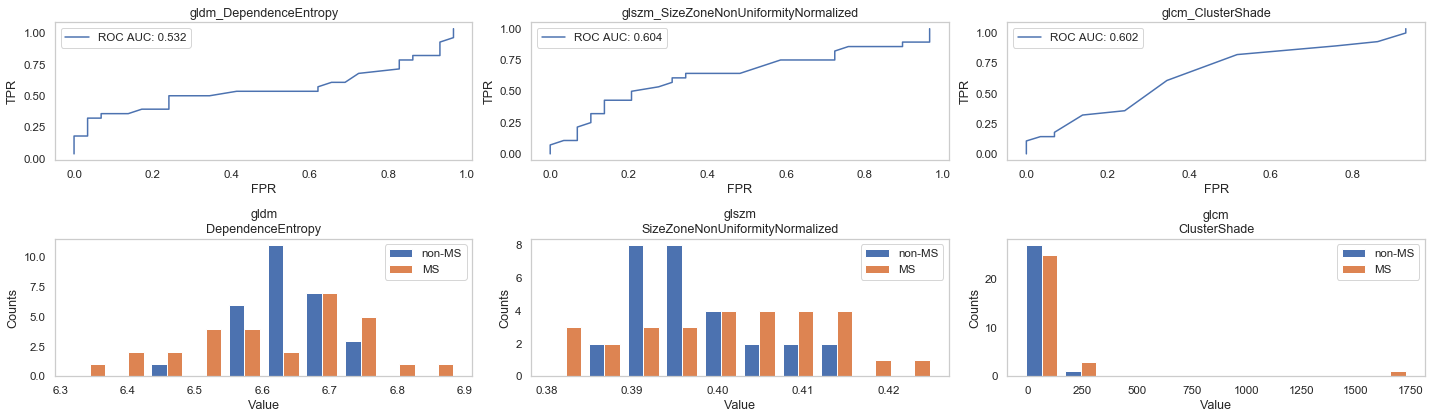

age_slope  age_corr  volume_corr  \
feature                                                                         
PD_GM_gldm_DependenceEntropy                 -0.003348 -0.310925     0.239212   
PD_GM_glszm_SizeZoneNonUniformityNormalized   0.000005  0.085805    -0.208534   
PD_GM_glcm_ClusterShade                      -0.684394  0.138994     0.114413   

                                             outcome_corr  univar_auc  \
feature                                                                 
PD_GM_gldm_DependenceEntropy                    -0.328801    0.686728   
PD_GM_glszm_SizeZoneNonUniformityNormalized      0.392957    0.700231   
PD_GM_glcm_ClusterShade                          0.213854    0.624614   

                                             p_MW_corr  
feature                                                 
PD_GM_gldm_DependenceEntropy                       1.0  
PD_GM_glszm_SizeZoneNonUniformityNormalized        1.0  
PD_GM_glcm_ClusterShade                            1.0

In [50]:
features_to_model_PD_GM_rand = featuresSelectionPipeline('../features/features_CRC_PD_GM_rand.csv', ds_names_train, 
                                                         100, 3, 'PD', 'GM')

original_firstorder_Minimum  excluded
original_glcm_JointEnergy  excluded
Non uniform features:  ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency', 'original_glcm_Contrast', 'original_glcm_Correlation', 'original_glcm_DifferenceAverage', 'original_glcm_DifferenceEntropy', 'original_glcm_DifferenceVariance', 'original_glcm_Id

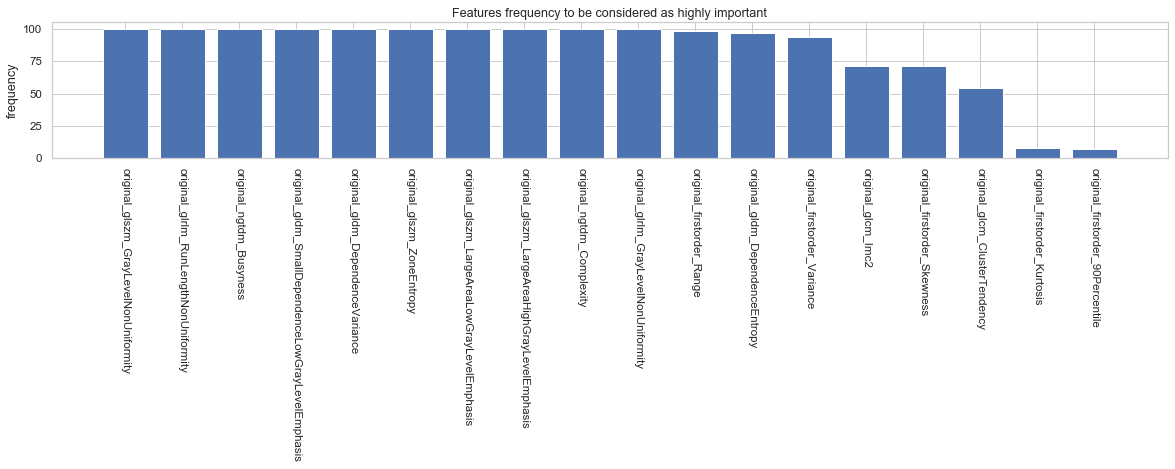

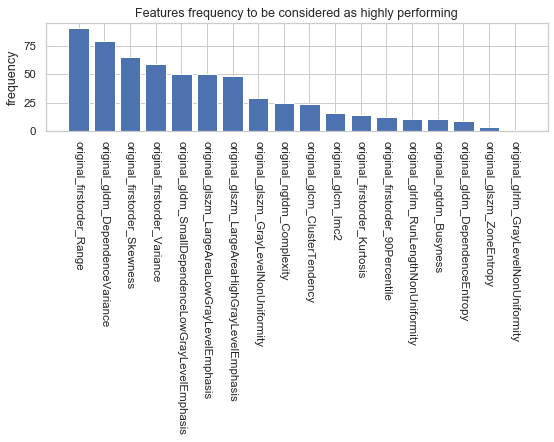

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


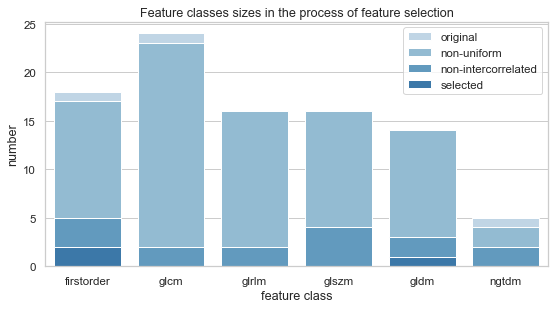

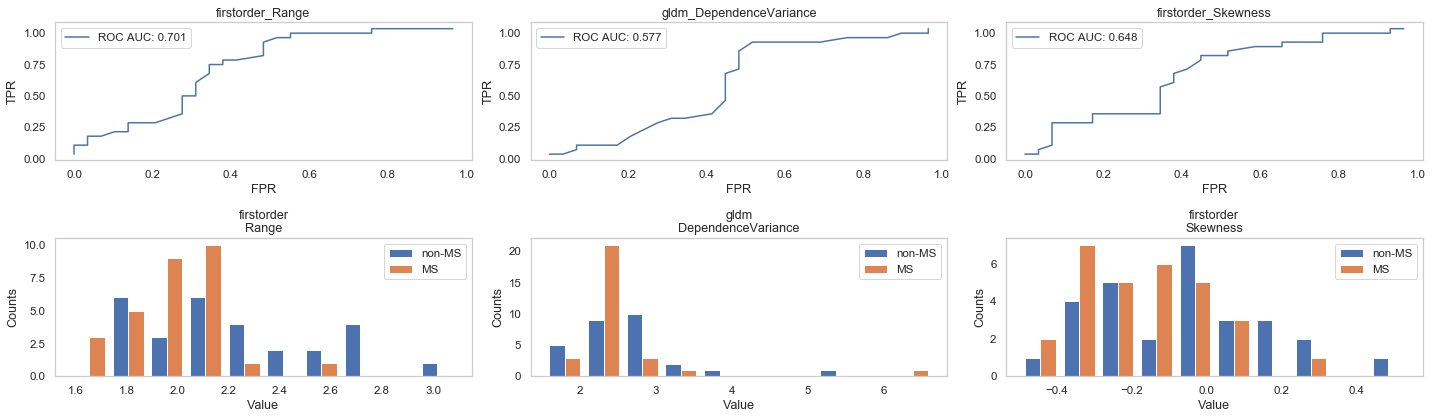

age_slope  age_corr  volume_corr  outcome_corr  \
feature                                                                         
MT_GM_firstorder_Range          0.002832  0.130751     0.276835      0.002673   
MT_GM_gldm_DependenceVariance   0.004432 -0.169967     0.143771     -0.161727   
MT_GM_firstorder_Skewness      -0.012652 -0.448035     0.392823      0.259298   

                               univar_auc  p_MW_corr  
feature                                               
MT_GM_firstorder_Range           0.498457        1.0  
MT_GM_gldm_DependenceVariance    0.587191        1.0  
MT_GM_firstorder_Skewness        0.623457        1.0

In [51]:
features_to_model_MT_GM_rand = featuresSelectionPipeline('../features/features_CRC_MT_GM_rand.csv', ds_names_train, 
                                                         100, 3, 'MT', 'GM')

original_glcm_Idmn  excluded
original_glcm_MaximumProbability  excluded
original_glszm_SmallAreaLowGrayLevelEmphasis  excluded
Non uniform features:  ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency', 'original_glcm_Contrast', 'original_glcm_Correlation', 'original_glcm_DifferenceAverage', 'ori

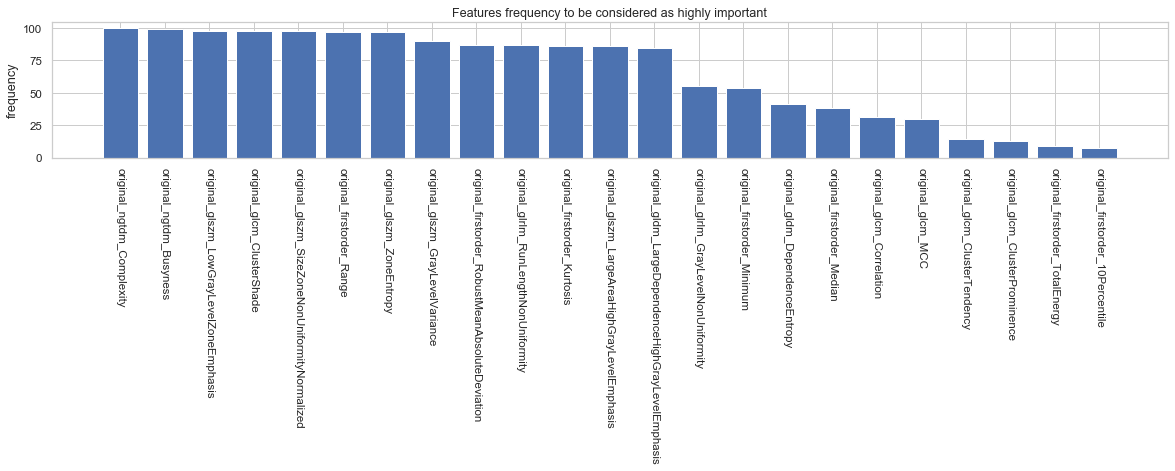

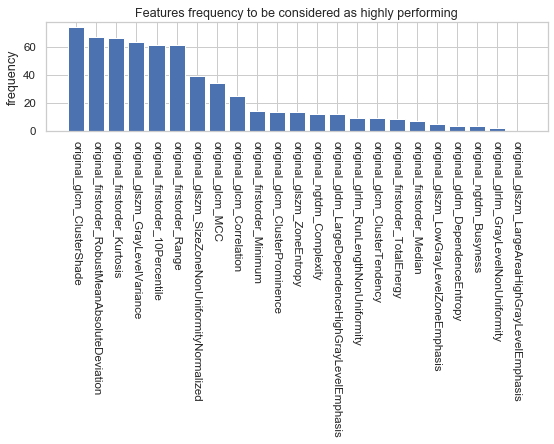

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


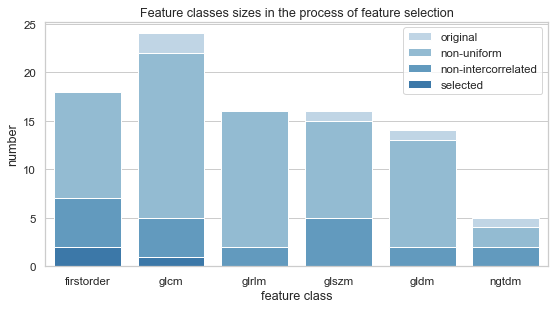

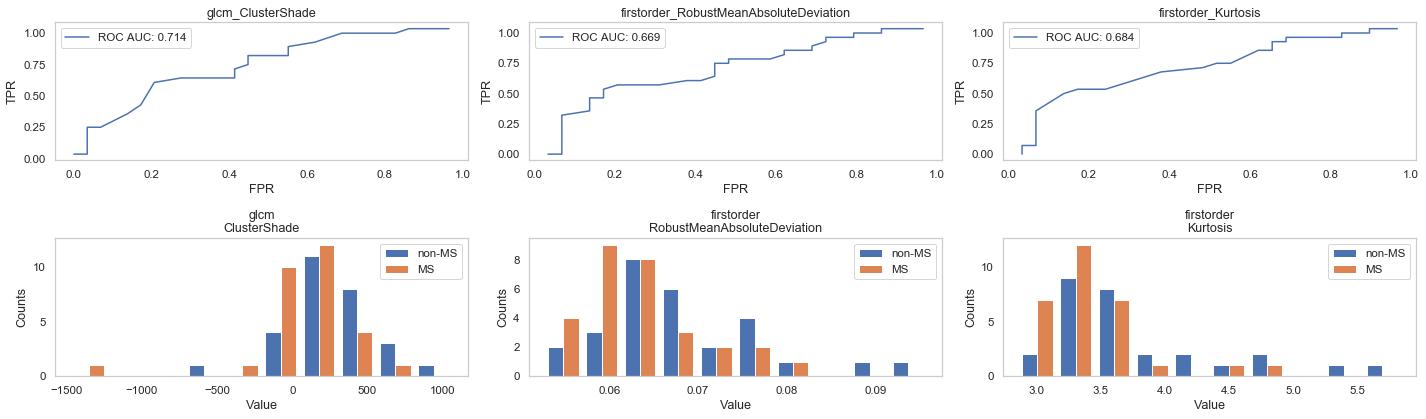

age_slope  age_corr  \
feature                                                             
R1_GM_glcm_ClusterShade                      -14.951059 -0.300364   
R1_GM_firstorder_RobustMeanAbsoluteDeviation  -0.000018  0.276748   
R1_GM_firstorder_Kurtosis                     -0.007311 -0.032905   

                                              volume_corr  outcome_corr  \
feature                                                                   
R1_GM_glcm_ClusterShade                          0.229597      0.151034   
R1_GM_firstorder_RobustMeanAbsoluteDeviation     0.289118      0.311425   
R1_GM_firstorder_Kurtosis                        0.103994      0.129649   

                                              univar_auc  p_MW_corr  
feature                                                              
R1_GM_glcm_ClusterShade                         0.554012        1.0  
R1_GM_firstorder_RobustMeanAbsoluteDeviation    0.652778        1.0  
R1_GM_firstorder_Kurtosis                       0.548611        1.0

In [52]:
features_to_model_R1_GM_rand = featuresSelectionPipeline('../features/features_CRC_R1_GM_rand.csv', ds_names_train, 
                                                         100, 3, 'R1', 'GM')

Non uniform features:  ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency', 'original_glcm_Contrast', 'original_glcm_Correlation', 'original_glcm_DifferenceAverage', 'original_glcm_DifferenceEntropy', 'original_glcm_DifferenceVariance', 'original_glcm_Id', 'original_glcm_Idm', 'original_glcm_Idmn

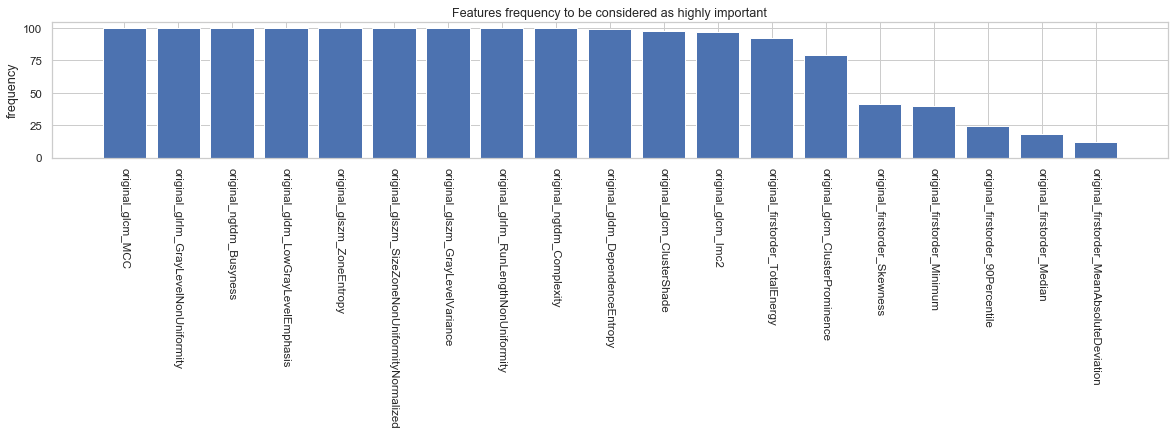

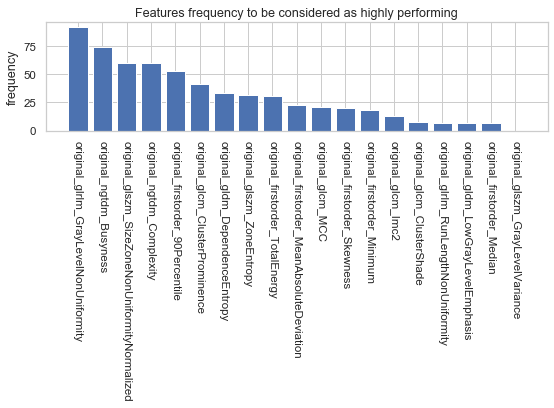

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


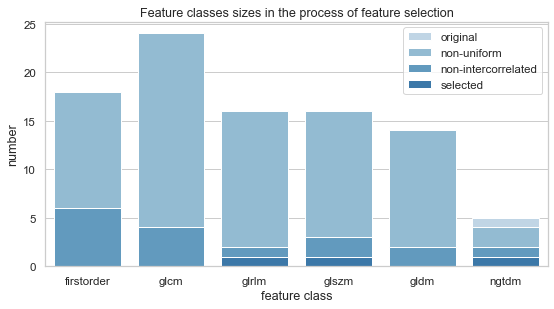

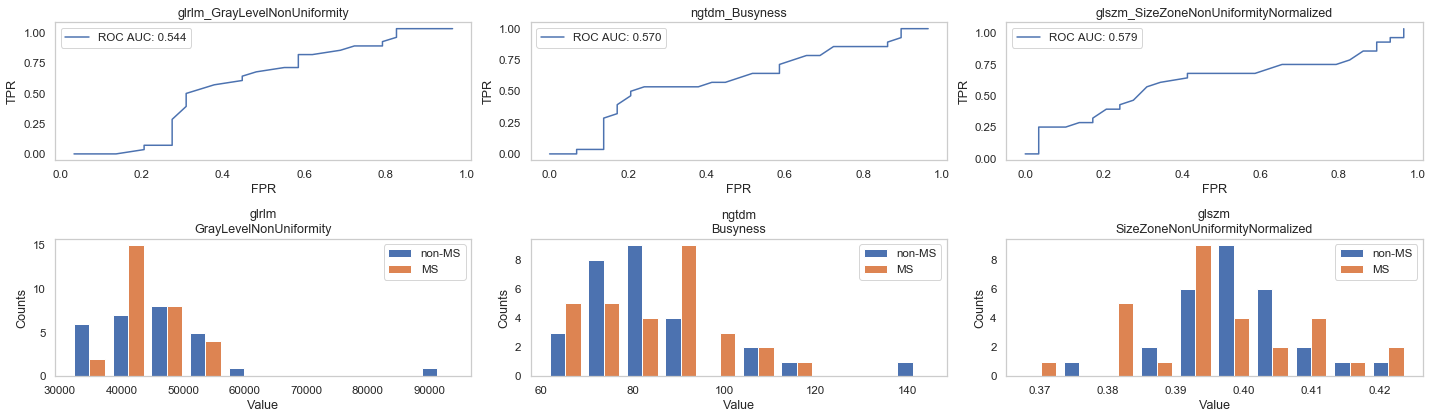

age_slope  age_corr  \
feature                                                             
R2s_GM_glrlm_GrayLevelNonUniformity           80.333694  0.039811   
R2s_GM_ngtdm_Busyness                         -0.215997 -0.054477   
R2s_GM_glszm_SizeZoneNonUniformityNormalized  -0.000121 -0.147043   

                                              volume_corr  outcome_corr  \
feature                                                                   
R2s_GM_glrlm_GrayLevelNonUniformity              0.052897     -0.413006   
R2s_GM_ngtdm_Busyness                            0.251978      0.339493   
R2s_GM_glszm_SizeZoneNonUniformityNormalized    -0.186861      0.013366   

                                              univar_auc  p_MW_corr  
feature                                                              
R2s_GM_glrlm_GrayLevelNonUniformity             0.733025    0.72136  
R2s_GM_ngtdm_Busyness                           0.699074    1.00000  
R2s_GM_glszm_SizeZoneNonUniformityNormalized    0.490741    1.00000

In [53]:
features_to_model_R2s_GM_rand = featuresSelectionPipeline('../features/features_CRC_R2s_GM_rand.csv', ds_names_train, 
                                                         100, 3, 'R2s', 'GM')

PD_glrlm_LowGrayLevelRunEmphasis  excluded
PD_glrlm_ShortRunLowGrayLevelEmphasis  excluded
PD_glszm_LowGrayLevelZoneEmphasis  excluded
PD_gldm_LowGrayLevelEmphasis  excluded
MT_firstorder_Minimum  excluded
MT_glcm_JointEnergy  excluded
R1_glcm_Idmn  excluded
R1_glcm_MaximumProbability  excluded
R1_glszm_SmallAreaLowGrayLevelEmphasis  excluded
Non uniform features:  ['PD_firstorder_10Percentile', 'PD_firstorder_90Percentile', 'PD_firstorder_Energy', 'PD_firstorder_Entropy', 'PD_firstorder_InterquartileRange', 'PD_firstorder_Kurtosis', 'PD_firstorder_Maximum', 'PD_firstorder_MeanAbsoluteDeviation', 'PD_firstorder_Mean', 'PD_firstorder_Median', 'PD_firstorder_Minimum', 'PD_firstorder_Range', 'PD_firstorder_RobustMeanAbsoluteDeviation', 'PD_firstorder_RootMeanSquared', 'PD_firstorder_Skewness', 'PD_firstorder_TotalEnergy', 'PD_firstorder_Uniformity', 'PD_firstorder_Variance', 'PD_glcm_Autocorrelation', 'PD_glcm_ClusterProminence', 'PD_glcm_ClusterShade', 'PD_glcm_ClusterTendency', 'PD_glcm

Non intercorrelated features:  ['PD_firstorder_10Percentile', 'PD_firstorder_90Percentile', 'PD_firstorder_InterquartileRange', 'PD_firstorder_Kurtosis', 'PD_firstorder_RootMeanSquared', 'PD_firstorder_Skewness', 'PD_firstorder_TotalEnergy', 'PD_glcm_ClusterProminence', 'PD_glcm_ClusterShade', 'PD_glcm_MCC', 'PD_glrlm_GrayLevelNonUniformity', 'PD_glrlm_LongRunHighGrayLevelEmphasis', 'PD_glszm_GrayLevelNonUniformity', 'PD_glszm_SizeZoneNonUniformityNormalized', 'PD_gldm_DependenceEntropy', 'PD_gldm_LargeDependenceHighGrayLevelEmphasis', 'PD_ngtdm_Busyness', 'MT_firstorder_Kurtosis', 'MT_firstorder_Range', 'MT_firstorder_Variance', 'MT_glcm_ClusterShade', 'MT_glcm_ClusterTendency', 'MT_glcm_Imc2', 'MT_glcm_MaximumProbability', 'MT_glrlm_GrayLevelNonUniformity', 'MT_glszm_GrayLevelNonUniformity', 'MT_glszm_LargeAreaHighGrayLevelEmphasis', 'MT_glszm_LargeAreaLowGrayLevelEmphasis', 'MT_glszm_ZoneEntropy', 'MT_gldm_DependenceEntropy', 'MT_gldm_SmallDependenceLowGrayLevelEmphasis', 'MT_ngtdm_

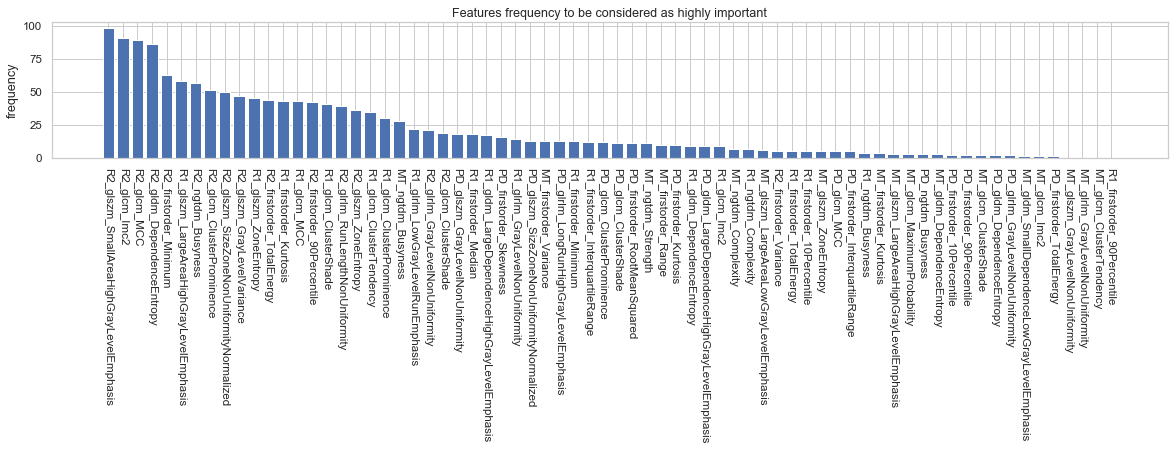

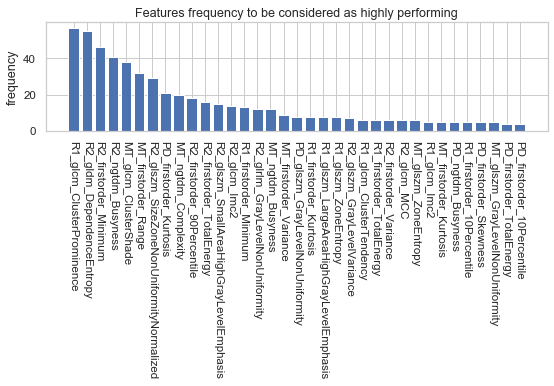

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


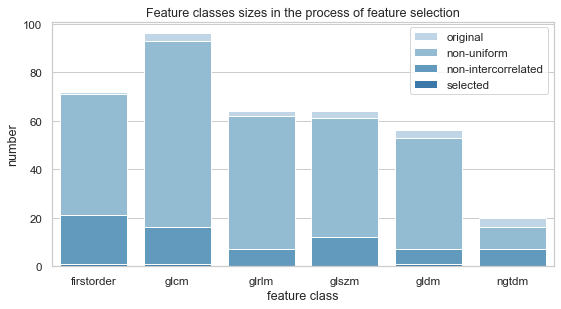

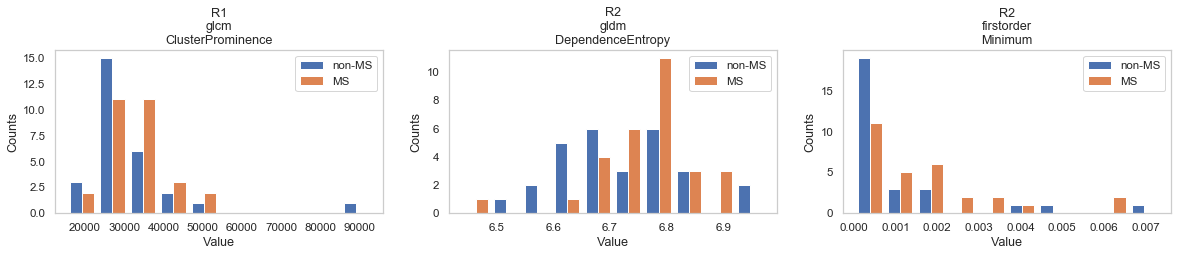

In [54]:
features_to_model_qMRI_GM_rand = featuresSelectionPipeline('../features/features_CRC_qMRI_GM_rand.csv', ds_names_train, 
                                                         100, 3, 'qMRI', 'GM')